# Week 8 - Feature Selection

### April 14, 2017

#### Objectives
  1. Combine operations & clinical features to determine if both domains of features improve the regression model.
  2. Explore various Feature Selection methods to improve models' metrics and reduce overfitting.
    * Random Forest Feature Importance
    * Univariate Feature Selection (F-Regression)
    * Random Selection (`np.random`)
    * Principal Component Analysis (Eigenvectors Dimension Reduction)
    * K-Means Clustering
    * Variance Treshold

In [52]:
import psycopg2
from psycopg2 import extras
import sys, os
import numpy as np
import pandas as pd
from scipy import stats
import itertools
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def cursor_connect(cursor_factory=None):
    """
    Connects to the DB and returns the connection and cursor, ready to use.
    
    Parameters
    ----------
    cursor_factory : psycopg2.extras
    
    Returns
    -------
    (psycopg2.extensions.connection, psycopg2.extensions.cursor)
        A tuple of (psycopg2 connection, psycopg2 cursor).
    """
    #DB connection
    conn = psycopg2.connect(dbname="mimic", user="mimic", host="localhost", port="2345",
                            password="oNuemmLeix9Yex7W")
    if not cursor_factory:
        cur = conn.cursor()
    else:
        cur = conn.cursor(cursor_factory=cursor_factory)
    return conn, cur

def exec_query(query, curs_dict=False):
    """
    Execute query and returns the SQL output.
    
    Parameters
    ----------
    query: string containing SQL SELECT command
    curs_dict: dict cursor factory (output is dict)
    
    Returns
    -------
    rows: list of rows/records (SQL output)
    """
    if curs_dict == True: 
        conn, cur = cursor_connect(psycopg2.extras.DictCursor)
    else:
        conn, cur = cursor_connect()
    cur.execute(query)
    rows = cur.fetchall()
    return rows

# Dataset

## Interval: 30 Days
Patients' ICU admissions within the last 30 days from the current ICU stay.

## Exclusion Criteria
1. Minors

## Features (`X`)

### Operations
* **`subjectid`**: subject ID of patients
* **`icustayid`**: ID of a unique ICU stay
* **`readm_days`**: number of days since discharge of previous ICU stay
* **`prev_iculos`**: total length of stay (LOS) of the previous unique ICU stay
* **`age`**: age of patient at the times of ICU admission
* **`ethnicity`**: categorical feature indicating ethnicity group
* **`marital_status`**: categorical feature indicating marital status.
* **`insurance`**: categorical feature indicating insurance type.
* **`NonEnglish`**: binary feature indicating non-english speaker.
* **`N`<sub>icutrav</sub>**: the number of total intra-ICU ward transfers (non-unique ICU stays)
* **`prev_cu`**: categorical feature indicating previous care unit
* **`curr_cu`**: categorical feature indicating current care unit
* **`prev_ICU`**: binary feature indicating if previous care unit was an ICU type
* **`disch_cu`**: categorical feature indicating discharge care unit from ICU stay
* **`disch_ICU`**: binary feature indicating if discharge care unit was an ICU type
* **`icu_in_day`**: time of ICU admission (day/night)
* **`icu_out_day`**: time of ICU discharge (day/night)
* **`readm_risk`**: risk score of intra-patient unique ICU readmissions
* Transfer Pairs
    * **`nonicu-MICU`**	
    * **`nonicu-SICU`**	
    * **`nonicu-TSICU`**	
    * **`nonicu-CSRU`**	
    * **`MICU-MICU`**	
    * **`TSICU-TSICU`**	
    * **`nonicu-CCU`**	
    * **`CCU-CCU`**
    * **`CSRU-CSRU`**	
    * **`SICU-SICU`**	
    
### Clinical
  * **Surgical Patients**: binary feature indicating the presence of surgery during an ICU stay 
  * **Abnormal Hemoglobin**: binary feature indicating the presence of abnormal hemoglobin results
  * **HADM Procedures**: series of binary features indicating presence of procedures during hospital admission.
 
## Dependent Variables/Response (`Y`) 
  * **`icu_los`**: ICU length of stay

### Unique ICU stays

Features:
  * **`subjectid`**: subject ID of patients
  * **`icustaysid`**: ID of a unique ICU stay
  * **`readm_days`**: number of days since discharge of previous ICU stay to admission of current ICU stay (ICU readmission)

In [3]:
def prev_icutime(data):
    if data['readm_days'] == np.nan:
        pass
    else:
        prev_icutime = data['icu_intime'] - data['readm_days'] # time of previous ICU discharge/transfer
        return prev_icutime

In [4]:
# query
q_icustay="""SELECT subject_id, hadm_id, icustay_id, min_in, max_out,
min_in - lag(max_out)
OVER (PARTITION BY subject_id ORDER BY min_in) AS diff
FROM
(SELECT subject_id, hadm_id, icustay_id, 
MIN(intime) as min_in, MAX(outtime) AS max_out
FROM transfers
WHERE icustay_id IS NOT NULL
GROUP BY subject_id, hadm_id, icustay_id) as sub_q
ORDER BY subject_id
"""

# Query output
icustay = exec_query(q_icustay)
df_icustay = pd.DataFrame(icustay, columns=['subjectid', 'hadmid', 'icustayid', 
                                            'icu_intime', # first unique ICU admission time 
                                            'icu_outtime', #  unique ICU discharge time
                                            'readm_days']) # number of days since last ICU discharge/transfer

df_icustay['icu_prev_outtime'] = df_icustay.apply(prev_icutime, axis=1)
# df_icustay.readm_days.fillna(0, inplace=True)
df_icustay.readm_days.dropna(inplace=True)
df_icustay['readm_days'] = np.round(df_icustay['readm_days'].astype(int) * (1/8.64e13), 3)
print df_icustay.shape
df_icustay.head()

(61532, 7)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,icu_prev_outtime
0,2,163353,243653,2138-07-17 21:20:07,2138-07-17 23:32:21,NaN,NaT
1,3,145834,211552,2101-10-20 19:10:11,2101-10-26 20:43:09,NaN,NaT
2,4,185777,294638,2191-03-16 00:29:31,2191-03-17 16:46:31,NaN,NaT
3,5,178980,214757,2103-02-02 06:04:24,2103-02-02 08:06:00,NaN,NaT
4,6,107064,228232,2175-05-30 21:30:54,2175-06-03 13:39:54,NaN,NaT


Filter for patients with ICU readmissions.

In [5]:
# query
q_readm_pat ="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

# Query output
readm_pat = exec_query(q_readm_pat, False)
df_readm_pat = pd.DataFrame(readm_pat, columns=['subjectid', 'n_icustays'])

df_readm = df_icustay[df_icustay['subjectid'].isin(df_readm_pat.subjectid)]
print df_readm.shape
df_readm.head()

(23811, 7)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,icu_prev_outtime
5,7,118037,278444,2121-05-23 15:35:29,2121-05-23 22:01:00,NaN,NaT
6,7,118037,236754,2121-05-25 03:26:01,2121-05-25 21:10:19,1.226,2121-05-23 22:01:00
14,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaT
15,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,2134-12-29 18:04:03
19,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaT


Extract prior ICUstay ID through `icu_prior_outtime`.

**Note**: Some ICUstays have duplicate entries (use of `DISTINCT ON` prevents duplicates)

In [6]:
q_previcu = """SELECT DISTINCT ON (subject_id, icustay_id, outtime) subject_id, icustay_id, outtime 
FROM transfers 
WHERE icustay_id IS NOT NULL;
"""
# Query output
prev_icustay = exec_query(q_previcu)
df_previcu = pd.DataFrame(prev_icustay, columns=['subjectid', 'prev_icustayid', 'icu_prev_outtime'])

df_readm = pd.merge(df_readm, df_previcu, on=['subjectid', 'icu_prev_outtime'], how='left')
df_readm.drop(labels='icu_prev_outtime', axis=1, inplace=True)
df_readm.head()

,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid
0,7,118037,278444,2121-05-23 15:35:29,2121-05-23 22:01:00,NaN,NaN
1,7,118037,236754,2121-05-25 03:26:01,2121-05-25 21:10:19,1.226,278444.0
2,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN
3,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042.0
4,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN


## Exclusion

#### Neonate Patients

In [7]:
q_nicu = """SELECT DISTINCT icustay_id FROM transfers              
WHERE curr_careunit = 'NICU' AND icustay_id IS NOT NULL;
"""
nicu_stays = exec_query(q_nicu)
df_nicu_stays = pd.DataFrame(nicu_stays, columns=['icustayid'])

df_readm = df_readm[df_readm['icustayid'].isin(df_nicu_stays.icustayid)==False]
df_readm.shape

(23357, 7)

#### Minors

In [8]:
# age of patients < 90
q_age_hadm1 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) < 90;"""

# adjusted age of patients > 89
q_age_hadm2 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) -210 AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) > 89;"""

age_hadm1 = exec_query(q_age_hadm1, False)
age_hadm2 = exec_query(q_age_hadm2, False)
df_age_hadm1 = pd.DataFrame(age_hadm1, columns=['subjectid', 'age'])
df_age_hadm2 = pd.DataFrame(age_hadm2, columns=['subjectid', 'age'])

df_age_hadm = pd.concat([df_age_hadm1, df_age_hadm2])
df_adults = df_age_hadm[df_age_hadm.age > 17]
df_adults_sid = list(df_adults.subjectid.value_counts().index.sort_values())

df_readm = df_readm[df_readm.subjectid.isin(df_adults_sid)]
df_readm.shape

(23353, 7)

## Dataset Interval/Period 

### Count for each Cutoff
Cutoff for days between last ICU stay discharge and current ICU admission.

In [9]:
count_disch = dict()
for elem in [30, 60, 90, 120, 150, 180]:
    count_disch[elem] = df_readm[df_readm.readm_days <= elem].shape[0]

df_count = pd.DataFrame.from_dict(count_disch, orient='index').reset_index()
df_count.columns = ['days_cutoff', 'count']
df_count.sort_values('days_cutoff', ascending=True)

,days_cutoff,count
5,30,6161
4,60,7626
3,90,8494
2,120,9061
1,150,9525
0,180,9914


### Interval: 30 Days

In [10]:
period = 30
df_readm = df_readm[df_readm['readm_days'] <= period]

### Previous ICU LOS
The total LOS of the previous unique ICU stay, *includes the duration of all intra-ICU stays*.

In [11]:
q_prevlos = """SELECT icustay_id, los 
FROM icustays;"""

prevlos = exec_query(q_prevlos)
df_prevlos = pd.DataFrame(prevlos, columns=['prev_icustayid', 'prev_iculos'])

df_readm1 = pd.merge(df_readm, df_prevlos, on='prev_icustayid', how='left')

print df_readm1.shape
df_readm1.head()

(6161, 8)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965


### Age
Age of times at the time of ICU admission.

**Notes**: 
  * Patients may have different age, depending on the time of admission.
  * MIMIC-III adjusts age of patients > 89 years old (+ 210 years)

In [12]:
def age_adj(age):
    if age > 89:
        return age - 210
    else:
        return age

In [13]:
q_age = """SELECT DISTINCT subject_id, dob FROM patients;"""

age = exec_query(q_age) # query output
df_age = pd.DataFrame(age, columns=['subjectid', 'dob'])

df_readm2 = pd.merge(df_readm1, df_age, on='subjectid', how='left')

# Calculate age
age = df_readm2.icu_intime.values.astype('datetime64[D]') - df_readm2.dob.values.astype('datetime64[D]')
age = age / 365
df_readm2['age'] = age.astype(int)
df_readm2['age'] = df_readm2.age.apply(age_adj)

df_readm2 = df_readm2[df_readm2.age > 17]
df_readm2.drop('dob', axis=1, inplace=True)

print df_readm2.shape
df_readm2.head()

(6161, 9)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81


### Ethnicity
Ethnicity of the patients.

Legend:
  * `0`: Asian
  * `1`: Black
  * `2`: Hispanic
  * `3`: White
  * `4`: Other
  * `5`: N/A

**Notes**:
  * Prior exploratory data analyses found that African-Americans were the leading group for being prone to ICU readmissions.  85% of their group were readmitted into the ICU.
  * Dataset provides many specific ethnicity categories, thus providing little sample size when grouping the data by ethnicity. The feature/column has been processed in order to bin the data into more broad ethnicity categorizations.
    * Ethnicity na accounts for data unable to be collected or declined by patients.

In [14]:
def overall_ethn(ethn):
    if 'hispanic' in ethn.lower():
        new_ethn = 'hispanic'
    elif 'asian' in ethn.lower() or 'pacific islander' in ethn.lower():
        new_ethn = 'asian'
    elif 'white' in ethn.lower():
        new_ethn = 'white'
    elif 'black' in ethn.lower():
        new_ethn = 'black'
    elif 'decline' in ethn.lower() or 'unable' in ethn.lower():
        new_ethn = 'na'
    else:
        new_ethn = 'other'
    return new_ethn

In [15]:
q_ethn = """SELECT DISTINCT ON (subject_id) subject_id, ethnicity 
FROM admissions;"""

ethnicity = exec_query(q_ethn) # query output
df_ethn = pd.DataFrame(ethnicity, columns=['subjectid', 'ethnicity'])

df_readm3 = pd.merge(df_readm2, df_ethn, on='subjectid', how='left')
df_readm3['ethnicity'] = df_readm3.ethnicity.apply(overall_ethn)
df_readm3['ethnicity'].replace(to_replace = 
                               {'asian': 0, 'black':1, 'hispanic': 2,
                               'white': 3, 'other': 4, 'na': 5}, inplace=True)

print df_readm3.shape
df_readm3.head()

(6161, 10)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3


### Marital Status
Martial status of the patients.

Legend:
  * `0`: Single
  * `1`: Married
  * `2`: Divorced
  * `3`: Separated
  * `4`: Widowed
  * `5`: Life Partner
  * `6`: Unknown (*default*)

In [16]:
q_marital = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, marital_status 
FROM admissions;"""

marital_status = exec_query(q_marital) # query output
df_marital = pd.DataFrame(marital_status, 
                          columns=['subjectid', 'hadmid', 'marital_status'])

df_readm4 = pd.merge(df_readm3, df_marital, on=['subjectid', 'hadmid'], how='left')
df_readm4['marital_status'].replace(to_replace = 
                                   {'SINGLE': 0, 'MARRIED':1, 'DIVORCED': 2,
                                    'SEPARATED': 3, 'WIDOWED': 4, 
                                    'LIFE PARTNER': 5, 'UNKNOWN (DEFAULT)': 6, 
                                    '':6}, inplace=True)
print df_readm4.shape
df_readm4.head()

(6161, 11)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1


### Insurance Type
Insurance type of the patients.

Legend:
  * `0`: Government
  * `1`: Medicaid
  * `2`: Medicare
  * `3`: Private
  * `4`: Self Pay

In [17]:
q_insurance = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, insurance 
FROM admissions;"""

insurance = exec_query(q_insurance) # query output
df_insurance = pd.DataFrame(insurance, 
                          columns=['subjectid', 'hadmid', 'insurance'])

df_readm5 = pd.merge(df_readm4, df_insurance, on=['subjectid', 'hadmid'], how='left')
df_readm5['insurance'].replace(to_replace = 
                                   {'Government': 0, 'Medicaid':1, 'Medicare': 2,
                                    'Private': 3, 'Self Pay': 4}, inplace=True)
print df_readm5.shape
df_readm5.head()

(6161, 12)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2


### Non-English Speakers
Binary feature indicating whether the patient is a non-english speaker or not.

Legend:
  * `0`: English speaker
  * `1`: Non-English speaker

In [18]:
q_lang = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, language 
FROM admissions;"""

lang = exec_query(q_lang) # query output
df_noneng = pd.DataFrame(lang, 
                          columns=['subjectid', 'hadmid', 'NonEnglish'])

df_readm6 = pd.merge(df_readm5, df_noneng, on=['subjectid', 'hadmid'], how='left')
df_readm6['NonEnglish'] = df_readm6['NonEnglish'].apply(lambda x: 0 if x == 'ENGL' else 1)

print df_readm6.shape
df_readm6.head()

(6161, 13)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1


### N<sub>icutrav</sub>
The number of total *ICU* ward transfers for each patient's unique ICU stay. The value indicates the number of (non-unique) intra-ICU ward transfers.

In [19]:
q_multtrav = """SELECT icustay_id, COUNT(*)
FROM transfers
WHERE icustay_id IS NOT NULL
GROUP BY icustay_id"""

mult_trav = exec_query(q_multtrav)
df_multtrav = pd.DataFrame(mult_trav, columns=['icustayid', 'n_icutrav'])

df_readm7 = pd.merge(df_readm6, df_multtrav, on='icustayid', how='left')

print df_readm7.shape
df_readm7.head()

(6161, 14)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,n_icutrav
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0,3
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1,1
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1,1
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1,1


### Current Care Unit
Type of ICU admitted/transferred into.

**`prev_cu`**: categorical feature indicating previous care unit  
**`curr_cu`**: categorical feature indicating current care unit  
**`prev_ICU`**: binary feature indicating previous ICU  

Legend:
  * nonICU : 0
  * MICU : 1
  * CSRU : 2
  * SICU : 3
  * CCU : 4 
  * TSICU : 5
  * NICU :6 
  * NWARD :7

In [20]:
def binary_cu(careunit):
    if careunit > 0 and careunit < 7:
        x = 1
    else:
        x = 0
    return x

In [21]:
q_careunit = """SELECT DISTINCT ON (icustay_id, intime) icustay_id, 
intime, curr_careunit, prev_careunit
FROM transfers WHERE icustay_id IS NOT NULL;"""

careunit = exec_query(q_careunit)
df_careunit = pd.DataFrame(careunit, 
                           columns = ['icustayid', 'icu_intime', 
                                      'curr_cu', 'prev_cu'])

df_careunit.prev_cu.replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True)
df_careunit.curr_cu.replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True)

df_careunit['prev_ICU'] = df_careunit.prev_cu.apply(binary_cu)
# df_careunit['curr_ICU'] = df_careunit.curr_cu.apply(binary_cu)

df_readm8 = pd.merge(df_readm7, df_careunit, on=['icustayid', 'icu_intime'], how='left')

print df_readm8.shape
df_readm8.head()

(6161, 17)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0,3,2,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1,1,2,0,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1,1,1,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1,1,1,0,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1,1,1,0,0


### ICU Discharge Care Unit
Ward patient was transferred to after ICU stay.

  * **`disch_cu`**: categorical feature indicating discharge unit from ICU
  * **`disch_ICU`**: binary feature indicating ICU discharge

Legend:
  * nonICU : 0
  * MICU : 1
  * CSRU : 2
  * SICU : 3
  * CCU : 4 
  * TSICU : 5
  * NICU :6 
  * NWARD :7
  
**Note**: Some records are missing information such as transfer from an ICU, indicating the end of the ICU stay. These `NULL` rows have been omitted.

In [22]:
q_disch = """SELECT DISTINCT ON (t1.outtime) t1.subject_id, t1.icustay_id, t2.curr_careunit, t1.outtime 
FROM
  (SELECT * FROM transfers WHERE curr_careunit LIKE '%U') as t1
INNER JOIN
  (SELECT * FROM transfers WHERE prev_careunit != '') as t2
ON t1.outtime = t2.intime"""

disch_unit = exec_query(q_disch)
df_disch = pd.DataFrame(disch_unit, 
                        columns=['subjectid', 'icustayid', 'disch_cu', 'icu_outtime'])
df_disch['disch_cu'].replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True)

df_disch['disch_ICU'] = df_disch.disch_cu.apply(binary_cu)

df_readm9 = pd.merge(df_readm8, df_disch[['icustayid', 'disch_cu', 'icu_outtime', 'disch_ICU']], 
                       on=['icustayid', 'icu_outtime'], how='inner')
print df_readm9.shape
df_readm9.head()

(6160, 19)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0,3,2,0,0,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1,1,2,0,0,0,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1,1,1,0,0,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1,1,1,0,0,0,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1,1,1,0,0,0,0


### ICU Time (Day/Night)
Time of ICU "admission" and "discharge" (day or night)

Features
  * **`icu_in_day`**: Time of ICU admission
  * **`icu_out_day`**: Time of ICU discharge

Legend:
  * **`0`**: night
  * **`1`**: day

In [23]:
def day_night(datetime):
    hour = np.timedelta64(np.datetime64(datetime, 'h') - (np.datetime64(datetime, 'D')), 'h')
    if hour.astype(np.int64) >=6 and hour.astype(np.int64) <=18:
        time = 1 # day
    else:
        time = 0 # night
    return time

In [24]:
df_readm9['icu_in_day'] = df_readm9['icu_intime'].apply(day_night)
df_readm9['icu_out_day'] = df_readm9['icu_outtime'].apply(day_night)
print df_readm9.shape
df_readm9.head()

(6160, 21)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,insurance,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,icu_in_day,icu_out_day
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,2,0,3,2,0,0,0,0,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,3,1,1,2,0,0,0,0,1,1
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,2,1,1,1,0,0,0,0,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,2,1,1,1,0,0,0,0,1,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,2,1,1,1,0,0,0,0,0,1


### ICU Readmission
Risk Scores based on ICU readmissions (*multiple unique ICU admissions within the specified interval*).

**`Risk Score = N`<sub>ICU readmission</sub> ` = N`<sub>Total ICU admissions</sub>` - 1`**  
The value of the risk score indicates the count/frequency of readmission for the given ICU stay.
 * `0`: indicates first ICU stay during the interval
 * `2`: indicates 3 total ICU stays and 2 ICU readmissions during the interval 

In [25]:
# df_icustay4['icustayid'].groupby(df_icustay4['subjectid']).agg('count'-9'')
d_risk = dict()
for i, row in df_readm4.iterrows():
    if d_risk.has_key(row.subjectid):
        d_risk[row.subjectid]['count'] += 1
        d_risk[row.subjectid][row.icustayid] = d_risk[row.subjectid]['count'] 

    else:
        d_icu = {'count': 0}
        d_icu[row.icustayid] = d_icu['count']
        d_risk[row.subjectid] = d_icu
        
        
df_readm9['readm_risk'] = df_readm9.subjectid.astype(str)+'-'+df_readm9.astype(str).icustayid

In [26]:
def intra_interval(stay):
    risk_score = str.split(stay, '-')
    sid = int(risk_score[0])
    stayid = int(risk_score[1])
    
    return d_risk[sid][stayid]    

In [27]:
df_readm9['readm_risk'] = df_readm9['readm_risk'].apply(intra_interval)
print df_readm9.shape
df_readm9.head()

(6160, 22)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,icu_in_day,icu_out_day,readm_risk
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0,3,2,0,0,0,0,0,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,1,1,2,0,0,0,0,1,1,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,1,1,1,0,0,0,0,0,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,1,1,1,0,0,0,0,1,0,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,1,1,1,0,0,0,0,0,1,0


### Traversal Pairs
**Feature transformation** The probability of the feature combination pair is used as weight and applied onto the count for each row.

**Note**: The overall hospital admission LOS may be extracted by taking the aggregate mean of the DataFrame, after it has been grouped by `subject_id`.

In [28]:
q_trav = """SELECT subject_id, icustay_id, eventtype,
prev_careunit, curr_careunit
FROM transfers
WHERE icustay_id IS NOT NULL;"""
mult_trav = exec_query(q_trav, False)
mult_col = ['subjectid', 'icustayid', 'eventtype', 'prev_cu', 'curr_cu']
df_trav = pd.DataFrame(mult_trav, columns = mult_col)
df_trav.replace(to_replace='', value=np.nan, inplace=True, regex=True)

df_trav = df_trav[df_trav.prev_cu != 'NICU']
df_trav = df_trav[df_trav.prev_cu != 'NWARD']
df_trav = df_trav[df_trav.curr_cu != 'NICU']
df_trav = df_trav[df_trav.curr_cu != 'NWARD']
df_trav.prev_cu.fillna('nonicu', inplace=True)
df_trav.curr_cu.fillna('nonicu', inplace=True)

df_trav['trans'] = df_trav.prev_cu+'-'+df_trav.curr_cu

# Filter for Patients with ICU readmission
q_icupat="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

icupat = exec_query(q_icupat)
df_icupat = pd.DataFrame(icupat, columns=['subjectid', 'n_icustays'])
df_icupat
# filter for ICU patients with readmissions
filter_preadm = list(df_icupat.subjectid)
df_trav = df_trav[df_trav.subjectid.isin(filter_preadm)]

In [29]:
from collections import Counter

icuid = list(df_trav.icustayid.value_counts().index) # unique subject_id

main_d = dict()
for stay in icuid:
    pair_d = dict(Counter(df_trav[df_trav.icustayid==stay].trans))
    pair_d['icustayid'] = stay # add subjectid key
    main_d[stay] = pair_d

#### Count of Traversal Pair

In [30]:
df_toppairs = df_trav.trans.value_counts(ascending=False).to_frame()
df_top = df_toppairs.transpose().iloc[:,0:11]

df_pairct = pd.DataFrame.from_dict(main_d, orient='index')

# drop non-top trans pair cols
pairs_drop = list(df_toppairs.iloc[10:].index)
df_pairct.drop(pairs_drop, axis=1, inplace=True) 

df_readm10 = pd.merge(df_readm9, df_pairct, on='icustayid', how='left')

#### Probability Transformation (Weight)

In [31]:
prev_cu = df_trav.prev_cu
curr_cu = df_trav.curr_cu
pair_prob = pd.crosstab(prev_cu, curr_cu) / pd.crosstab(prev_cu, curr_cu).sum()
pair_prob

curr_cu,CCU,CSRU,MICU,SICU,TSICU
prev_cu,,,,,
CCU,0.058462,0.029022,0.018337,0.009021,0.008323
CSRU,0.039126,0.230929,0.008767,0.011963,0.007491
MICU,0.039126,0.012852,0.100891,0.036478,0.032043
SICU,0.012056,0.006633,0.015488,0.083742,0.014149
TSICU,0.009099,0.003731,0.010520,0.018631,0.110695
nonicu,0.842129,0.716833,0.845996,0.840165,0.827299


In [32]:
df_pairprob = pair_prob.unstack().to_frame(name='prob').reset_index()
df_pairprob['trans'] = df_pairprob.prev_cu+'-'+df_pairprob.curr_cu
df_pairprob.drop(['curr_cu', 'prev_cu'], axis=1, inplace=True)
df_pairprob.set_index('trans', drop=True, inplace=True)
# df_pairprob.sort_values('prob', ascending=False).head()

In [33]:
pairs = ['nonicu-MICU', 'nonicu-SICU', 'nonicu-TSICU', 'nonicu-CSRU',
         'MICU-MICU', 'TSICU-TSICU', 'nonicu-CCU', 'CCU-CCU', 'CSRU-CSRU',
         'SICU-SICU']

for elem in pairs:
    df_readm10[elem].fillna(0, inplace=True)
    df_readm10[elem] = np.round(df_readm10[elem] * df_pairprob.loc[elem].values[0],3)
    
print df_readm10.shape
df_readm10.head()

(6160, 32)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,nonicu-SICU,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.0,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.462,0.0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.0,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.0,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.0,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.0,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0


## Clinical Features
Compile my operations-focused features with Luyan's clinical features.

### Surgical Patients
Feature indicating whether ICU stay involved a surgical procedure.

Legend:
  * **`0`**: No surgery
  * **`1`**: Surgery

In [34]:
def icu_surg(data):
    if data['surgtime'] >= data['icu_intime'] and data['surgtime'] <= data['icu_outtime']:
        surg = 1
    else:
        surg = 0
    return surg

In [35]:
q_surg = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, hadm_id, transfertime, curr_service
FROM services
WHERE curr_service LIKE '%SURG%';"""

surg = exec_query(q_surg)
df_surg = pd.DataFrame(surg, columns=['subjectid', 'hadmid', 'surgtime', 'surg'])

df_readm11 = df_readm10.merge(df_surg, 
                       on=['subjectid','hadmid'], how='left')

df_readm11['surg'].fillna(0, inplace=True)
df_readm11['surg'] = df_readm11.apply(icu_surg, axis=1)
df_readm11.drop(['surgtime'], axis=1, inplace=True)

print df_readm11.shape
df_readm11.head()

(6160, 33)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,surg
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.462,0.0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0


### Abnormal Hemoglobin
Feature indicating whether patient has abnormal hemoglobin results.

Legend:
  * **`0`**: Normal hemoglobin or unknown
  * **`1`**: Abnormal hemoglobin

In [36]:
q_hemoglb = """
select subject_id,hadm_id, hemoglobin from 
(select icu.subject_id,icu.hadm_id, label,fluid,charttime,outtime,(outtime-charttime)/24.0 as timegap,value,flag,
case when flag='abnormal' then 1 else 0 end as hemoglobin,
ROW_NUMBER() OVER(PARTITION BY icu.subject_id,icu.hadm_id ORDER BY charttime DESC) AS rk
from  d_labitems as dlab 
inner join labevents as lab 
on dlab.itemid=lab.itemid 
inner join icustays as icu 
on icu.subject_id= lab.subject_id 
and icu.hadm_id = lab.hadm_id 
where dlab.label='HEMOGLOBIN' and fluid = 'BLOOD'and charttime<=outtime) as sub_query 
where rk=1;"""

hemoglb = exec_query(q_hemoglb)
df_hemoglb = pd.DataFrame(hemoglb, columns=['subjectid', 'hadmid', 'hemoglobin'])

df_readm12 = df_readm11.merge(df_hemoglb, on=['subjectid','hadmid'], how='left')

print df_readm12.shape
df_readm12.head()

(6160, 34)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,surg,hemoglobin
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.000,0.0,0.0,0.0,0.0,0.0,0.462,0.0,0,1.0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0


In [37]:
df_readm12.hemoglobin.isnull().sum()

32

###  HADM Procedures
Features indicating presence of a procedure.

In [38]:
q_proc = procedure = """
with procedure_table AS (select *,
case when icd9_code between '01' and '05'    
    then 1
    else 0
    end as operation_nervous,  
case when (icd9_code between '30' and '34')
     or (icd9_code between '9390' and '9399')
     then 1
     else 0
     end as operation_respiratory,   
case when (icd9_code between '35' and '39')
       or (icd9_code='0013')
       or (icd9_code='0017')
       or (icd9_code between'9960' and '9969')
    then 1
    else 0
    end as operation_cardiovascular,
case when (icd9_code='3995')
     or (icd9_code='5498')
     then 1
     else 0
     end as dialysis, 
case when icd9_code between '42' and '54'
    then 1
    else 0
    end as operation_digestive,    
case when icd9_code between'960' and '967'
     then 1
     else 0
     end as intubation_res_gas
from procedures_icd)
select subject_id,hadm_id,
MAX(operation_nervous) AS operation_nervous,
MAX(operation_respiratory) AS operation_respiratory,
MAX(operation_cardiovascular) AS operation_cardiovascular,
MAX(operation_digestive) AS operation_digestive,
MAX(dialysis) AS dialysis,
MAX(intubation_res_gas) AS intubation_res_gas,
case 
when max(seq_num)<=5 then 1
when max(seq_num)<=10 then 2
else 3
end as num_operations
from procedure_table group by subject_id,hadm_id;
"""

proced = exec_query(q_proc)
proc_cols = ['subjectid', 'hadmid', 'operation_nervous','operation_respiratory', 'operation_cardiovascular', 
             'operation_digestive', 'dialysis', 'intubation_res_gas','num_operations']
df_proced = pd.DataFrame(proced, columns=proc_cols)

df_readm13 = df_readm12.merge(df_proced, on=['subjectid','hadmid'], how='left')

print df_readm13.shape
df_readm13.head()

(6160, 41)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,CCU-CCU,surg,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.0,0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.0,0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0


## Response Variable
### Average ICU LOS
Feature (Response): The average length of stay in the ICU (`icustay_id`) for each patient's hospital admission.
  * Feature is the response/dependent variable (`y`)

In [39]:
q_iculos = """SELECT icustay_id, los 
FROM icustays;"""

iculos = exec_query(q_iculos)
df_iculos = pd.DataFrame(iculos, columns=['icustayid', 'icu_los'])

df_icustay_f = pd.merge(df_readm13, df_iculos, on='icustayid', how='left')
df_icustay_f.fillna(0, inplace=True)
df_icustay_f['prev_icustayid'] = df_icustay_f['prev_icustayid'].astype(int)
df_icustay_f['hemoglobin'] = df_icustay_f['hemoglobin'].astype(int)

print df_icustay_f.shape
df_icustay_f.head()

(6160, 42)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,surg,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations,icu_los
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987,1.1096,69,3,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,2.0,6.8595
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027,3.3937,56,3,...,0,1,1.0,1.0,1.0,1.0,0.0,1.0,2.0,3.1476
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232,3.5368,41,1,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.8200
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771,0.8200,41,1,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.3983
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528,0.4965,81,3,...,0,1,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.4750


## Composite Dataset
Drop unneeded features that were used for data engineering/feature extraction.
  * **`icu_intime`**
  * **`icu_outtime`**
  * **`prev_icustayid`**

In [40]:
df_icustay_f.drop(['icu_intime', 'icu_outtime', 'prev_icustayid'], axis=1, inplace=True)

print df_icustay_f.shape
df_icustay_f.head()

(6160, 39)


,subjectid,hadmid,icustayid,readm_days,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,...,surg,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations,icu_los
0,36,122659,211200,11.425,1.1096,69,3,1,2,0,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,2.0,6.8595
1,41,101757,237024,2.845,3.3937,56,3,0,3,1,...,0,1,1.0,1.0,1.0,1.0,0.0,1.0,2.0,3.1476
2,68,170467,225771,11.418,3.5368,41,1,0,2,1,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.8200
3,68,108329,272667,7.652,0.8200,41,1,0,2,1,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.3983
4,91,121205,256972,9.576,0.4965,81,3,1,2,1,...,0,1,1.0,0.0,1.0,1.0,0.0,1.0,2.0,3.4750


In [41]:
df_icustay_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6160 entries, 0 to 6159
Data columns (total 39 columns):
subjectid                   6160 non-null int64
hadmid                      6160 non-null int64
icustayid                   6160 non-null int64
readm_days                  6160 non-null float64
prev_iculos                 6160 non-null float64
age                         6160 non-null int64
ethnicity                   6160 non-null int64
marital_status              6160 non-null int64
insurance                   6160 non-null int64
NonEnglish                  6160 non-null int64
n_icutrav                   6160 non-null int64
curr_cu                     6160 non-null int64
prev_cu                     6160 non-null int64
prev_ICU                    6160 non-null int64
disch_cu                    6160 non-null int64
disch_ICU                   6160 non-null int64
icu_in_day                  6160 non-null int64
icu_out_day                 6160 non-null int64
readm_risk               

In [42]:
df_icustay_f.describe()

,subjectid,hadmid,icustayid,readm_days,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,...,surg,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations,icu_los
count,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,...,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000
mean,35899.599026,149990.122240,249426.524026,9.127547,5.150684,64.683442,2.795130,1.425000,2.137175,0.404383,...,0.115097,0.957792,0.113149,0.242532,0.662175,0.322565,0.141234,0.450974,1.646916,5.108498
std,28844.497122,29024.071518,28899.427910,7.784120,7.588340,16.318129,0.898435,1.532531,0.662483,0.490812,...,0.319165,0.201079,0.316801,0.428649,0.473007,0.467496,0.348291,0.497631,0.897132,7.725125
min,36.000000,100021.000000,200001.000000,0.001000,0.000100,18.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000300
25%,12847.000000,125026.750000,224024.500000,2.811750,1.403475,54.000000,3.000000,0.000000,2.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.440675
50%,26229.000000,149885.000000,249333.500000,6.219000,2.674350,67.000000,3.000000,1.000000,2.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.741000
75%,58518.250000,175111.250000,274093.750000,13.956750,5.337550,78.000000,3.000000,2.000000,3.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000,5.344900
max,99865.000000,199958.000000,299994.000000,29.997000,116.832700,100.000000,5.000000,6.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,173.072500


### Correlation Heatmap
Pearson Correlation (linear relationship) between the target (`icu_los`) and explanatory variables. Those with a correlation coefficient of `NaN` indiciate that there is not much variation.

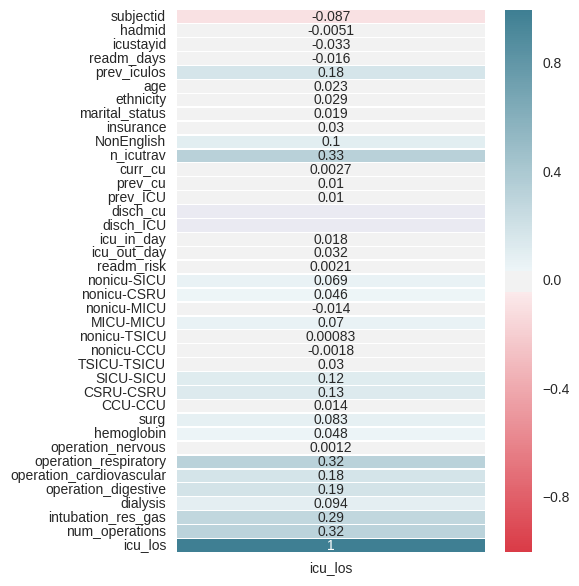

In [43]:
plt.figure(figsize=(5,7))
data_pcorr = df_icustay_f.corr()
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(data_pcorr[['icu_los']], annot=True, cmap = cmap, 
            linewidths=0.3)
plt.show()

# Predictive Modeling

In [44]:
import sys, os
src_abspath = os.path.abspath(os.path.join(os.path.split(os.getcwd())[0], 'src'))
sys.path.append(src_abspath)
from db import *
from clf import *

/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [45]:
am_debugging = True
if am_debugging:
    np.random.seed(2)
else:
    np.random.seed()

In [46]:
def lr_gridsearch(X_train, X_test, y_train):
    """
    Function determines the optimal parameters of the best classifier model/estimator by 
    performing a grid search. The best model will be fitted with the Training set and subsequently 
    used to predict the classification/labels of the Testing set. The function returns the 
    "best" classifier instance, classifier predictions, best parameters, and grid score.
    :param X_train: Training set features
    :param X_test: Testing set features
    :param y_train: Training set labels
    :return: tuple of (best classifier instance, clf predictions, dict of best params, grid score)
    """
    param_grid = [
        {'fit_intercept': [True, False], 'normalize': [True, False]}]

    # Blank clf instance
    blank_clf = LinearRegression()

    # Grid Search - Hyperparameters Optimization
    clf = grid_search.GridSearchCV(blank_clf, param_grid, n_jobs=-1)  # classifier + optimal params
    clf = clf.fit(X_train, y_train)  # fitted classifier
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)

    best_params = clf.best_params_  # best parameters identified by grid search
    score = clf.best_score_  # best grid score
    return (best_est, clf_pred, best_params, score)


def svr_gridsearch(X_train, X_test, y_train):
    """
    Function determines the optimal parameters of the best classifier model/estimator by performing a grid search.
    The best model will be fitted with the Training set and subsequently used to predict the classification/labels
    of the Testing set. The function returns the "best" classifier instance, classifier predictions, best parameters,
    and grid score.

    :param X_train: Training set features
    :param X_test: Testing set features
    :param y_train: Training set labels
    :return: tuple of (best classifier instance, clf predictions, dict of best parameters, grid score)
    """
    # Parameter Grid - dictionary of parameters (map parameter names to values to be searched)
    param_grid = [
        {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']},
        {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']}
#         {'C':[0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'degree': [2], 'kernel': ['poly']}
    ]

    
    # Blank clf instance
    blank_clf = SVR()

    # Grid Search - Hyperparameters Optimization
    clf = grid_search.GridSearchCV(blank_clf, param_grid, n_jobs=-1)  # classifier + optimal parameters
    clf = clf.fit(X_train, y_train)  # fitted classifier
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)

    best_params = clf.best_params_  # best parameters identified by grid search
    score = clf.best_score_  # best grid score
    return (best_est, clf_pred, best_params, score)


def rf_gridsearch(X_train, X_test, y_train):
    # Parameter Grid - dictionary of parameters (map parameter names to values to be searched)
    param_grid = [
        {'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
         'criterion': ['mse', 'mae']}
    ]

    rfr = RandomForestRegressor(random_state=2, n_jobs=-1)

    # Grid search to find "best" random forest classifier -- Hyperparameters Optimization
    clf = grid_search.GridSearchCV(rfr, param_grid)  # classifier + optimal parameters
    clf = clf.fit(X_train, y_train)  # fitted classifier -- Training Set
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)  # apply classifier on test set for label predictions
    params = clf.best_params_  # optimal parameters
    score = clf.best_score_  # best grid score
    imp = best_est.feature_importances_
    return (best_est, clf_pred, params, score, imp)


def gbr_gridsearch(X_train, X_test, y_train):
    # Parameter Grid - dictionary of parameters (map parameter names to values to be searched)
    param_grid = [
        {'loss': ['ls', 'lad', 'huber', 'quantile'], 'criterion': ['friedman_mse', 'mae', 'mse']}]
    
    # Blank clf instance
    blank_clf = GradientBoostingRegressor(random_state=2)

    # Grid Search - Hyperparameters Optimization
    clf = grid_search.GridSearchCV(blank_clf, param_grid, n_jobs=-1)  # classifier + optimal parameters
    clf = clf.fit(X_train, y_train)  # fitted classifier
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)

    best_params = clf.best_params_  # best parameters identified by grid search
    score = clf.best_score_  # best grid score
    return (best_est, clf_pred, best_params, score)

#### Partition: Training & Testing Sets

In [47]:
def data_partition(data, train_thres=0.75):
    """
    Helper function identifying indices for each record to be a part of the
    training set. The quantity of a given subject's set of records is determined
    by the training threshold.
    
    :param data: pandas DataFrame
    :param train_thres: float indicating threshold
    :return: list of training indices
    """
    if train_thres > 0.83:
        return "This helper function is not appropriate for training threshold > 83%."
    
    idx_lst = []
    subj_count = dict(Counter(data.subjectid))
    sid_lst = list(data.subjectid.value_counts().index.sort_values(ascending=True))
    for sid in sid_lst:
        idx_min = data['subjectid'][data.subjectid == sid].idxmin()
        if subj_count[sid] > 2:
            end_idx = idx_min + int(np.round(subj_count[sid] * train_thres))
            idx_lst += range(idx_min, end_idx)
        else:
            idx_lst += [idx_min]
    return idx_lst

In [48]:
data = df_icustay_f.copy().iloc[:3500,:]

train_idx = data_partition(data, 0.75)
train_data = data.ix[train_idx]
test_idx = data.index[data.index.isin(train_idx)==False]
test_data = data.ix[test_idx]

train_data.shape, test_data.shape

((2873, 39), (627, 39))

#### Drop Arbitrary Identifiers
Drop `subjectid`, `hadmid`, and `icustayid` that serve only for the purpose of identification.

In [49]:
train_data.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)
test_data.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)

In [50]:
X_train = train_data.iloc[:, :-1]
X_test = test_data.iloc[:, :-1]
y_train = np.array(train_data.iloc[:, -1])
y_test = np.array(test_data.iloc[:, -1])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2873, 35), (627, 35), (2873,), (627,))

#### Normalization

In [51]:
scaler = StandardScaler().fit(X_train) # scaler object fitted to training set

# Transform
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

# scaled_X_train, scaled_X_test = scale(X_train, X_test)
scaled_X_train.shape, scaled_X_test.shape, y_train.shape, y_test.shape

((2873, 35), (627, 35), (2873,), (627,))

## Feature Selection: Random Forest Feature Importances

In [73]:
rf_feats_dict = dict()
for i, feat in enumerate(train_data.columns):
    rf_feats_dict[feat] = i

In [101]:
# rf_imps list is in order of desceding highest feature importance
rf_imps = ['prev_iculos', 'readm_days', 'age', 'n_icutrav', 'num_operations', 'marital_status', 'ethnicity', 
           'insurance', 'operation_respiratory', 'intubation_res_gas', 'readm_risk', 'curr_cu', 
           'operation_digestive', 'dialysis',  'icu_in_day', 'nonicu-SICU', 'icu_out_day', 'nonicu-MICU', 
           'NonEnglish', 'nonicu-CCU', 'surg', 'operation_cardiovascular', 'nonicu-CSRU', 'operation_nervous', 
           'hemoglobin', 'SICU-SICU', 'CSRU-CSRU']

n_rf_feats = 20

rfselect_idx = []
for top_feats in rf_imps[:n_rf_feats]:
    rfselect_idx += [rf_feats_dict[top_feats]]

rfselect_idx.sort()
len(rfselect_idx)

20

In [102]:
select_X_train1 = scaled_X_train[:, rfselect_idx]
select_X_test1 = scaled_X_test[:, rfselect_idx]

select_X_train1.shape, select_X_test1.shape, y_train.shape, y_test.shape

((2873, 20), (627, 20), (2873,), (627,))

### Model: Linear Regression

In [103]:
lr_model, lr_pred, lr_p, lr_score = lr_gridsearch(select_X_train1, select_X_test1, y_train)
print "Best Parameters: ", lr_p
print "Best Grid Search Score: ", lr_score
print "Best Estimator: ", lr_model

Best Parameters:  {'normalize': True, 'fit_intercept': True}
Best Grid Search Score:  0.247186477573
Best Estimator:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


#### Compare Predictions

In [104]:
lr_pred[-10:]

array([ 11.04355714,   4.48668689,   2.61827375,   5.44538345,
        11.61811764,   8.37665916,  -0.37897627,   1.75728732,
        13.84136104,   2.14538352])

In [105]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

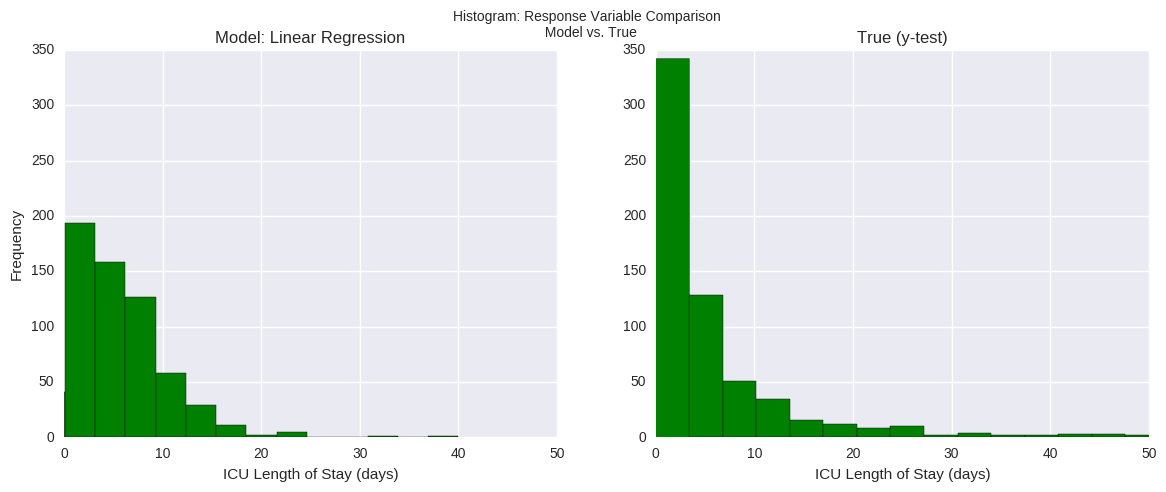

In [106]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred), bins=14, color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,350])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0,350])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [170]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, lr_pred))

RMSE = 8.089 days


In [171]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


The linear regression model has an RMSE value of 8.1 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [172]:
print " MAE = %.3f" % mean_absolute_error(y_test, lr_pred)

 MAE = 4.795


The average difference between prediction and observation is 4.8 days, which is low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [173]:
print "r2 = %.3f" % r2_score(y_test, lr_pred)

r2 = 0.263


The R<sup>2</sup> value is approximately 0.26, which indicates that the model does not have strong predictive power.

### Error Visualization (MAE)

In [1]:
df_lrpred = pd.Series(lr_pred, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_results = pd.concat([df_true, df_lrpred], axis=1)
residual = pd.Series(df_results['true'].sub(df_results['pred'], axis=0).abs(), name='resid')
df_results = pd.concat([df_results, residual], axis=1)
df_results

lr_errort = df_results[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

NameError: name 'pd' is not defined

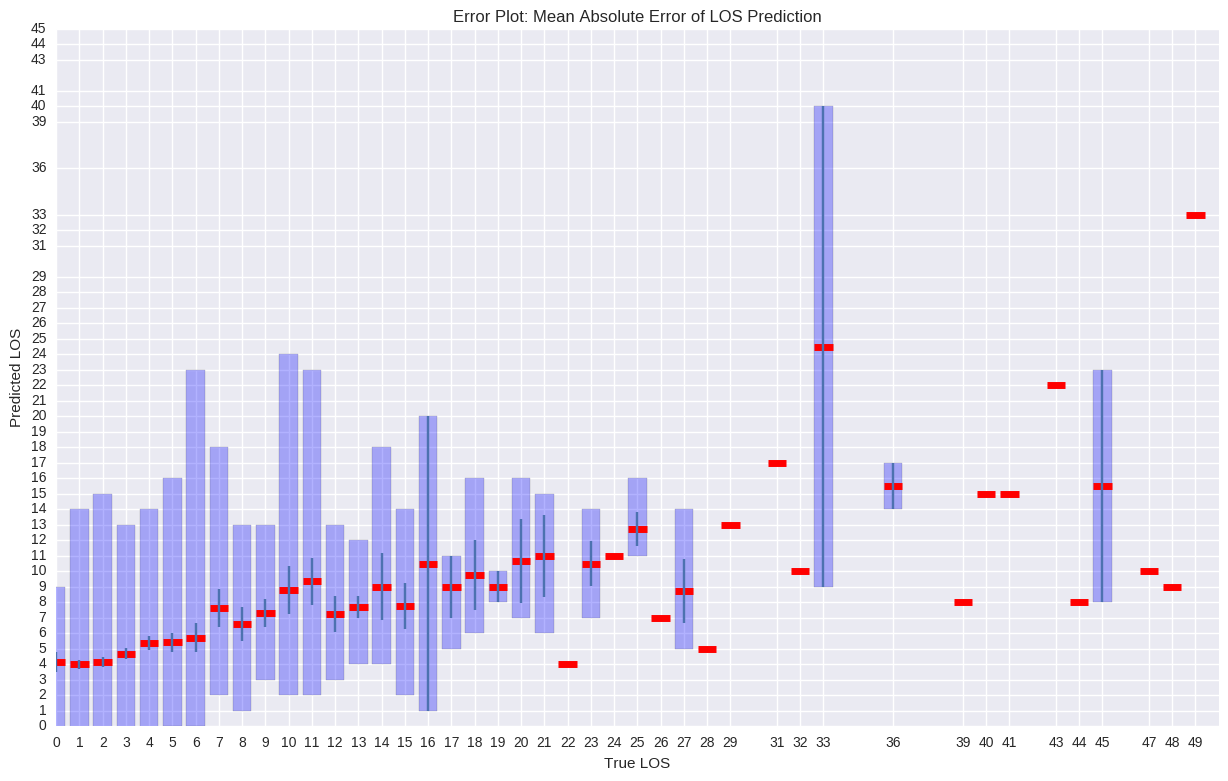

In [175]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in lr_errort.index.tolist()], 
        height=lr_errort[['pred']].values[:,3] - lr_errort[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=lr_errort[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in lr_errort.index.tolist()], 
        height=[0]*len(lr_errort), 
        width=0.8, 
        bottom=lr_errort[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=lr_errort[['pred']].values[:,2] / lr_errort[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(lr_errort.index)
plt.yticks(lr_errort.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,45])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Model: Support Vector Regression

In [152]:
svr_model, svr_pred, svr_p, svr_score = svr_gridsearch(select_X_train1, select_X_test1, y_train)
print "Best Parameters: ", svr_p
print "Best Grid Search Score: ", svr_score
print "Best Estimator: ", svr_model, "\n"

Best Parameters:  {'kernel': 'rbf', 'C': 100, 'gamma': 0.01}
Best Grid Search Score:  0.230735813034
Best Estimator:  SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 



#### Compare Predictions

In [154]:
svr_pred[-10:]

array([  5.84475467,   2.63402867,   4.17709994,   2.09545864,
         7.8802632 ,   6.71815037,   1.83364511,   2.54072752,
        12.97734814,   1.76217252])

In [155]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

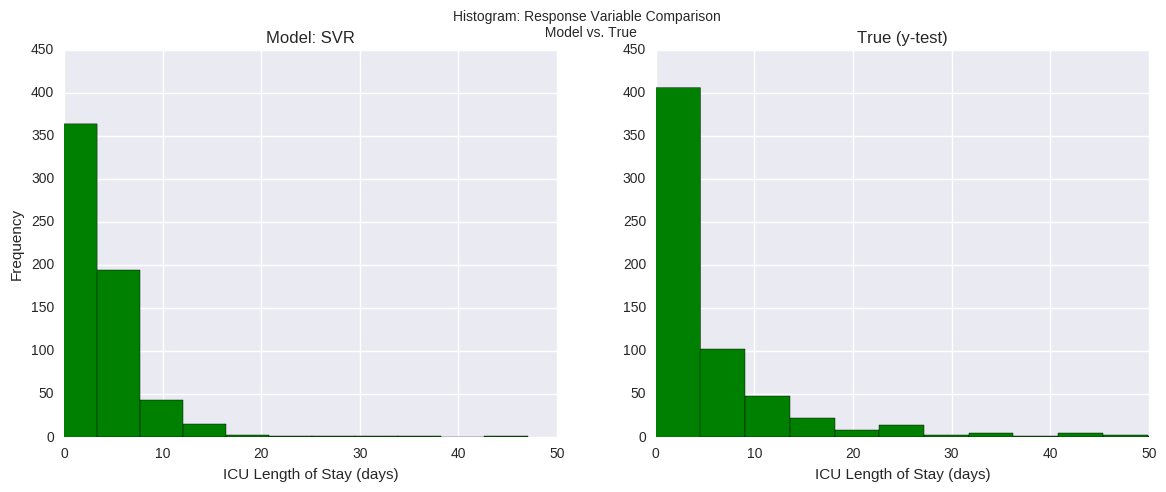

In [160]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred), bins=11, color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 450])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 450])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [163]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, svr_pred))

RMSE = 8.413 days


In [164]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


The SVR model has an RMSE value of 8.4 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [165]:
print " MAE = %.3f" % mean_absolute_error(y_test, svr_pred)

 MAE = 4.317


The average difference between prediction and observation is 4.3 days, which is low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [166]:
print "r2 = %.3f" % r2_score(y_test, svr_pred)

r2 = 0.203


The R<sup>2</sup> value is approximately 0.2, which is low and indicates that the model does not have strong predictive power.

### Error Visualization (MAE)

In [167]:
df_svrpred = pd.Series(svr_pred, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_svrresults = pd.concat([df_true, df_svrpred], axis=1)
svr_residual = pd.Series(df_svrresults['true'].sub(df_svrresults['pred'], axis=0).abs(), name='resid')
df_svrresults = pd.concat([df_svrresults, svr_residual], axis=1)
df_svrresults

svr_errort = df_svrresults[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

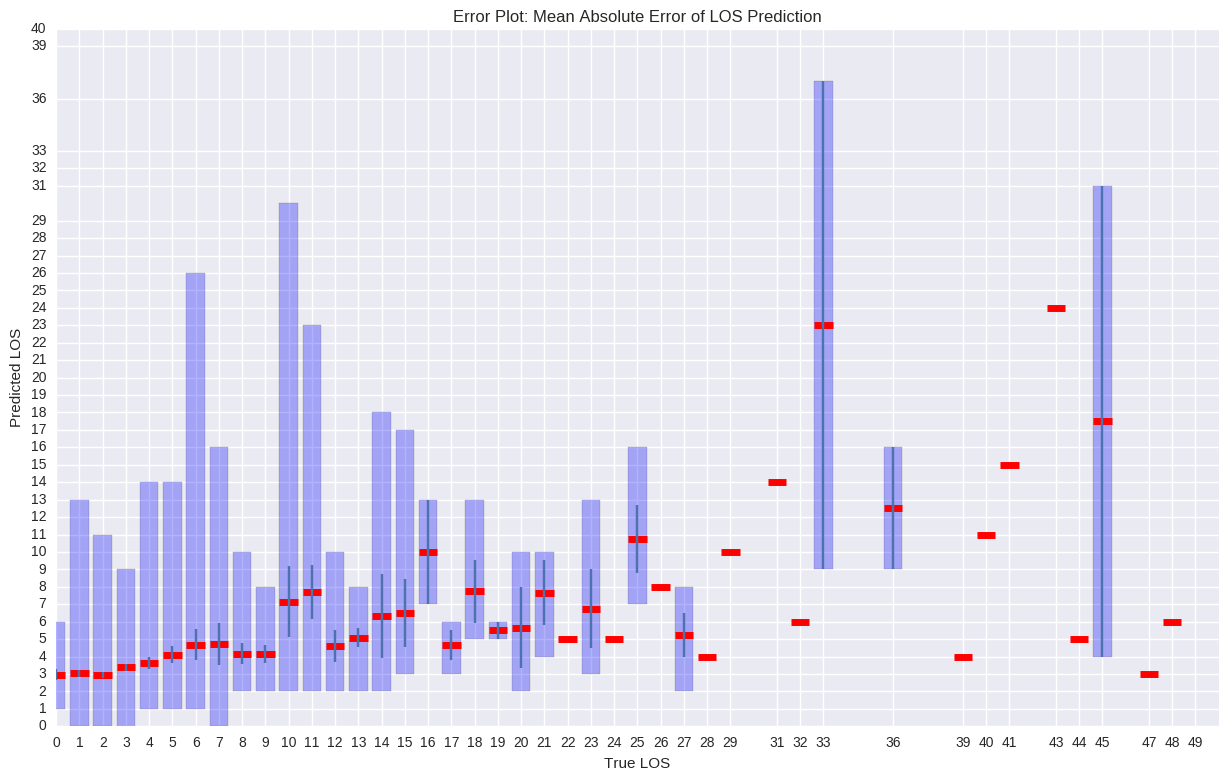

In [176]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in svr_errort.index.tolist()], 
        height=svr_errort[['pred']].values[:,3] - svr_errort[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=svr_errort[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in svr_errort.index.tolist()], 
        height=[0]*len(svr_errort), 
        width=0.8, 
        bottom=svr_errort[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=svr_errort[['pred']].values[:,2] / svr_errort[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(svr_errort.index)
plt.yticks(svr_errort.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: k-Nearest Neighbors

In [177]:
knn_model = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model.fit(select_X_train1, y_train) # fit model on training data
knn_pred = knn_model.predict(select_X_test1)

#### Compare Predictions

In [178]:
knn_pred[-10:]

array([  4.58968,   2.5759 ,   2.82756,   1.61086,   8.29018,  12.29754,
         2.6585 ,   2.11444,  14.60202,   3.72484])

In [179]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

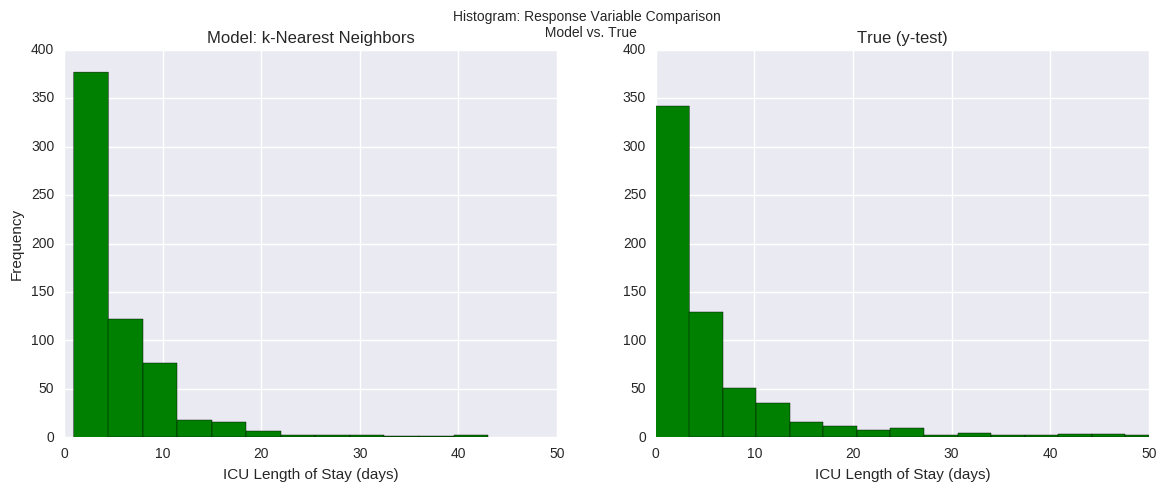

In [180]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred), bins=12, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [181]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, knn_pred))

RMSE = 8.611 days


In [182]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


The k-NN model has an RMSE value of 8.6 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [183]:
print " MAE = %.3f" % mean_absolute_error(y_test, knn_pred)

 MAE = 4.840


The average difference between prediction and observation is 4.8 days, which is relatively low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [184]:
print "r2 = %.3f" % r2_score(y_test, knn_pred)

r2 = 0.165


The k-NN model has very poor predictive power. This may be attributed to the fact that it's a "lazy learning" algorithm, *lacking generalization*. The model only does work (build a model) at the time of prediction and uses minimal, if any Training data.

### Error Visualization (MAE)

In [185]:
df_knnpred = pd.Series(knn_pred, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_knnresults = pd.concat([df_true, df_knnpred], axis=1)
knn_residual = pd.Series(df_knnresults['true'].sub(df_knnresults['pred'], axis=0).abs(), name='resid')
df_knnresults = pd.concat([df_knnresults, knn_residual], axis=1)
df_knnresults

knn_errort = df_knnresults[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

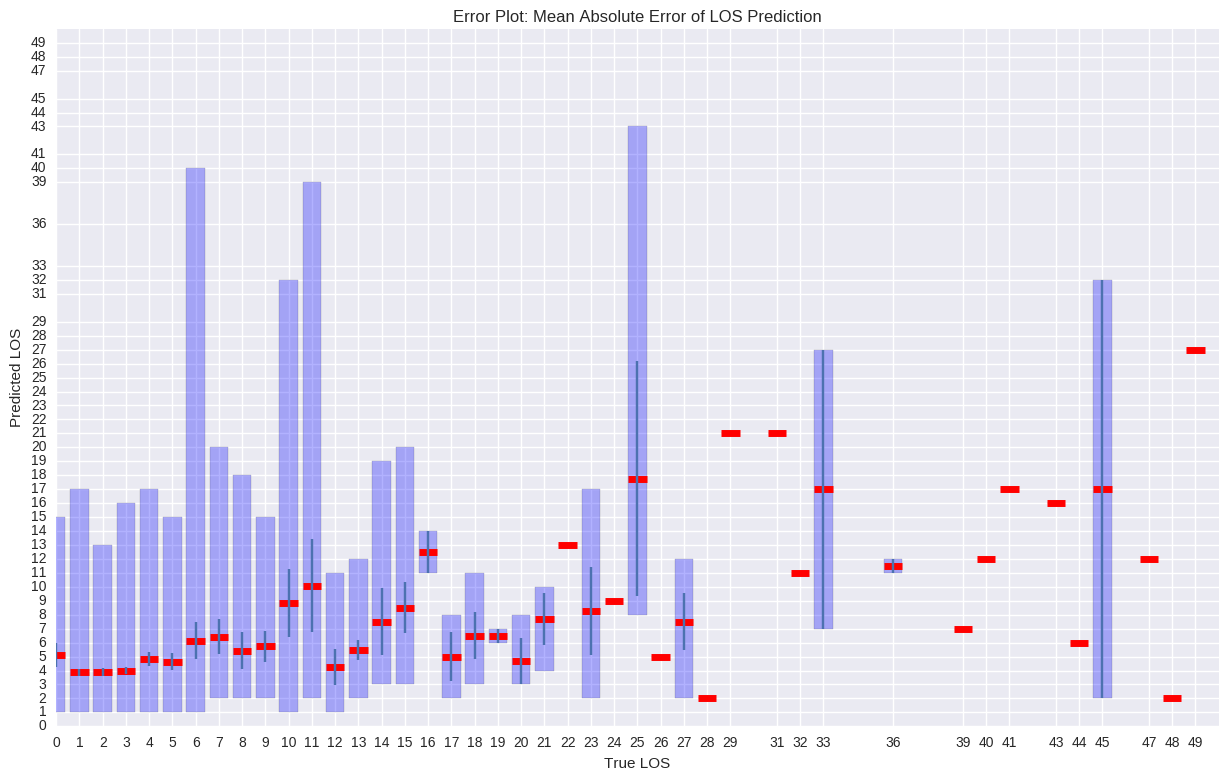

In [187]:
f,axes = plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in knn_errort.index.tolist()], 
        height=knn_errort[['pred']].values[:,3] - knn_errort[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=knn_errort[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in knn_errort.index.tolist()], 
        height=[0]*len(knn_errort), 
        width=0.8, 
        bottom=knn_errort[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=knn_errort[['pred']].values[:,2] / knn_errort[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(knn_errort.index)
plt.yticks(knn_errort.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,50])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [127]:
rf_model, rf_pred, rf_p, rf_score, rf_imp = rf_gridsearch(select_X_train1, select_X_test1, y_train)
print "Best Parameters: ", rf_p
print "Best Grid Search Score: ", rf_score
print "Best Estimator: ", rf_model

Best Parameters:  {'n_estimators': 9, 'criterion': 'mae'}
Best Grid Search Score:  0.154923665962
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=9, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


#### Compare Predictions

In [129]:
rf_pred[-10:]

array([ 10.37896667,   2.11663333,   3.15021111,  10.55128889,
        17.26103333,   4.52594444,   2.68371111,   3.20347778,
        11.3558    ,   2.8853    ])

In [130]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

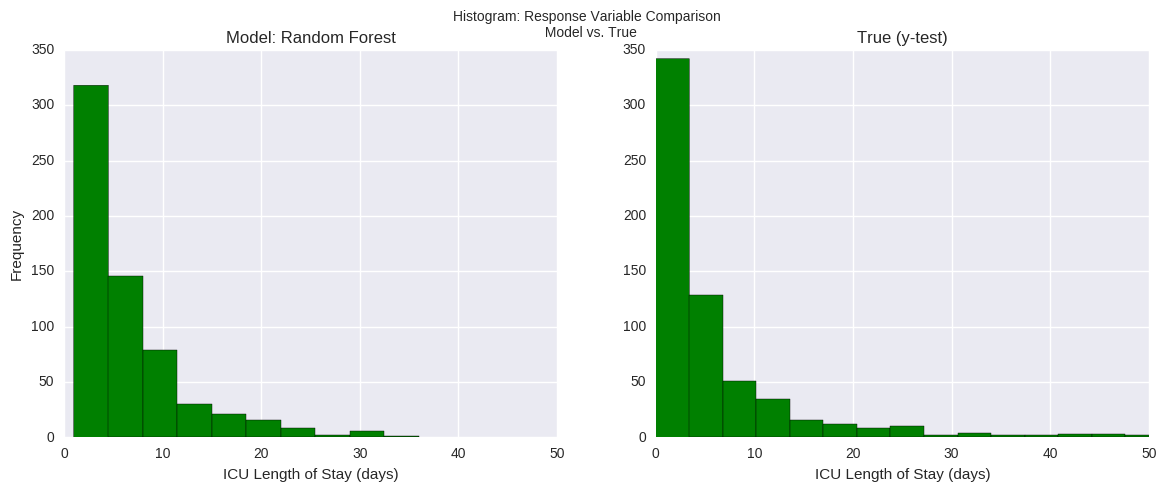

In [134]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred), bins=10, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 350])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 350])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [188]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, rf_pred))

RMSE = 8.774 days


In [189]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


The Random Forest regression model has an RMSE value of 8.3 days, which is relatively low compared to the response range.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [190]:
print " MAE = %.3f" % mean_absolute_error(y_test, rf_pred)

 MAE = 5.153


The average difference between prediction and observation is 2.5 days, which is relatively low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [191]:
print "r2 = %.3f" % r2_score(y_test, rf_pred)

r2 = 0.133


The Random Forest model has poor predictive power.

### Error Visualization (MAE)

In [139]:
df_rfpred = pd.Series(rf_pred, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_rfresults = pd.concat([df_true, df_rfpred], axis=1)
rf_residual = pd.Series(df_rfresults['true'].sub(df_rfresults['pred'], axis=0).abs(), name='resid')
df_rfresults = pd.concat([df_rfresults, rf_residual], axis=1)
df_rfresults

rf_errort = df_rfresults[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

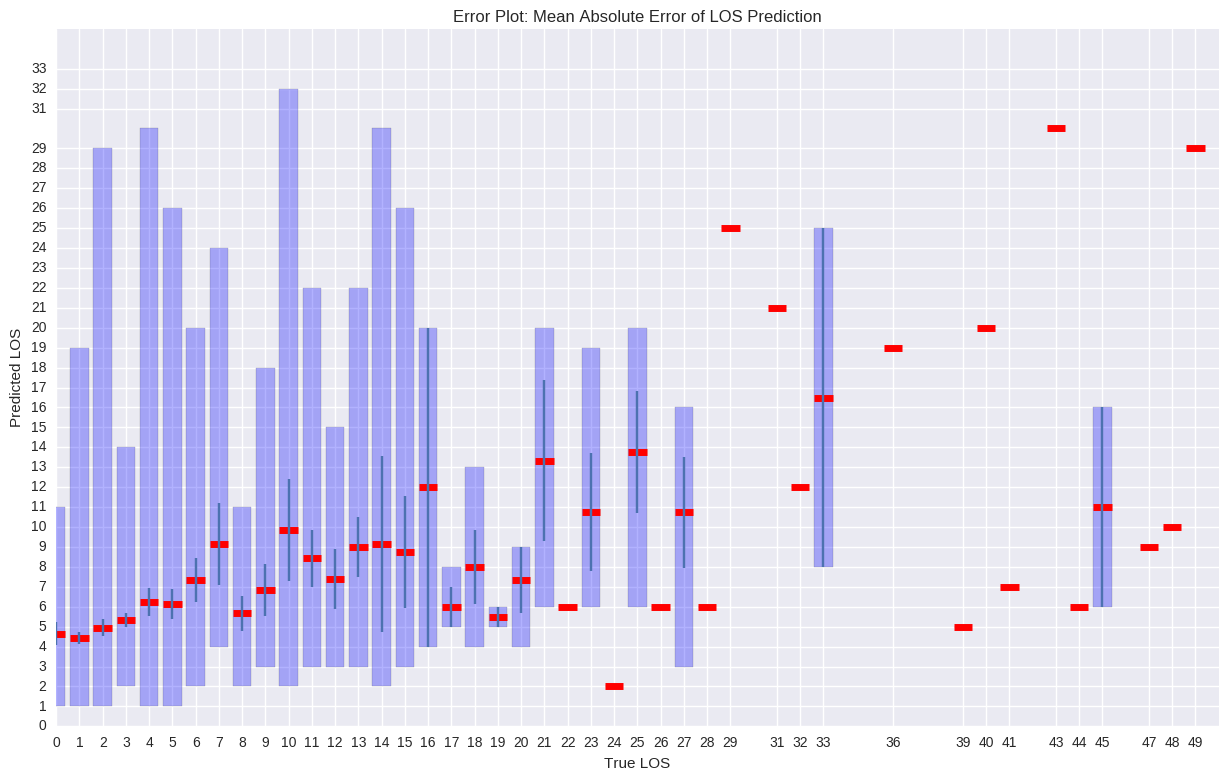

In [192]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in rf_errort.index.tolist()], 
        height=rf_errort[['pred']].values[:,3] - rf_errort[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=rf_errort[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in rf_errort.index.tolist()], 
        height=[0]*len(rf_errort), 
        width=0.8, 
        bottom=rf_errort[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort[['pred']].values[:,2] / rf_errort[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(rf_errort.index)
plt.yticks(rf_errort.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,35])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: Gradient Boosting Regressor

In [141]:
gbr_model, gbr_pred, gbr_p, gbr_score = gbr_gridsearch(select_X_train1, select_X_test1, y_train)
print "Best Parameters: ", gbr_p
print "Best Grid Search Score: ", gbr_score
print "Best Estimator: ", gbr_model

Best Parameters:  {'loss': 'lad', 'criterion': 'friedman_mse'}
Best Grid Search Score:  0.175555484512
Best Estimator:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=2, subsample=1.0, verbose=0,
             warm_start=False)


#### Compare Predictions

In [142]:
gbr_pred[-10:]

array([ 4.107742  ,  3.33969745,  2.77153042,  4.56885657,  6.60137294,
        4.32743084,  1.99694537,  2.4133906 ,  8.79700944,  2.55879459])

In [143]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

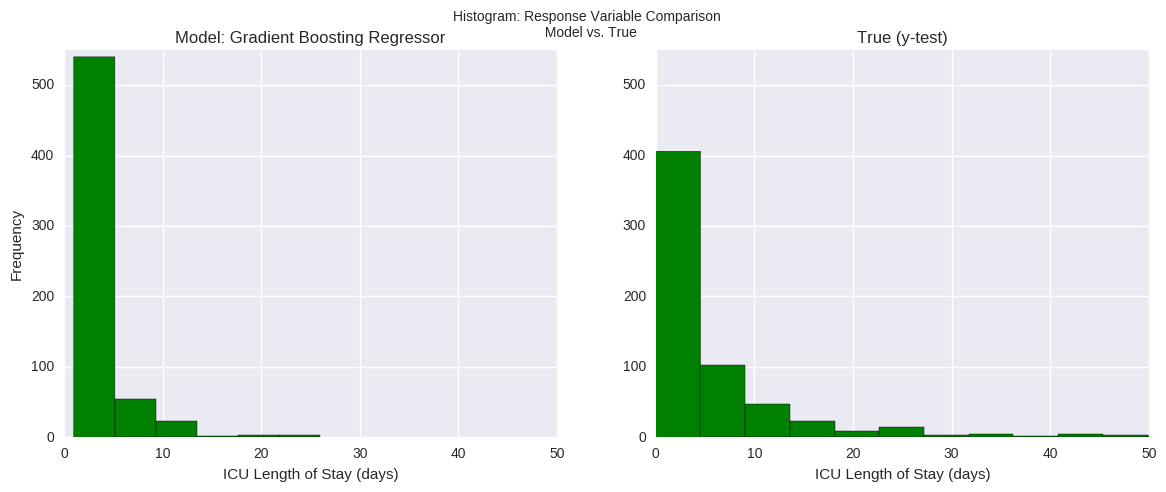

In [200]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(gbr_pred), bins=6, color='g')
plt.title("Model: Gradient Boosting Regressor")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [201]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, gbr_pred))

RMSE = 8.561 days


In [202]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


The SVR model has an RMSE value of 8.6 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [203]:
print " MAE = %.3f" % mean_absolute_error(y_test, gbr_pred)

 MAE = 4.205


The average difference between prediction and observation is 4.2 days, which is low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [204]:
print "r2 = %.3f" % r2_score(y_test, gbr_pred)

r2 = 0.175


The R<sup>2</sup> value is approximately 0.18, which is low and indicates that the model does not have strong predictive power.

### Error Visualization (MAE)

In [149]:
df_gbrpred = pd.Series(gbr_pred, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_gbrresults = pd.concat([df_true, df_gbrpred], axis=1)
gbr_residual = pd.Series(df_gbrresults['true'].sub(df_gbrresults['pred'], axis=0).abs(), name='resid')
df_gbrresults = pd.concat([df_gbrresults, gbr_residual], axis=1)
df_gbrresults

gbr_errort = df_gbrresults[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

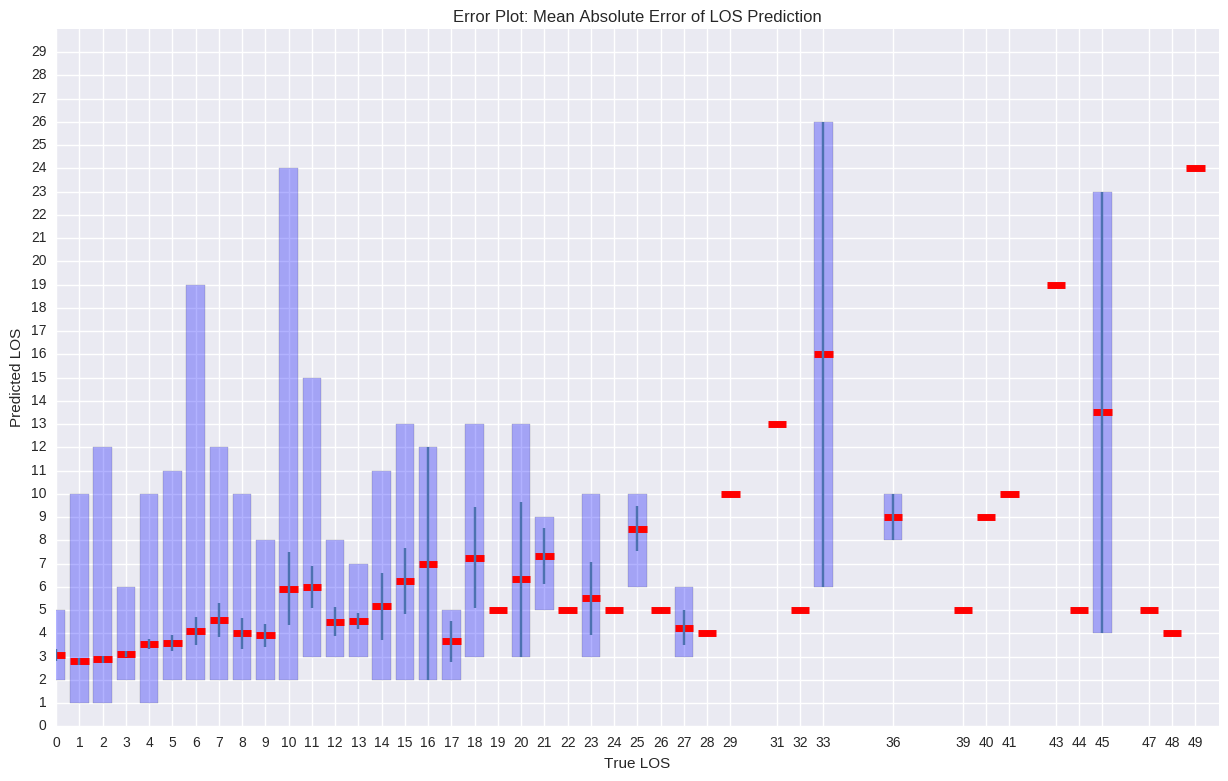

In [205]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in gbr_errort.index.tolist()], 
        height=gbr_errort[['pred']].values[:,3] - gbr_errort[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=gbr_errort[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in gbr_errort.index.tolist()], 
        height=[0]*len(gbr_errort), 
        width=0.8, 
        bottom=gbr_errort[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=gbr_errort[['pred']].values[:,2] / gbr_errort[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(gbr_errort.index)
plt.yticks(gbr_errort.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,30])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Feature Selection: Univariate (F-Regression)

In [56]:
score_func = SelectKBest(f_regression, k=20).fit(scaled_X_train, y_train) #k = # features
select_X_train2 = score_func.transform(scaled_X_train)
select_X_test2 = score_func.transform(scaled_X_test)

# Score Function Attributes
scores =  score_func.scores_
pvals = score_func.pvalues_

select_X_train2.shape, select_X_test2.shape, y_train.shape, y_test.shape

((2873, 20), (627, 20), (2873,), (627,))

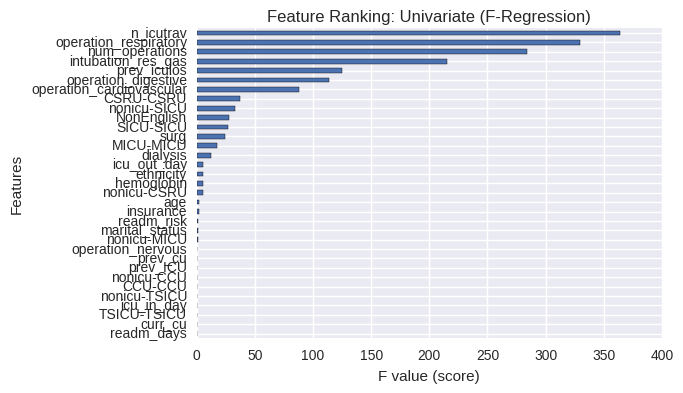

In [57]:
feat_names = list(train_data.columns)[:-1]

fselect_score = pd.concat([pd.Series(feat_names, name='name'), 
                           pd.Series(scores, name='score'),
                           pd.Series(pvals, name='pval')],
                              axis=1)

feat_select = fselect_score.sort_values('score', ascending=True)
feat_select.index=feat_select.name
feat_select.dropna(inplace=True)
feat_select['score'].plot(kind='barh')
plt.xlabel('F value (score)')
plt.ylabel('Features')
plt.title('Feature Ranking: Univariate (F-Regression)')
plt.show()

### Model: Linear Regression

In [88]:
lr_model2, lr_pred2, lr_p2, lr_score2 = lr_gridsearch(select_X_train2, select_X_test2, y_train)
print "Best Parameters: ", lr_p2
print "Best Grid Search Score: ", lr_score2
print "Best Estimator: ", lr_model2

Best Parameters:  {'normalize': True, 'fit_intercept': True}
Best Grid Search Score:  0.230689562178
Best Estimator:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


#### Compare Predictions

In [179]:
lr_pred2[-10:]

array([ 12.63325224,   4.87989786,   2.37914484,   7.85465935,
        12.90989159,   7.30906067,   0.26339239,   3.00268592,
        12.63265123,   2.89004266])

In [180]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

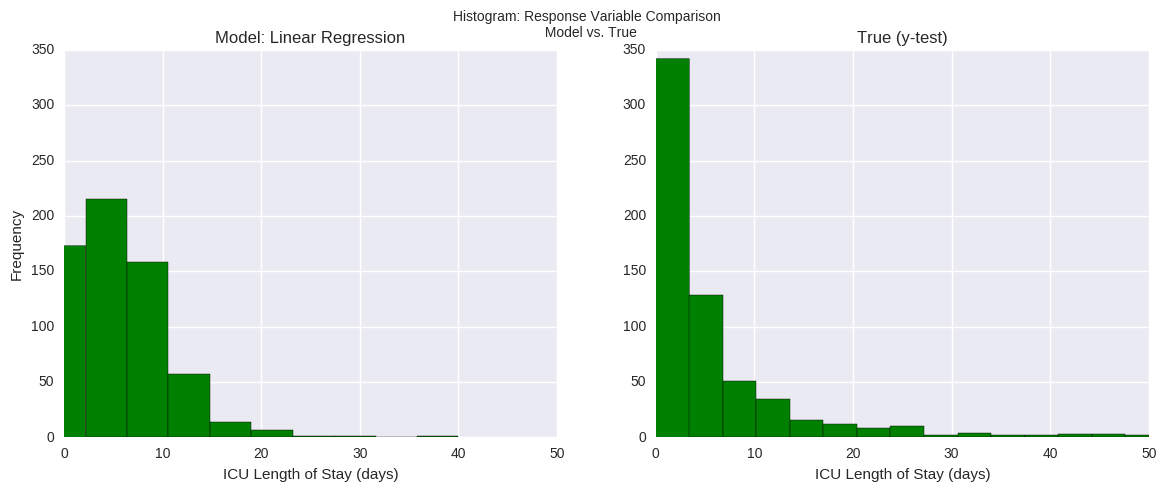

In [182]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred2), bins=10, color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,350])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0,350])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [183]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, lr_pred2))

RMSE = 8.077 days


In [184]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [185]:
print " MAE = %.3f" % mean_absolute_error(y_test, lr_pred2)

 MAE = 4.858


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [186]:
print "r2 = %.3f" % r2_score(y_test, lr_pred2)

r2 = 0.265


### Error Visualization (MAE)

In [187]:
df_lrpred2 = pd.Series(lr_pred2, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_results2 = pd.concat([df_true, df_lrpred2], axis=1)
residual2 = pd.Series(df_results2['true'].sub(df_results2['pred'], axis=0).abs(), name='resid')
df_results2 = pd.concat([df_results2, residual2], axis=1)
df_results2

lr_errort2 = df_results2[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

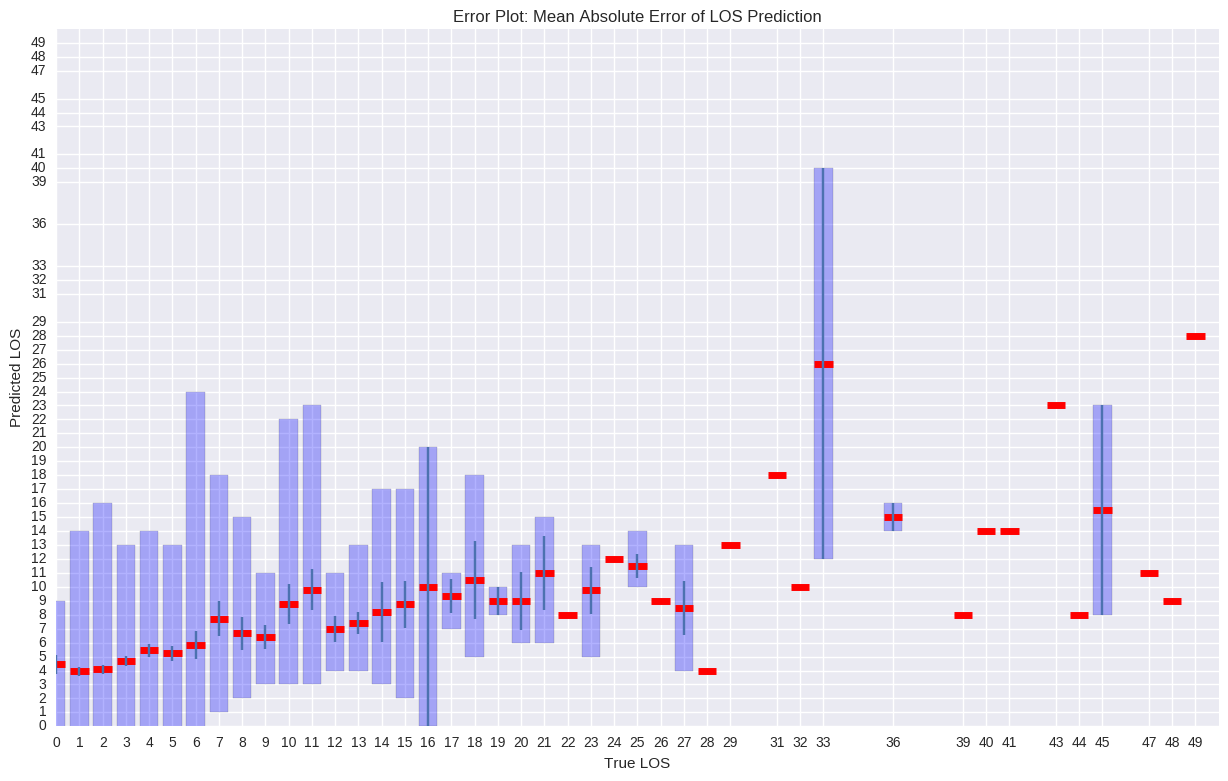

In [188]:
f,axes = plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in lr_errort2.index.tolist()], 
        height=lr_errort2[['pred']].values[:,3] - lr_errort2[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=lr_errort2[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in lr_errort2.index.tolist()], 
        height=[0]*len(lr_errort2), 
        width=0.8, 
        bottom=lr_errort2[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=lr_errort2[['pred']].values[:,2] / lr_errort2[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(lr_errort2.index)
plt.yticks(lr_errort2.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,50])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: Support Vector Regression

In [90]:
svr_model2, svr_pred2, svr_p2, svr_score2 = svr_gridsearch(select_X_train2, select_X_test2, y_train)
print "Best Parameters: ", svr_p2
print "Best Grid Search Score: ", svr_score2
print "Best Estimator: ", svr_model2

Best Parameters:  {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
Best Grid Search Score:  0.21513816355
Best Estimator:  SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


#### Compare Predictions

In [91]:
svr_pred2[-10:]

array([  4.86179213,   2.0729497 ,   2.18732913,   8.06145748,
        12.73565715,   5.34660654,   2.30557796,   2.67107713,
         8.97494676,   2.08752052])

In [92]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

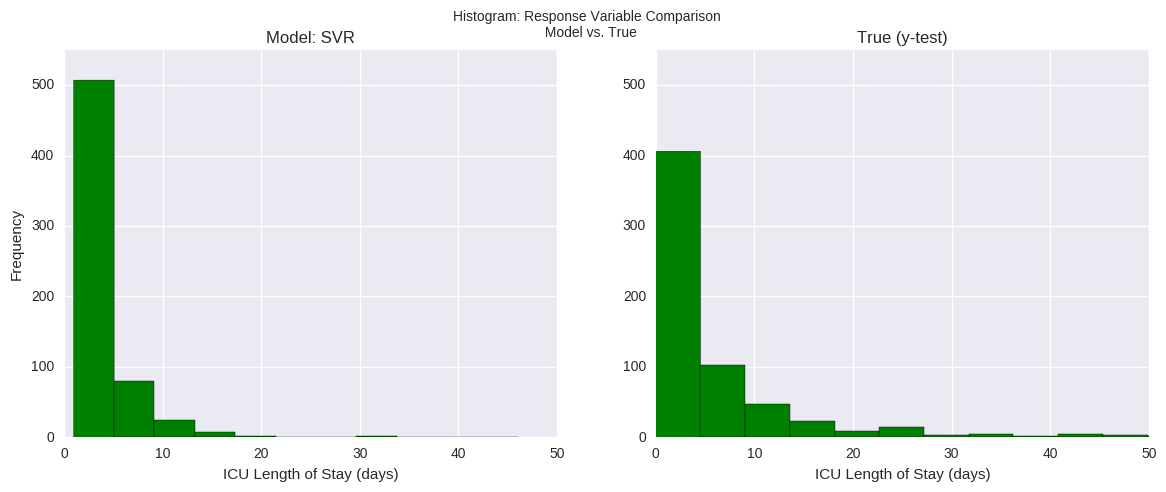

In [93]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred2), bins=11, color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [96]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, svr_pred2))

RMSE = 8.283 days


In [97]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [98]:
print " MAE = %.3f" % mean_absolute_error(y_test, svr_pred2)

 MAE = 4.230


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [99]:
print "r2 = %.3f" % r2_score(y_test, svr_pred2)

r2 = 0.227


### Error Visualization (MAE)

In [100]:
df_svrpred2 = pd.Series(svr_pred2, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_svrresults2 = pd.concat([df_true, df_svrpred2], axis=1)
svr_residual2 = pd.Series(df_svrresults2['true'].sub(df_svrresults2['pred'], axis=0).abs(), name='resid')
df_svrresults2 = pd.concat([df_svrresults2, svr_residual2], axis=1)

svr_errort2 = df_svrresults2[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

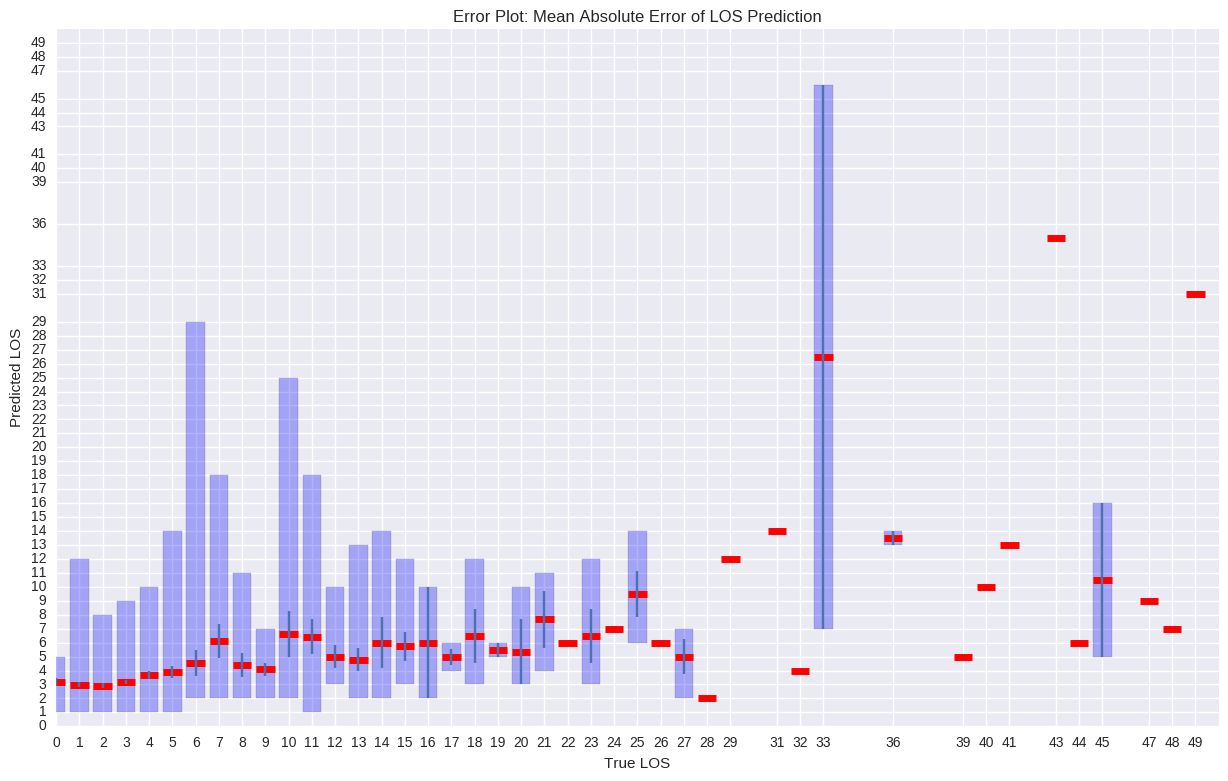

In [101]:
f,axes = plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in svr_errort2.index.tolist()], 
        height=svr_errort2[['pred']].values[:,3] - svr_errort2[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=svr_errort2[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in svr_errort2.index.tolist()], 
        height=[0]*len(svr_errort2), 
        width=0.8, 
        bottom=svr_errort2[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=svr_errort2[['pred']].values[:,2] / svr_errort2[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(svr_errort2.index)
plt.yticks(svr_errort2.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,50])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: k-Nearest Neighbors

In [87]:
knn_model2 = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model2.fit(select_X_train2, y_train) # fit model on training data
knn_pred2 = knn_model2.predict(select_X_test2)

#### Compare Predictions

In [190]:
knn_pred2[-10:]

array([  8.04912,   2.36602,   3.90338,   5.91578,  13.74294,   9.27914,
         3.53006,   2.0639 ,   7.95868,   2.96184])

In [191]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

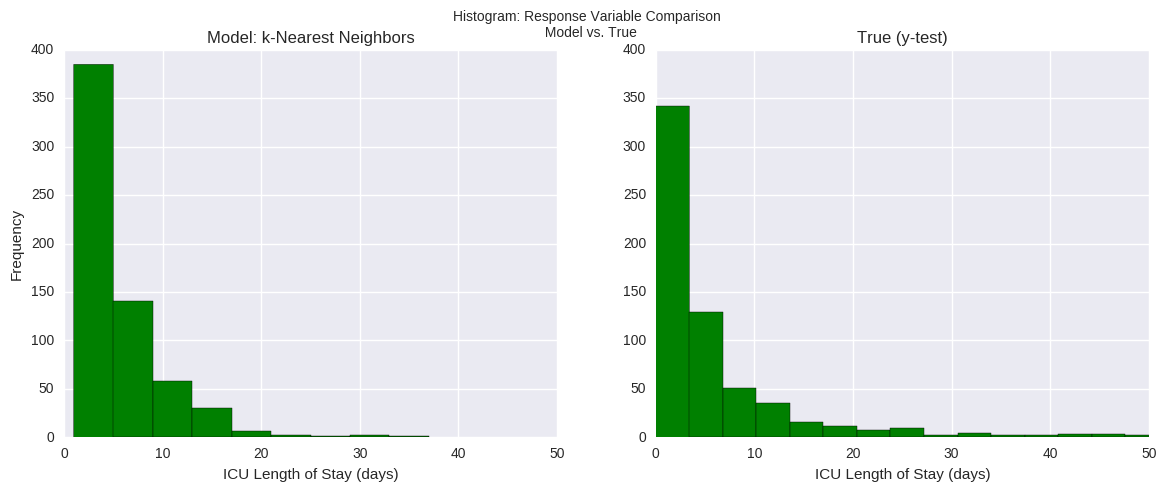

In [192]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred2), bins=9, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [194]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, knn_pred2))

RMSE = 8.545 days


In [195]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [196]:
print " MAE = %.3f" % mean_absolute_error(y_test, knn_pred2)

 MAE = 4.788


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [197]:
print "r2 = %.3f" % r2_score(y_test, knn_pred2)

r2 = 0.178


The k-NN model has very poor predictive power. This may be attributed to the fact that it's a "lazy learning" algorithm, *lacking generalization*. The model only does work (build a model) at the time of prediction and uses minimal, if any Training data.

### Error Visualization (MAE)

In [198]:
df_knnpred2 = pd.Series(knn_pred2, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_knnresults2 = pd.concat([df_true, df_knnpred2], axis=1)
knn_residual2 = pd.Series(df_knnresults2['true'].sub(df_knnresults2['pred'], axis=0).abs(), name='resid')
df_knnresults2 = pd.concat([df_knnresults2, knn_residual2], axis=1)

knn_errort2 = df_knnresults2[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

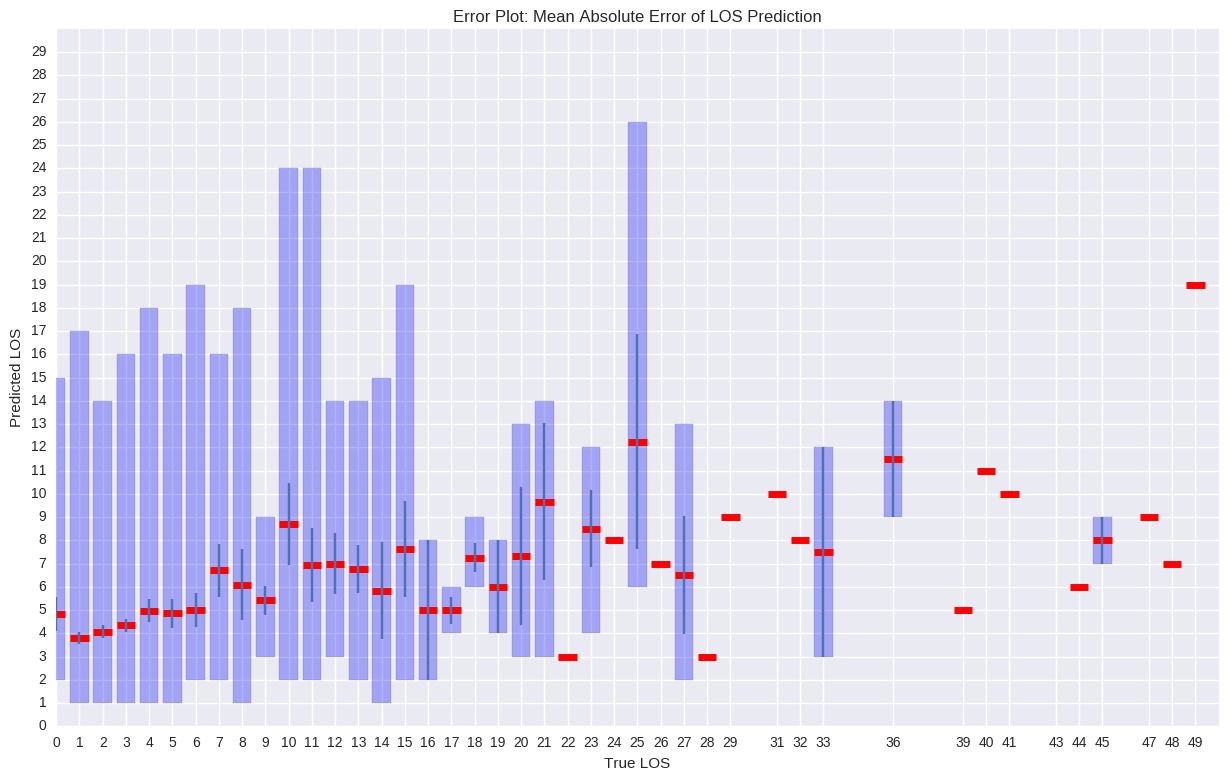

In [199]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in knn_errort2.index.tolist()], 
        height=knn_errort2[['pred']].values[:,3] - knn_errort2[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=knn_errort2[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in knn_errort2.index.tolist()], 
        height=[0]*len(knn_errort2), 
        width=0.8, 
        bottom=knn_errort2[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=knn_errort2[['pred']].values[:,2] / knn_errort2[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(knn_errort2.index)
plt.yticks(knn_errort2.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,30])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [58]:
rf_model2, rf_pred2, rf_p2, rf_score2, rf_imp2 = rf_gridsearch(select_X_train2, select_X_test2, y_train)
print "Best Parameters: ", rf_p2
print "Best Grid Search Score: ", rf_score2
print "Best Estimator: ", rf_model2

Best Parameters:  {'n_estimators': 6, 'criterion': 'mse'}
Best Grid Search Score:  0.138253937606
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=6, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


#### Compare Predictions

In [59]:
rf_pred2[-10:]

array([  9.21108333,   3.54471667,   3.14116667,   3.44355   ,
         9.81846667,  18.5227    ,   1.96891667,   3.7478    ,
        11.10895   ,   2.35481667])

In [60]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

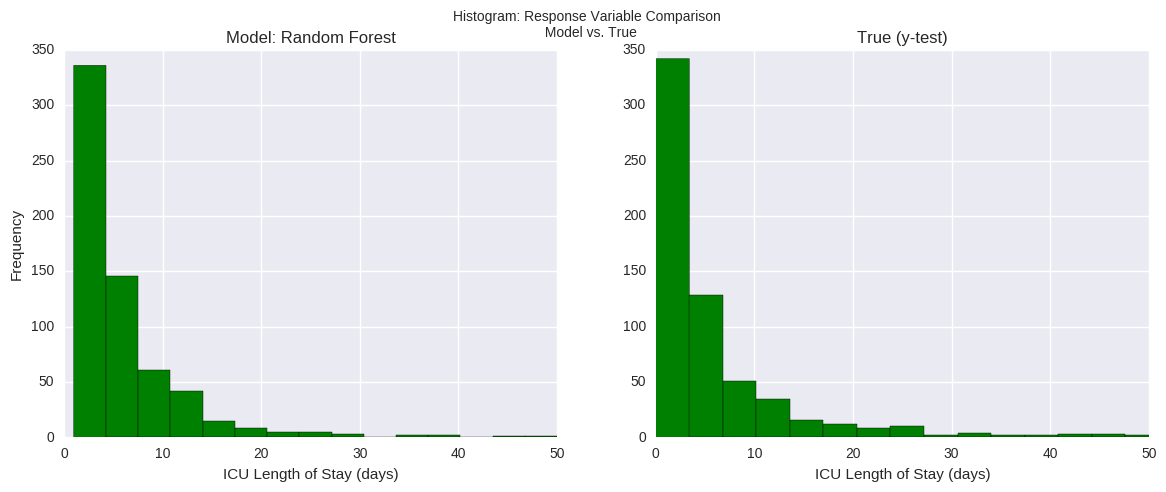

In [68]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred2), bins=15, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 350])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 350])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [62]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, rf_pred2))

RMSE = 8.934 days


In [63]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [64]:
print " MAE = %.3f" % mean_absolute_error(y_test, rf_pred2)

 MAE = 5.071


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [65]:
print "r2 = %.3f" % r2_score(y_test, rf_pred2)

r2 = 0.101


### Error Visualization (MAE)

In [69]:
df_rfpred2 = pd.Series(rf_pred2, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_rfresults2 = pd.concat([df_true, df_rfpred2], axis=1)
rf_residual2 = pd.Series(df_rfresults2['true'].sub(df_rfresults2['pred'], axis=0).abs(), name='resid')
df_rfresults2 = pd.concat([df_rfresults2, rf_residual2], axis=1)
df_rfresults2

rf_errort2 = df_rfresults2[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

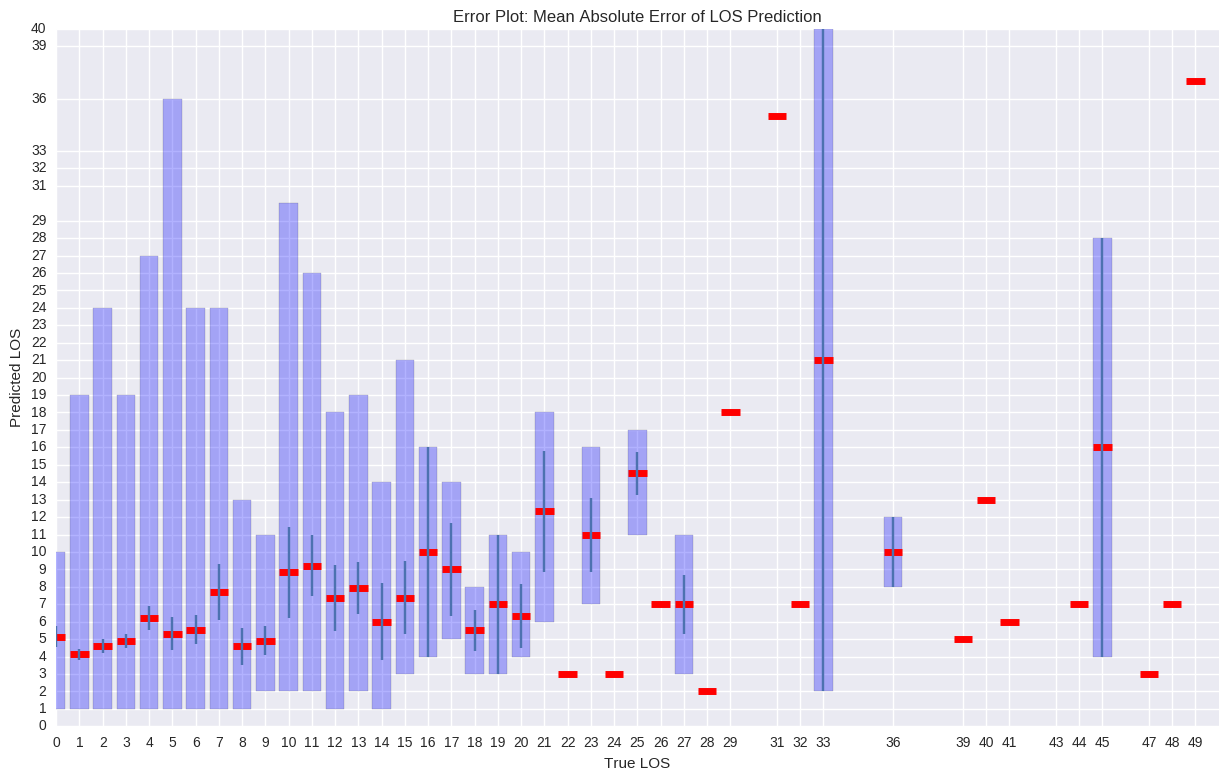

In [70]:
f,axes = plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in rf_errort2.index.tolist()], 
        height=rf_errort2[['pred']].values[:,3] - rf_errort2[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=rf_errort2[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in rf_errort2.index.tolist()], 
        height=[0]*len(rf_errort2), 
        width=0.8, 
        bottom=rf_errort2[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort2[['pred']].values[:,2] / rf_errort2[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(rf_errort2.index)
plt.yticks(rf_errort2.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: Gradient Boosting Regressor

In [72]:
gbr_model2, gbr_pred2, gbr_p2, gbr_score2 = gbr_gridsearch(select_X_train2, select_X_test2, y_train)
print "Best Parameters: ", gbr_p2
print "Best Grid Search Score: ", gbr_score2
print "Best Estimator: ", gbr_model2

Best Parameters:  {'loss': 'huber', 'criterion': 'mae'}
Best Grid Search Score:  0.1999915015
Best Estimator:  GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=2,
             subsample=1.0, verbose=0, warm_start=False)


#### Compare Predictions

In [73]:
gbr_pred2[-10:]

array([ 5.83044715,  3.61454074,  3.58829394,  4.78429394,  6.23976348,
        4.32418838,  2.85932893,  3.4021747 ,  8.82995617,  3.34368216])

In [74]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

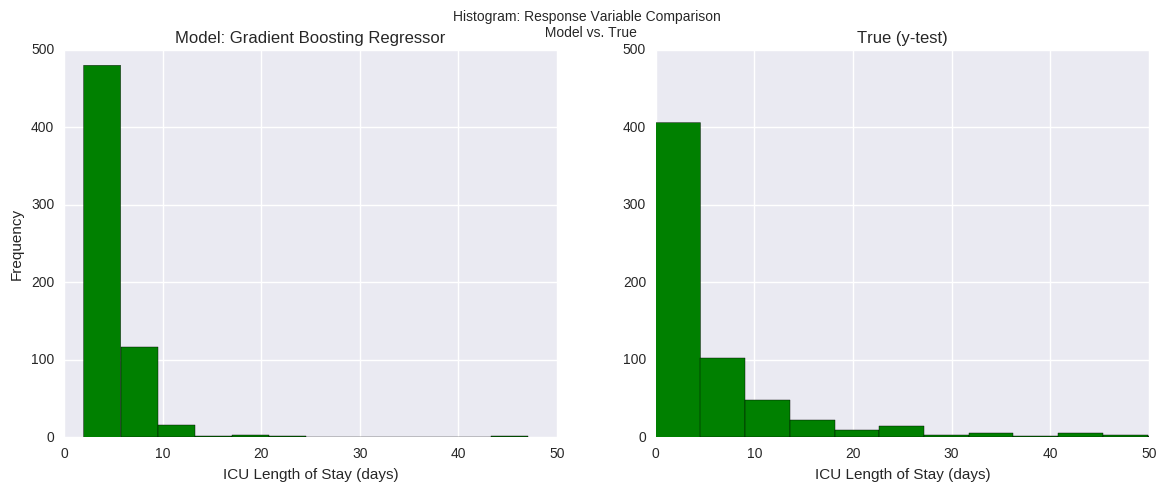

In [75]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(gbr_pred2), bins=12, color='g')
plt.title("Model: Gradient Boosting Regressor")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 500])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 500])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [78]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, gbr_pred2))

RMSE = 8.308 days


In [79]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


The Gradient Boosting model has an RMSE value of 8.3 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [80]:
print " MAE = %.3f" % mean_absolute_error(y_test, gbr_pred2)

 MAE = 4.244


The average difference between prediction and observation is 4.2 days, which is low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [82]:
print "r2 = %.3f" % r2_score(y_test, gbr_pred2)

r2 = 0.223


The R<sup>2</sup> value is approximately 0.2, which is low and indicates that the model does not have strong predictive power.

### Error Visualization (MAE)

In [85]:
df_gbrpred2 = pd.Series(gbr_pred2, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_gbrresults2 = pd.concat([df_true, df_gbrpred2], axis=1)
gbr_residual2 = pd.Series(df_gbrresults2['true'].sub(df_gbrresults2['pred'], axis=0).abs(), name='resid')
df_gbrresults2 = pd.concat([df_gbrresults2, gbr_residual2], axis=1)

gbr_errort2 = df_gbrresults2[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

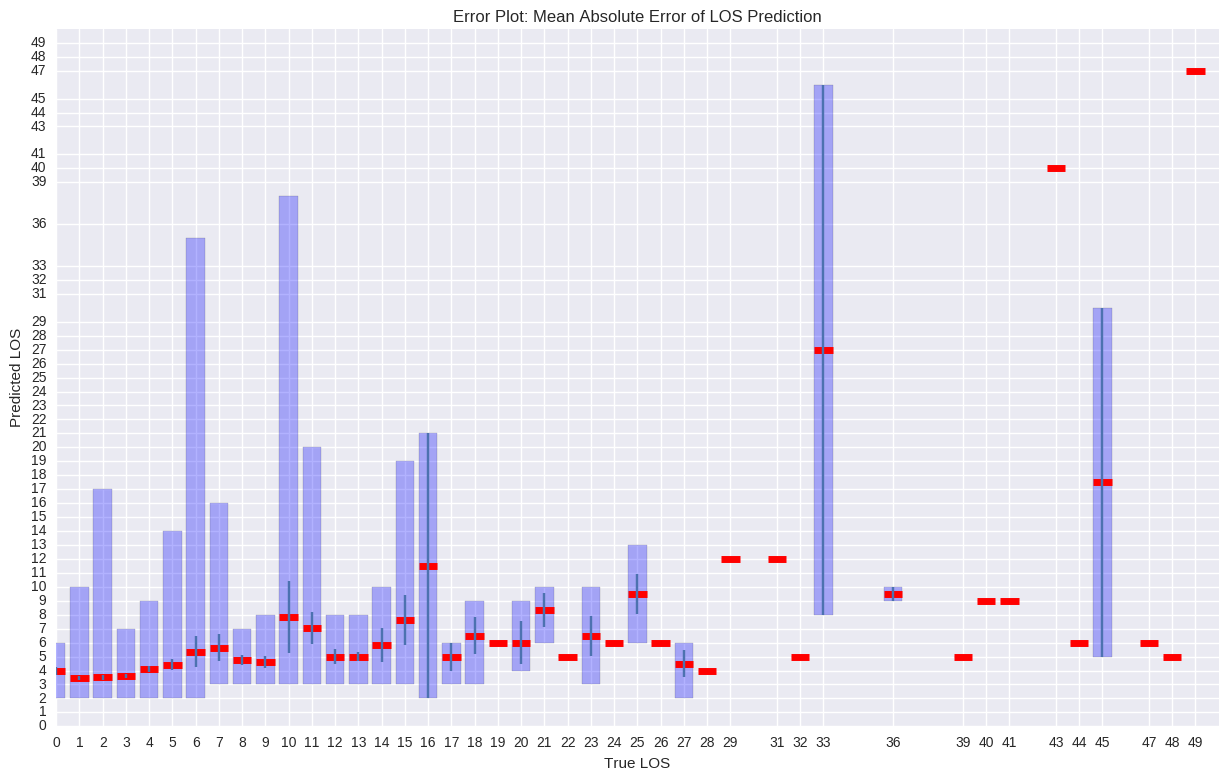

In [86]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in gbr_errort2.index.tolist()], 
        height=gbr_errort2[['pred']].values[:,3] - gbr_errort2[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=gbr_errort2[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in gbr_errort2.index.tolist()], 
        height=[0]*len(gbr_errort2), 
        width=0.8, 
        bottom=gbr_errort2[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=gbr_errort2[['pred']].values[:,2] / gbr_errort2[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(gbr_errort2.index)
plt.yticks(gbr_errort2.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,50])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Feature Selection: Random Selection

In [78]:
n_rand_feats = 20

total_feat_len = scaled_X_train.shape[1]

np.random.seed(2)
rand_select_idx = np.random.choice(np.arange(total_feat_len), size = n_rand_feats, replace=False)
rand_select_idx.sort()
len(rand_select_idx)

20

In [79]:
select_X_train3 = scaled_X_train[:, rand_select_idx]
select_X_test3 = scaled_X_test[:, rand_select_idx]

select_X_train3.shape, select_X_test3.shape, y_train.shape, y_test.shape

((2873, 20), (627, 20), (2873,), (627,))

### Model: Linear Regression

In [80]:
lr_model3, lr_pred3, lr_p3, lr_score3 = lr_gridsearch(select_X_train3, select_X_test3, y_train)
print "Best Parameters: ", lr_p3
print "Best Grid Search Score: ", lr_score3
print "Best Estimator: ", lr_model3

Best Parameters:  {'normalize': True, 'fit_intercept': True}
Best Grid Search Score:  0.0794077580172
Best Estimator:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


#### Compare Predictions

In [81]:
lr_pred3[-10:]

array([ 11.9928317 ,   6.77766683,   3.8491406 ,   4.0188584 ,
        10.93239866,   8.78229442,   3.19086036,   5.25589312,
         2.0787484 ,   2.92213644])

In [82]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

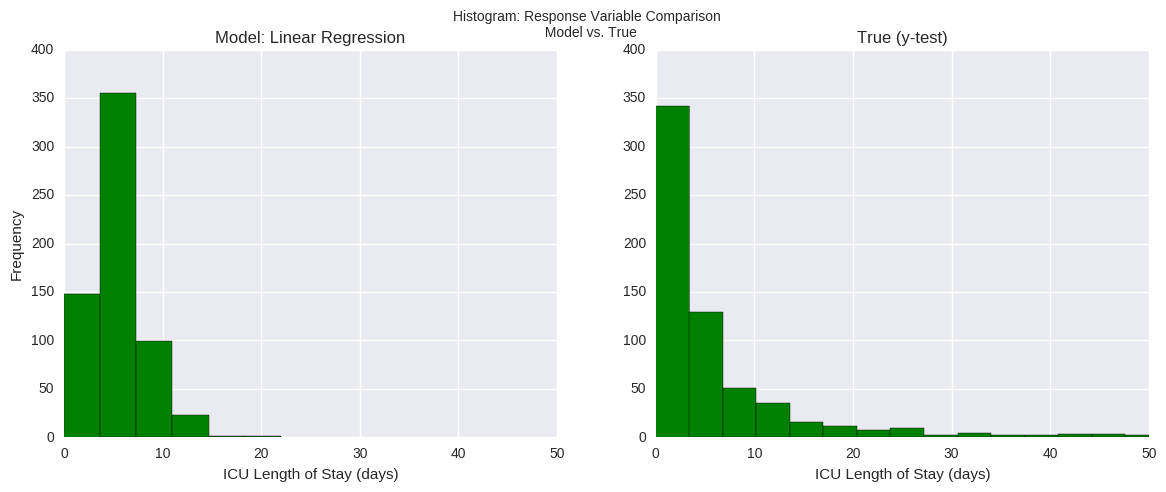

In [90]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred3), bins=6, color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0,400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [91]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, lr_pred3))

RMSE = 9.010 days


In [92]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


The linear regression model has an RMSE value of 9 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [93]:
print " MAE = %.3f" % mean_absolute_error(y_test, lr_pred3)

 MAE = 5.036


The average difference between prediction and observation is 5 days, which is low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [94]:
print "r2 = %.3f" % r2_score(y_test, lr_pred3)

r2 = 0.086


The R<sup>2</sup> value is approximately 0.09, which indicates that the model does not have strong predictive power.

### Error Visualization (MAE)

In [95]:
df_lrpred3 = pd.Series(lr_pred3, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_results3 = pd.concat([df_true, df_lrpred3], axis=1)
residual3 = pd.Series(df_results3['true'].sub(df_results3['pred'], axis=0).abs(), name='resid')
df_results3 = pd.concat([df_results3, residual3], axis=1)

lr_errort3 = df_results3[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

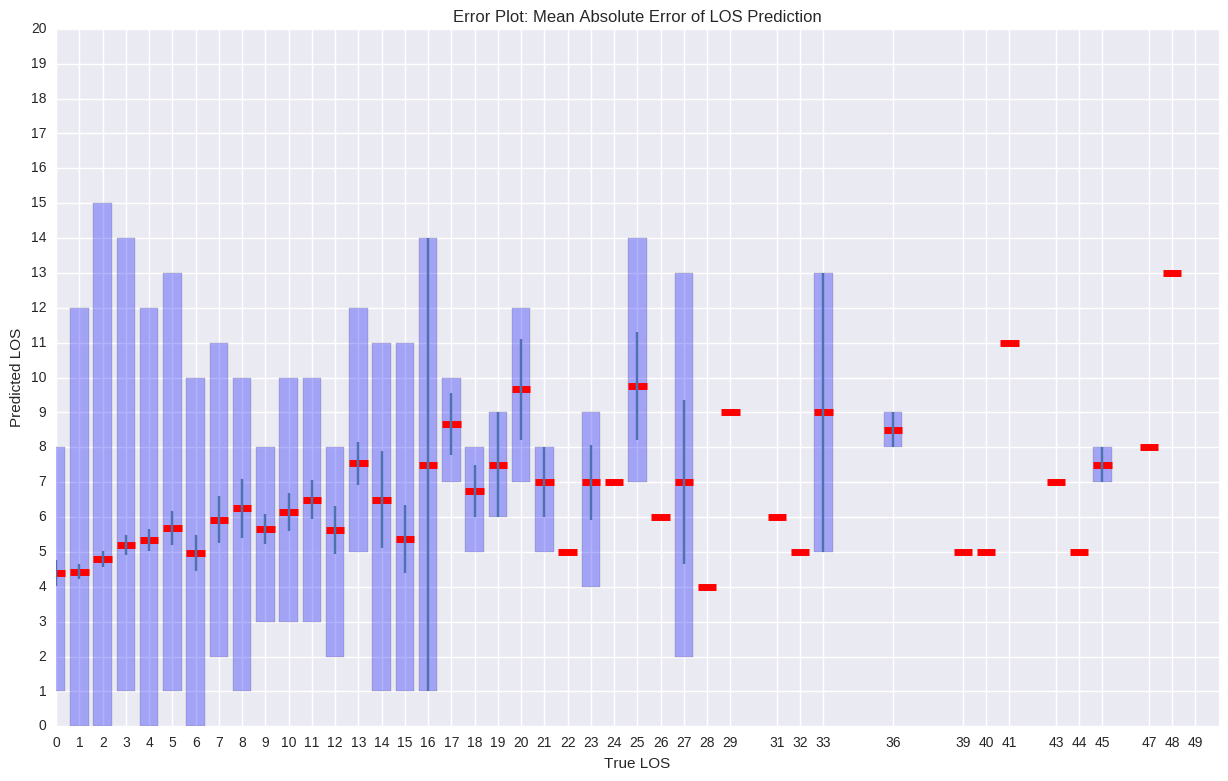

In [97]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in lr_errort3.index.tolist()], 
        height=lr_errort3[['pred']].values[:,3] - lr_errort3[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=lr_errort3[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in lr_errort3.index.tolist()], 
        height=[0]*len(lr_errort3), 
        width=0.8, 
        bottom=lr_errort3[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=lr_errort3[['pred']].values[:,2] / lr_errort3[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(lr_errort3.index)
plt.yticks(lr_errort3.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,20])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: Support Vector Regression

In [148]:
svr_model3, svr_pred3, svr_p3, svr_score3 = svr_gridsearch(select_X_train3, select_X_test3, y_train)
print "Best Parameters: ", svr_p3
print "Best Grid Search Score: ", svr_score3
print "Best Estimator: ", svr_model3

Best Parameters:  {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
Best Grid Search Score:  -0.00140045103517
Best Estimator:  SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


#### Compare Predictions

In [149]:
svr_pred3[-10:]

array([ 5.94619013,  3.9061185 ,  2.61555616,  4.03153895,  6.44865264,
        4.32277429,  3.22750668,  2.89469216,  1.90897876,  2.32813375])

In [150]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

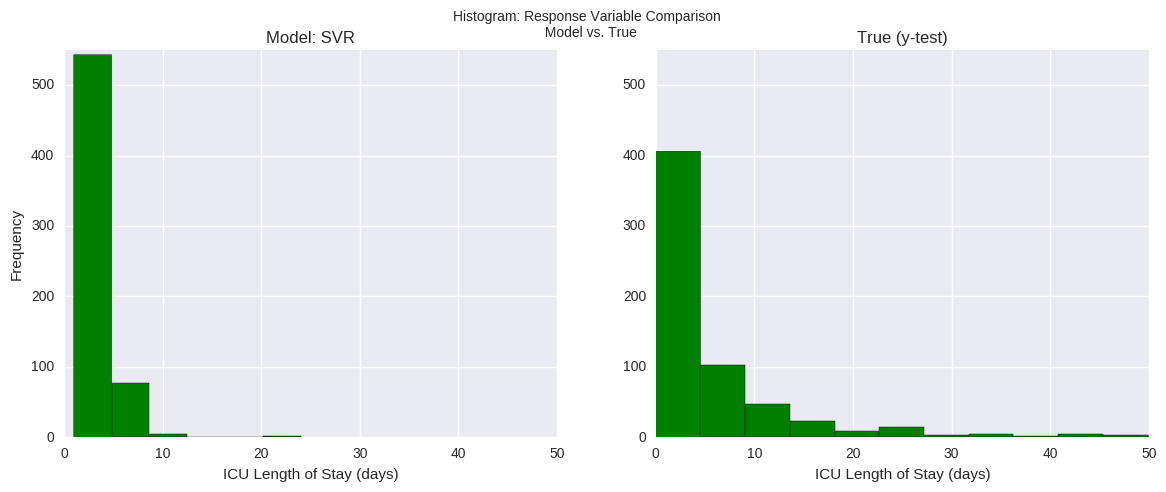

In [156]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred3), bins=6, color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [157]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, svr_pred3))

RMSE = 9.577 days


In [158]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [159]:
print " MAE = %.3f" % mean_absolute_error(y_test, svr_pred3)

 MAE = 4.593


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [160]:
print "r2 = %.3f" % r2_score(y_test, svr_pred3)

r2 = -0.033


### Error Visualization (MAE)

In [161]:
df_svrpred3 = pd.Series(svr_pred3, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_svrresults3 = pd.concat([df_true, df_svrpred3], axis=1)
svr_residual3 = pd.Series(df_svrresults3['true'].sub(df_svrresults3['pred'], axis=0).abs(), name='resid')
df_svrresults3 = pd.concat([df_svrresults3, svr_residual3], axis=1)

svr_errort3 = df_svrresults3[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

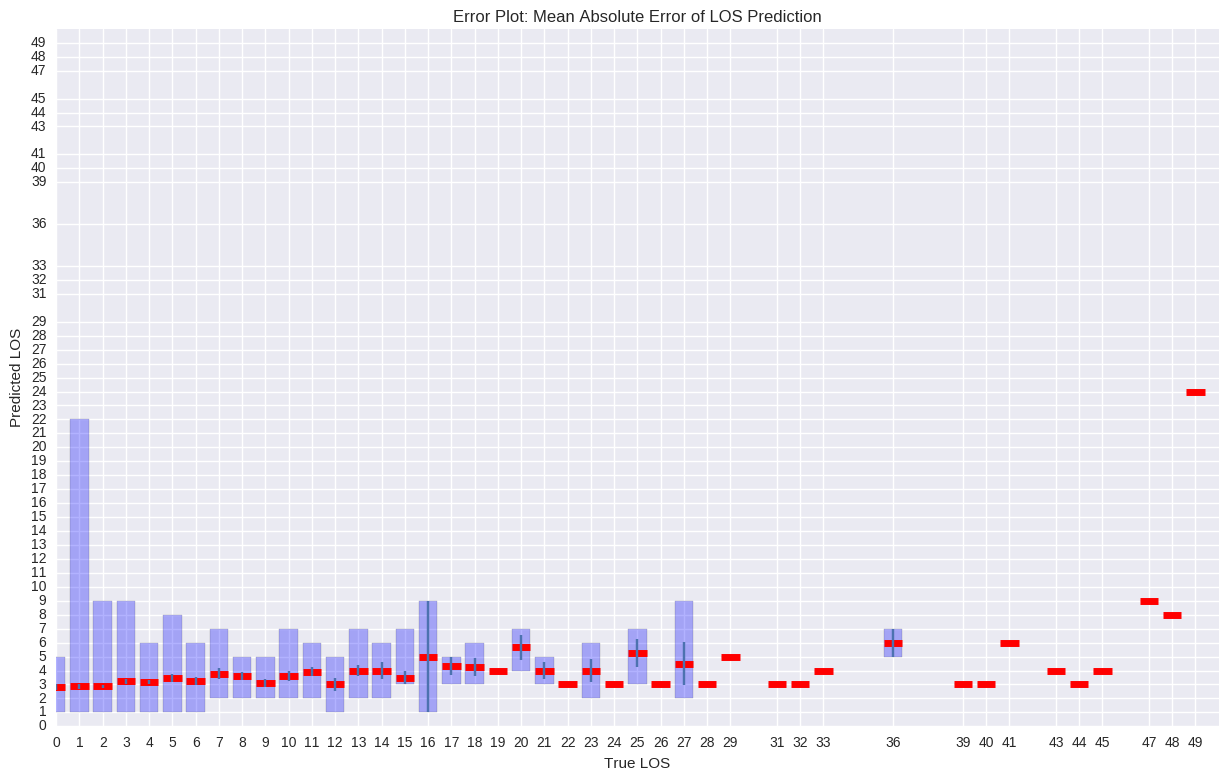

In [162]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in svr_errort3.index.tolist()], 
        height=svr_errort3[['pred']].values[:,3] - svr_errort3[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=svr_errort3[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in svr_errort3.index.tolist()], 
        height=[0]*len(svr_errort3), 
        width=0.8, 
        bottom=svr_errort3[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=svr_errort3[['pred']].values[:,2] / svr_errort3[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(svr_errort3.index)
plt.yticks(svr_errort3.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,50])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: k-Nearest Neighbors

In [99]:
knn_model3 = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model3.fit(select_X_train3, y_train) # fit model on training data
knn_pred3 = knn_model3.predict(select_X_test3)

#### Compare Predictions

In [100]:
knn_pred3[-10:]

array([  7.8681 ,   4.12344,   3.90258,   5.90506,  13.20814,  10.71238,
         3.93152,   3.4798 ,   1.69968,   3.13382])

In [101]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

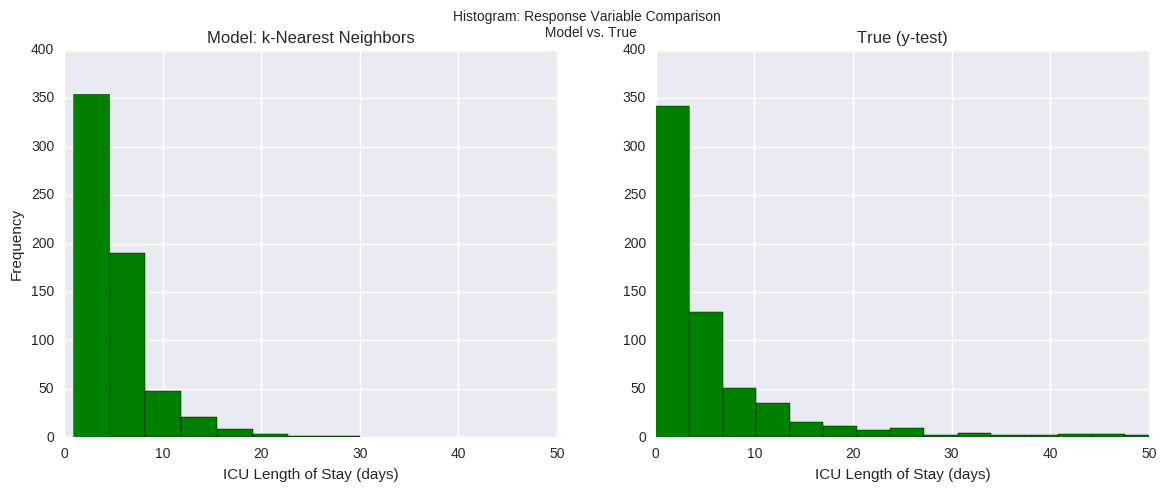

In [103]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred3), bins=8, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [104]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, knn_pred3))

RMSE = 9.576 days


In [105]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [106]:
print " MAE = %.3f" % mean_absolute_error(y_test, knn_pred3)

 MAE = 5.279


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [107]:
print "r2 = %.3f" % r2_score(y_test, knn_pred3)

r2 = -0.033


The k-NN model has very poor predictive power. This may be attributed to the fact that it's a "lazy learning" algorithm, *lacking generalization*. The model only does work (build a model) at the time of prediction and uses minimal, if any Training data.

### Error Visualization (MAE)

In [108]:
df_knnpred3 = pd.Series(knn_pred3, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_knnresults3 = pd.concat([df_true, df_knnpred3], axis=1)
knn_residual3 = pd.Series(df_knnresults3['true'].sub(df_knnresults3['pred'], axis=0).abs(), name='resid')
df_knnresults3 = pd.concat([df_knnresults3, knn_residual3], axis=1)

knn_errort3 = df_knnresults3[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

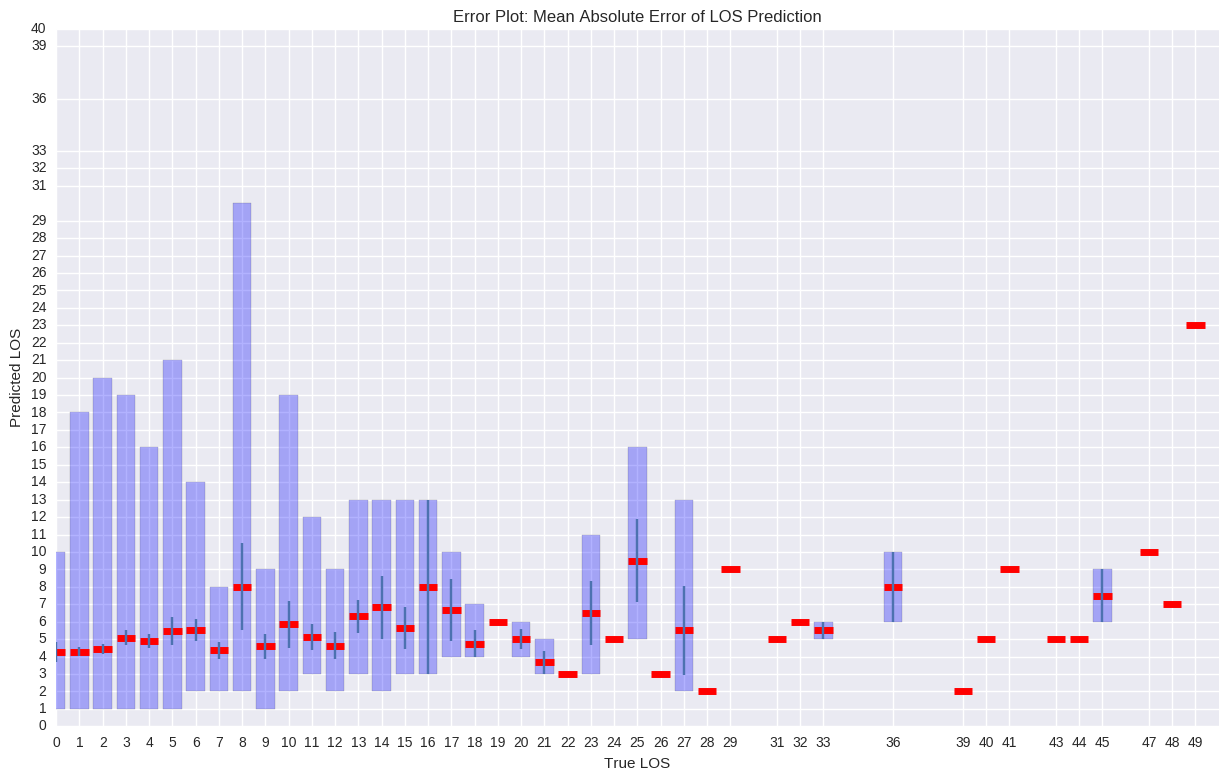

In [112]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in knn_errort3.index.tolist()], 
        height=knn_errort3[['pred']].values[:,3] - knn_errort3[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=knn_errort3[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in knn_errort3.index.tolist()], 
        height=[0]*len(knn_errort3), 
        width=0.8, 
        bottom=knn_errort3[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=knn_errort3[['pred']].values[:,2] / knn_errort3[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(knn_errort3.index)
plt.yticks(knn_errort3.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [113]:
rf_model3, rf_pred3, rf_p3, rf_score3, rf_imp3 = rf_gridsearch(select_X_train3, select_X_test3, y_train)
print "Best Parameters: ", rf_p3
print "Best Grid Search Score: ", rf_score3
print "Best Estimator: ", rf_model3

Best Parameters:  {'n_estimators': 6, 'criterion': 'mse'}
Best Grid Search Score:  -0.0713603883349
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=6, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


#### Compare Predictions

In [114]:
rf_pred3[-10:]

array([  7.15436667,   3.95661667,   3.12325   ,  12.16748333,
        15.29796667,   5.12268333,   2.93438333,   3.944     ,
         2.14055   ,   1.54225   ])

In [115]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

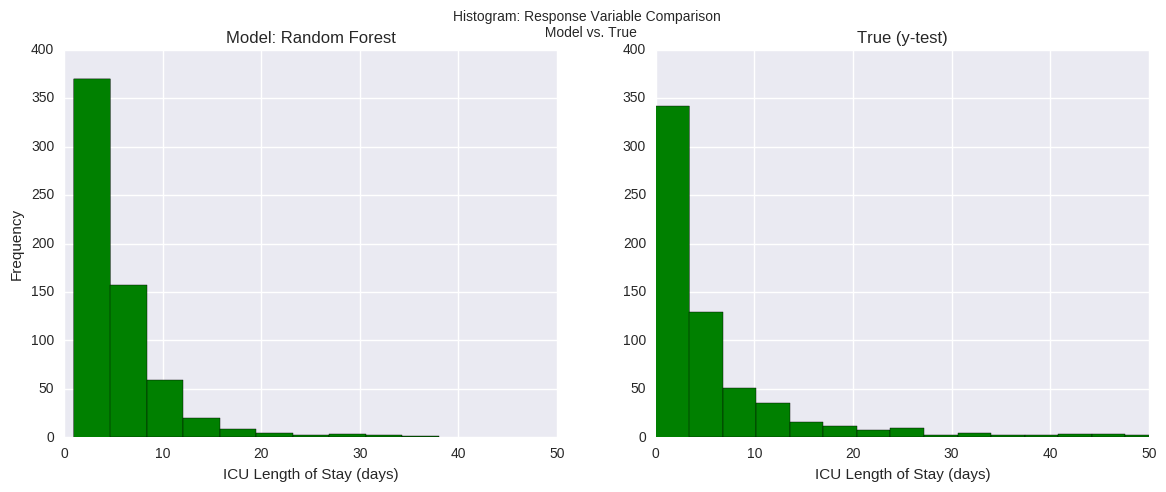

In [118]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred3), bins=10, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [121]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, rf_pred3))

RMSE = 9.922 days


In [122]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [123]:
print " MAE = %.3f" % mean_absolute_error(y_test, rf_pred3)

 MAE = 5.550


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [124]:
print "r2 = %.3f" % r2_score(y_test, rf_pred3)

r2 = -0.109


### Error Visualization (MAE)

In [125]:
df_rfpred3 = pd.Series(rf_pred3, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_rfresults3 = pd.concat([df_true, df_rfpred3], axis=1)
rf_residual3 = pd.Series(df_rfresults3['true'].sub(df_rfresults3['pred'], axis=0).abs(), name='resid')
df_rfresults3 = pd.concat([df_rfresults3, rf_residual3], axis=1)

rf_errort3 = df_rfresults3[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

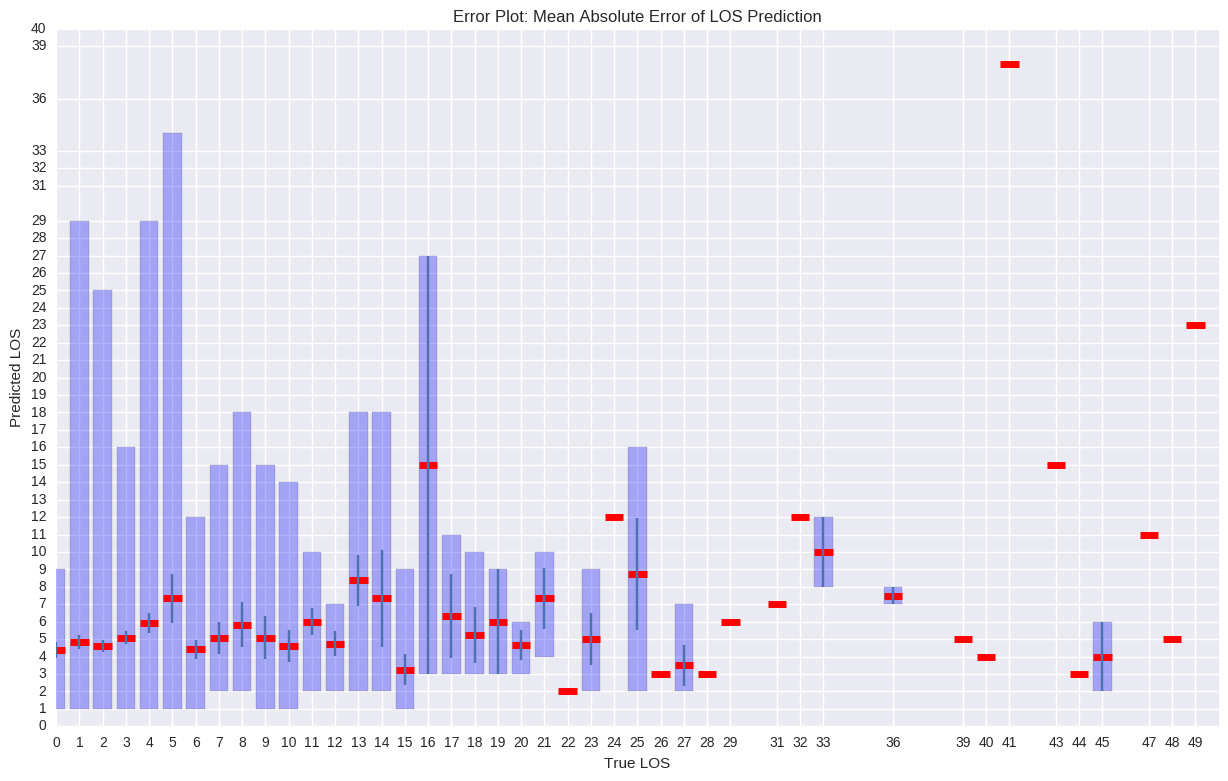

In [127]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in rf_errort3.index.tolist()], 
        height=rf_errort3[['pred']].values[:,3] - rf_errort3[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=rf_errort3[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in rf_errort3.index.tolist()], 
        height=[0]*len(rf_errort3), 
        width=0.8, 
        bottom=rf_errort3[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort3[['pred']].values[:,2] / rf_errort3[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(rf_errort3.index)
plt.yticks(rf_errort3.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Model: Gradient Boosting Regressor

In [128]:
gbr_model3, gbr_pred3, gbr_p3, gbr_score3 = gbr_gridsearch(select_X_train3, select_X_test3, y_train)
print "Best Parameters: ", gbr_p3
print "Best Grid Search Score: ", gbr_score3
print "Best Estimator: ", gbr_model3

Best Parameters:  {'loss': 'huber', 'criterion': 'mae'}
Best Grid Search Score:  -0.0123326146297
Best Estimator:  GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=2,
             subsample=1.0, verbose=0, warm_start=False)


#### Compare Predictions

In [129]:
gbr_pred3[-10:]

array([ 6.68835366,  4.13411049,  3.88521919,  2.64825871,  5.12032093,
        4.0451464 ,  3.97018389,  3.97018389,  2.85505676,  3.68816807])

In [130]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

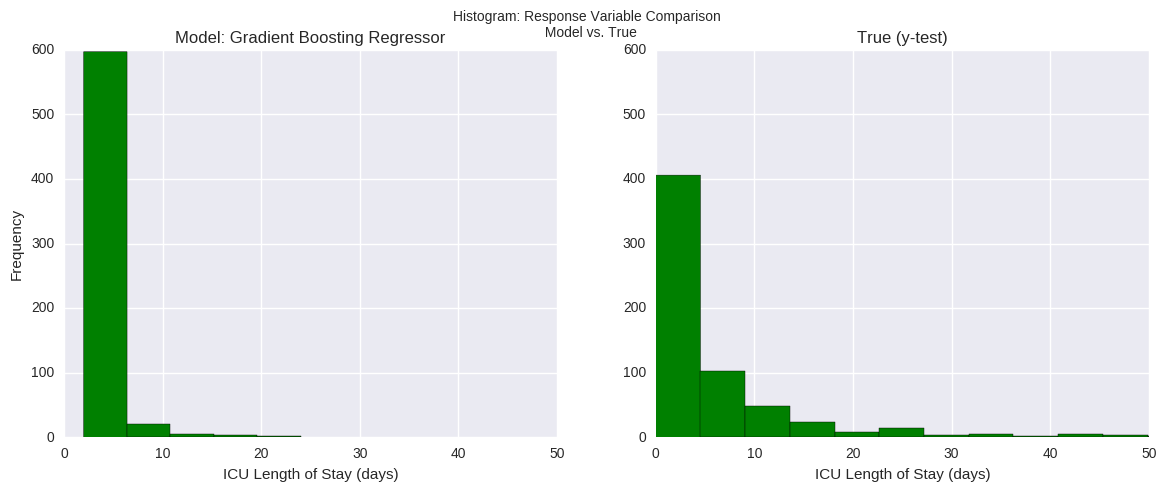

In [144]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(gbr_pred3), bins=5, color='g')
plt.title("Model: Gradient Boosting Regressor")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 600])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 600])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [145]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, gbr_pred3))

RMSE = 9.443 days


In [146]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [147]:
print " MAE = %.3f" % mean_absolute_error(y_test, gbr_pred3)

 MAE = 4.680


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [135]:
print "r2 = %.3f" % r2_score(y_test, gbr_pred3)

r2 = -0.004


### Error Visualization (MAE)

In [136]:
df_gbrpred3 = pd.Series(gbr_pred3, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_gbrresults3 = pd.concat([df_true, df_gbrpred3], axis=1)
gbr_residual3 = pd.Series(df_gbrresults3['true'].sub(df_gbrresults3['pred'], axis=0).abs(), name='resid')
df_gbrresults3 = pd.concat([df_gbrresults3, gbr_residual3], axis=1)

gbr_errort3 = df_gbrresults3[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

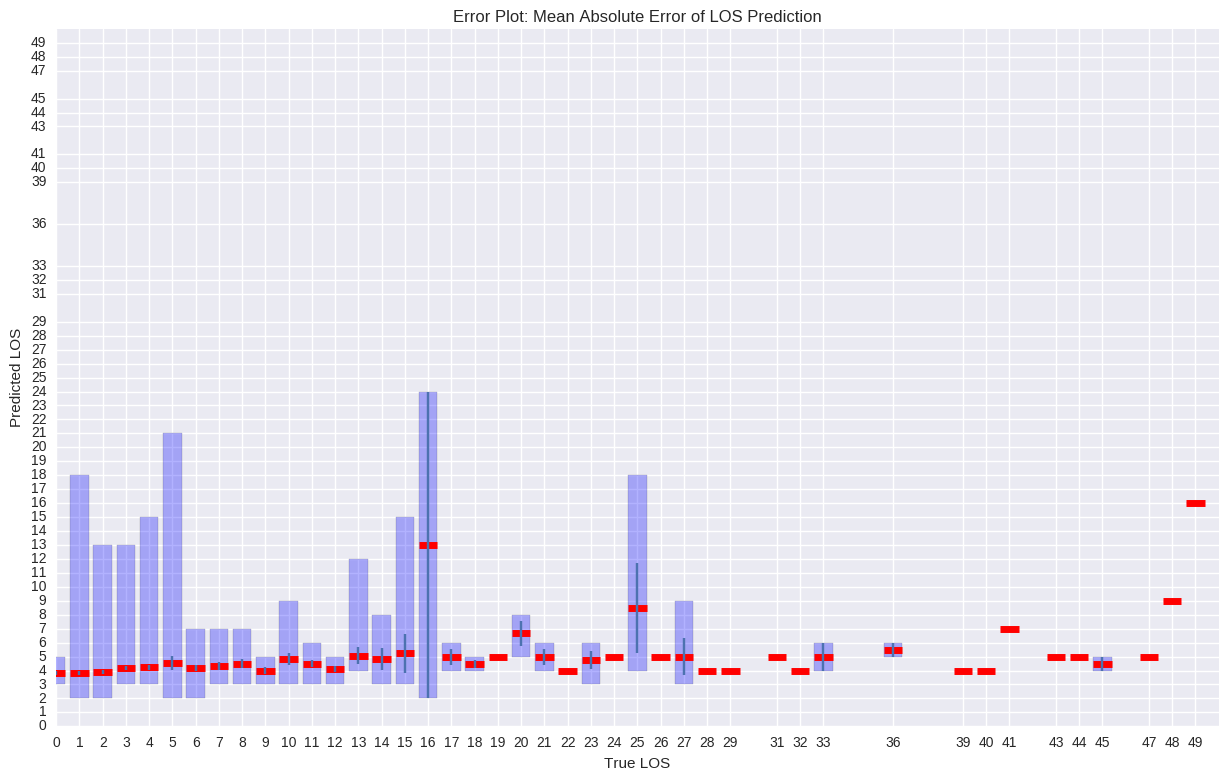

In [137]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in gbr_errort3.index.tolist()], 
        height=gbr_errort3[['pred']].values[:,3] - gbr_errort3[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=gbr_errort3[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in gbr_errort3.index.tolist()], 
        height=[0]*len(gbr_errort3), 
        width=0.8, 
        bottom=gbr_errort3[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=gbr_errort3[['pred']].values[:,2] / gbr_errort3[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(gbr_errort3.index)
plt.yticks(gbr_errort3.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,50])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Feature Selection: PCA

In [90]:
pca = PCA(n_components = 20)
select_X_train4 = pca.fit_transform(scaled_X_train)
select_X_test4 = pca.transform(scaled_X_test)

pca_X_train.shape, pca_X_test.shape, y_train.shape, y_test.shape

((2873, 20), (627, 20), (2873,), (627,))

In [91]:
print pca.explained_variance_ratio_.sum()
print pca.explained_variance_ratio_.shape
pca.explained_variance_ratio_

0.811977795931
(20,)


array([ 0.09025322,  0.06785976,  0.06471192,  0.06044847,  0.05457277,
        0.0450417 ,  0.04139474,  0.03853896,  0.03631454,  0.03267951,
        0.0316131 ,  0.03138402,  0.03021653,  0.028658  ,  0.02765614,
        0.02732396,  0.02682752,  0.02636985,  0.02532194,  0.02479116])

In [92]:
print pca.explained_variance_.shape
pca.explained_variance_

(20,)


array([ 2.97835638,  2.23937221,  2.13549324,  1.9947996 ,  1.80090131,
        1.48637599,  1.36602626,  1.27178565,  1.19837989,  1.07842374,
        1.04323215,  1.03567259,  0.99714562,  0.94571384,  0.91265259,
        0.9016906 ,  0.88530816,  0.87020507,  0.83562393,  0.81810843])

### Model: Linear Regression

In [93]:
lr_model4, lr_pred4, lr_p4, lr_score4 = lr_gridsearch(select_X_train4, select_X_test4, y_train)
print "Best Parameters: ", lr_p4
print "Best Grid Search Score: ", lr_score4
print "Best Estimator: ", lr_model4

Best Parameters:  {'normalize': False, 'fit_intercept': True}
Best Grid Search Score:  0.0838998630074
Best Estimator:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


#### Compare Predictions

In [94]:
lr_pred4[-10:]

array([ 15.9607813 ,   4.75631938,   3.75224312,   4.69752971,
        10.06868771,   8.92847736,   0.40280753,   2.4909488 ,
        11.06663248,   3.78408238])

In [95]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

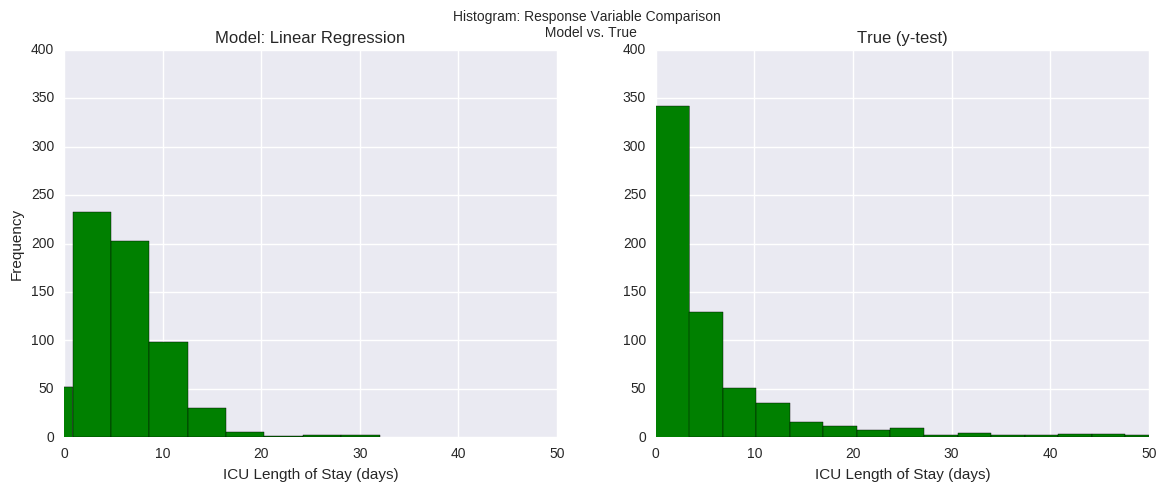

In [100]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred4), bins=9, color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0,400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [101]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, lr_pred4))

RMSE = 8.074 days


In [102]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [103]:
print " MAE = %.3f" % mean_absolute_error(y_test, lr_pred4)

 MAE = 4.739


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [104]:
print "r2 = %.3f" % r2_score(y_test, lr_pred4)

r2 = 0.266


### Error Visualization (MAE)

In [105]:
df_lrpred4 = pd.Series(lr_pred4, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_results4 = pd.concat([df_true, df_lrpred4], axis=1)
residual4 = pd.Series(df_results4['true'].sub(df_results4['pred'], axis=0).abs(), name='resid')
df_results4 = pd.concat([df_results4, residual4], axis=1)

lr_errort4 = df_results4[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

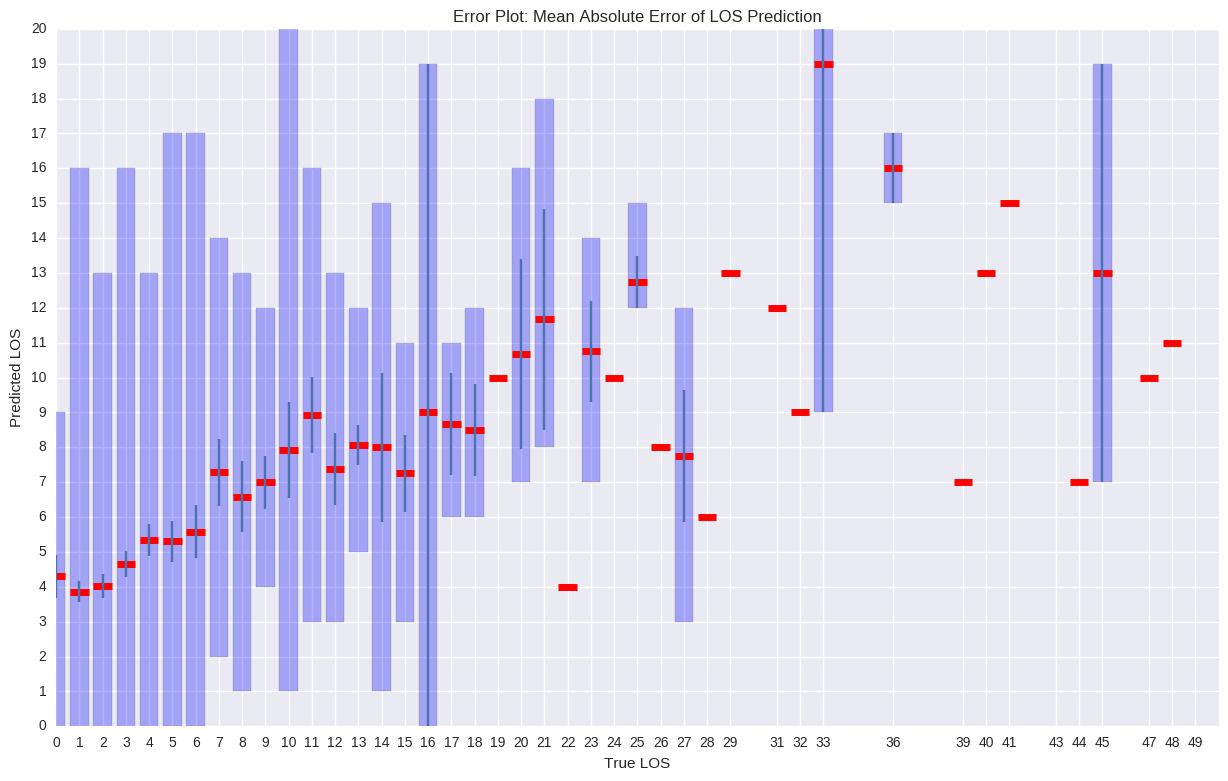

In [106]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in lr_errort4.index.tolist()], 
        height=lr_errort4[['pred']].values[:,3] - lr_errort4[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=lr_errort4[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in lr_errort4.index.tolist()], 
        height=[0]*len(lr_errort4), 
        width=0.8, 
        bottom=lr_errort4[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=lr_errort4[['pred']].values[:,2] / lr_errort4[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(lr_errort4.index)
plt.yticks(lr_errort4.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,20])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: Support Vector Regression

In [142]:
svr_model4, svr_pred4, svr_p4, svr_score4 = svr_gridsearch(select_X_train4, select_X_test4, y_train)
print "Best Parameters: ", svr_p4
print "Best Grid Search Score: ", svr_score4
print "Best Estimator: ", svr_model4

Best Parameters:  {'kernel': 'rbf', 'C': 100, 'gamma': 0.01}
Best Grid Search Score:  0.205981067944
Best Estimator:  SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


#### Compare Predictions

In [146]:
svr_pred4[-10:]

array([  7.9718666 ,   2.87324899,   3.34142351,   3.910078  ,
        13.58341712,   8.28967832,   2.3566607 ,   2.63856699,
         7.82853434,   1.88736961])

In [147]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

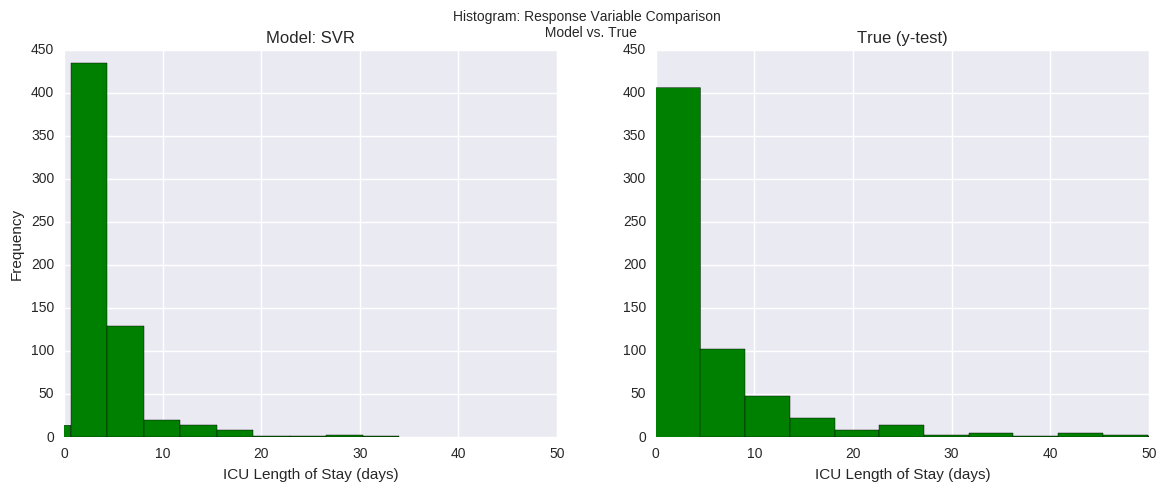

In [156]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred4), bins=10, color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 450])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 450])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [157]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, svr_pred4))

RMSE = 9.577 days


In [158]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [159]:
print " MAE = %.3f" % mean_absolute_error(y_test, svr_pred4)

 MAE = 4.593


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [160]:
print "r2 = %.3f" % r2_score(y_test, svr_pred4)

r2 = -0.033


### Error Visualization (MAE)

In [161]:
df_svrpred4 = pd.Series(svr_pred4, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_svrresults4 = pd.concat([df_true, df_svrpred4], axis=1)
svr_residual4 = pd.Series(df_svrresults4['true'].sub(df_svrresults4['pred'], axis=0).abs(), name='resid')
df_svrresults4 = pd.concat([df_svrresults4, svr_residual4], axis=1)

svr_errort4 = df_svrresults4[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

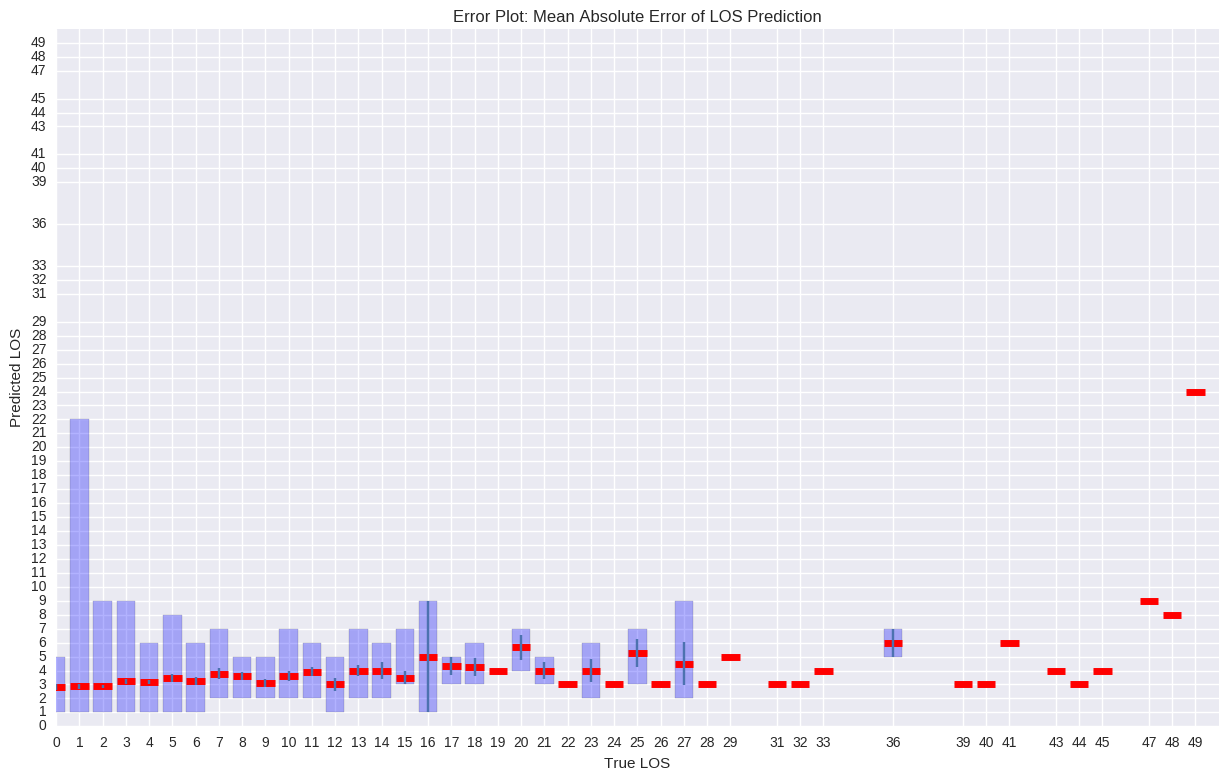

In [162]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in svr_errort4.index.tolist()], 
        height=svr_errort4[['pred']].values[:,3] - svr_errort4[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=svr_errort4[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in svr_errort4.index.tolist()], 
        height=[0]*len(svr_errort4), 
        width=0.8, 
        bottom=svr_errort4[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=svr_errort4[['pred']].values[:,2] / svr_errort4[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(svr_errort4.index)
plt.yticks(svr_errort4.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,50])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: k-Nearest Neighbors

In [107]:
knn_model4 = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model4.fit(select_X_train4, y_train) # fit model on training data
knn_pred4 = knn_model4.predict(select_X_test4)

#### Compare Predictions

In [109]:
knn_pred4[-10:]

array([  6.53694,   3.76198,   4.21488,   1.75208,  12.95438,   9.20006,
         2.62618,   2.27168,  16.08384,   2.655  ])

In [101]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

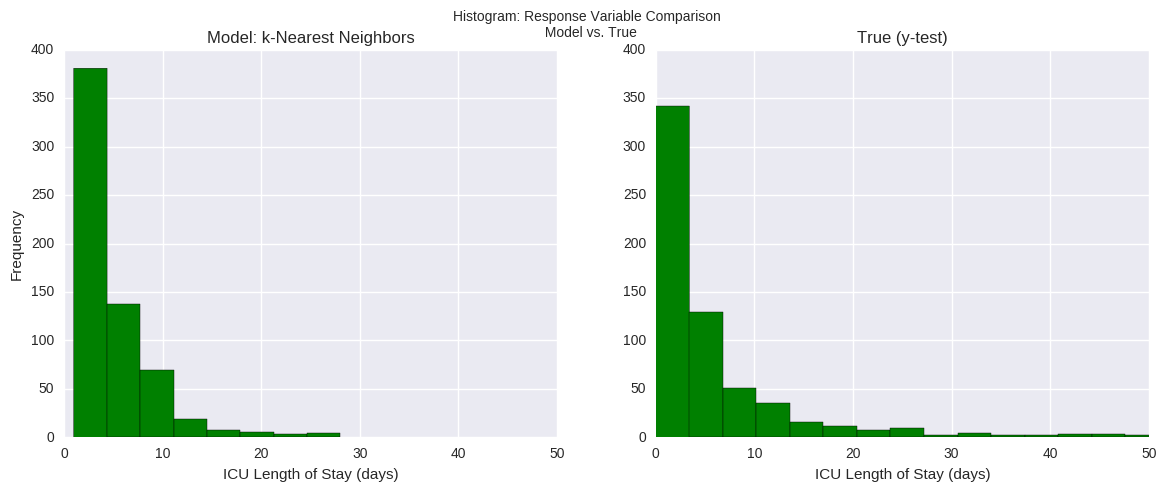

In [110]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred4), bins=8, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [111]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, knn_pred4))

RMSE = 8.596 days


In [112]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [113]:
print " MAE = %.3f" % mean_absolute_error(y_test, knn_pred4)

 MAE = 4.684


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [114]:
print "r2 = %.3f" % r2_score(y_test, knn_pred4)

r2 = 0.168


The k-NN model has very poor predictive power. This may be attributed to the fact that it's a "lazy learning" algorithm, *lacking generalization*. The model only does work (build a model) at the time of prediction and uses minimal, if any Training data.

### Error Visualization (MAE)

In [115]:
df_knnpred4 = pd.Series(knn_pred4, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_knnresults4 = pd.concat([df_true, df_knnpred4], axis=1)
knn_residual4 = pd.Series(df_knnresults4['true'].sub(df_knnresults4['pred'], axis=0).abs(), name='resid')
df_knnresults4 = pd.concat([df_knnresults4, knn_residual4], axis=1)

knn_errort4 = df_knnresults4[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

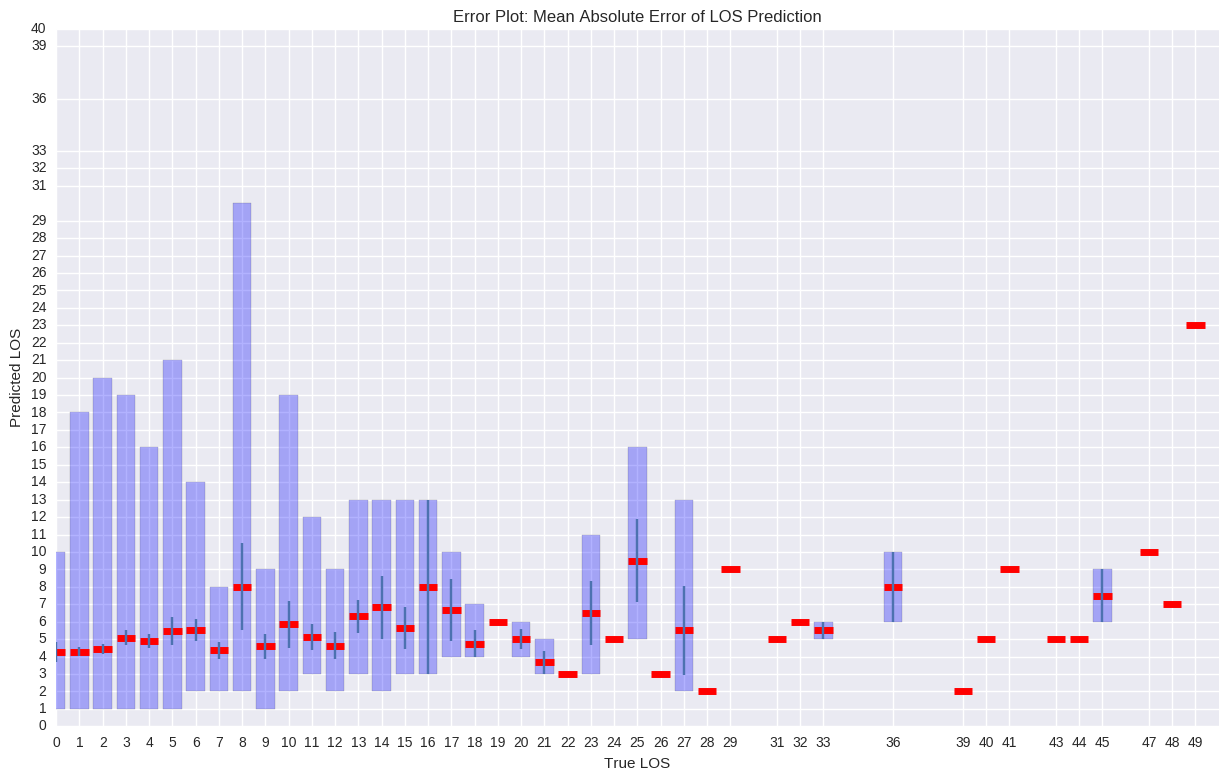

In [112]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in knn_errort3.index.tolist()], 
        height=knn_errort3[['pred']].values[:,3] - knn_errort3[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=knn_errort3[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in knn_errort3.index.tolist()], 
        height=[0]*len(knn_errort3), 
        width=0.8, 
        bottom=knn_errort3[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=knn_errort3[['pred']].values[:,2] / knn_errort3[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(knn_errort3.index)
plt.yticks(knn_errort3.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [116]:
rf_model4, rf_pred4, rf_p4, rf_score4, rf_imp4 = rf_gridsearch(select_X_train4, select_X_test4, y_train)
print "Best Parameters: ", rf_p4
print "Best Grid Search Score: ", rf_score4
print "Best Estimator: ", rf_model4

Best Parameters:  {'n_estimators': 10, 'criterion': 'mae'}
Best Grid Search Score:  0.145337328202
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


#### Compare Predictions

In [117]:
rf_pred4[-10:]

array([  9.67403,   2.38987,   2.72458,   3.70029,  15.3501 ,   3.04081,
         2.51306,   2.89898,   7.46744,   6.65349])

In [118]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

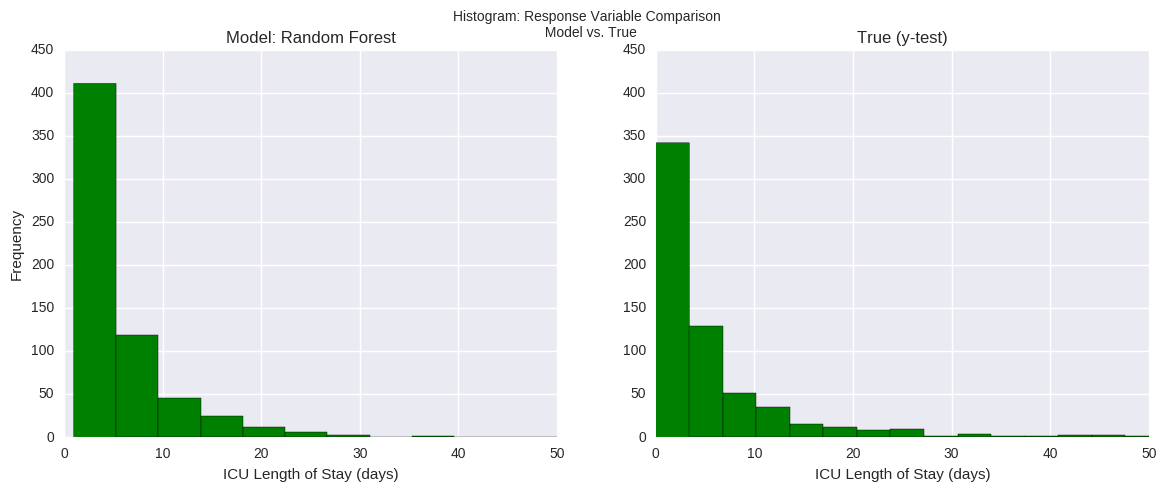

In [123]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred4), bins=14, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 450])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 450])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [124]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, rf_pred4))

RMSE = 8.469 days


In [125]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [126]:
print " MAE = %.3f" % mean_absolute_error(y_test, rf_pred4)

 MAE = 4.823


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [127]:
print "r2 = %.3f" % r2_score(y_test, rf_pred4)

r2 = 0.192


### Error Visualization (MAE)

In [128]:
df_rfpred4 = pd.Series(rf_pred4, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_rfresults4 = pd.concat([df_true, df_rfpred4], axis=1)
rf_residual4 = pd.Series(df_rfresults4['true'].sub(df_rfresults4['pred'], axis=0).abs(), name='resid')
df_rfresults4 = pd.concat([df_rfresults4, rf_residual4], axis=1)

rf_errort4 = df_rfresults4[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

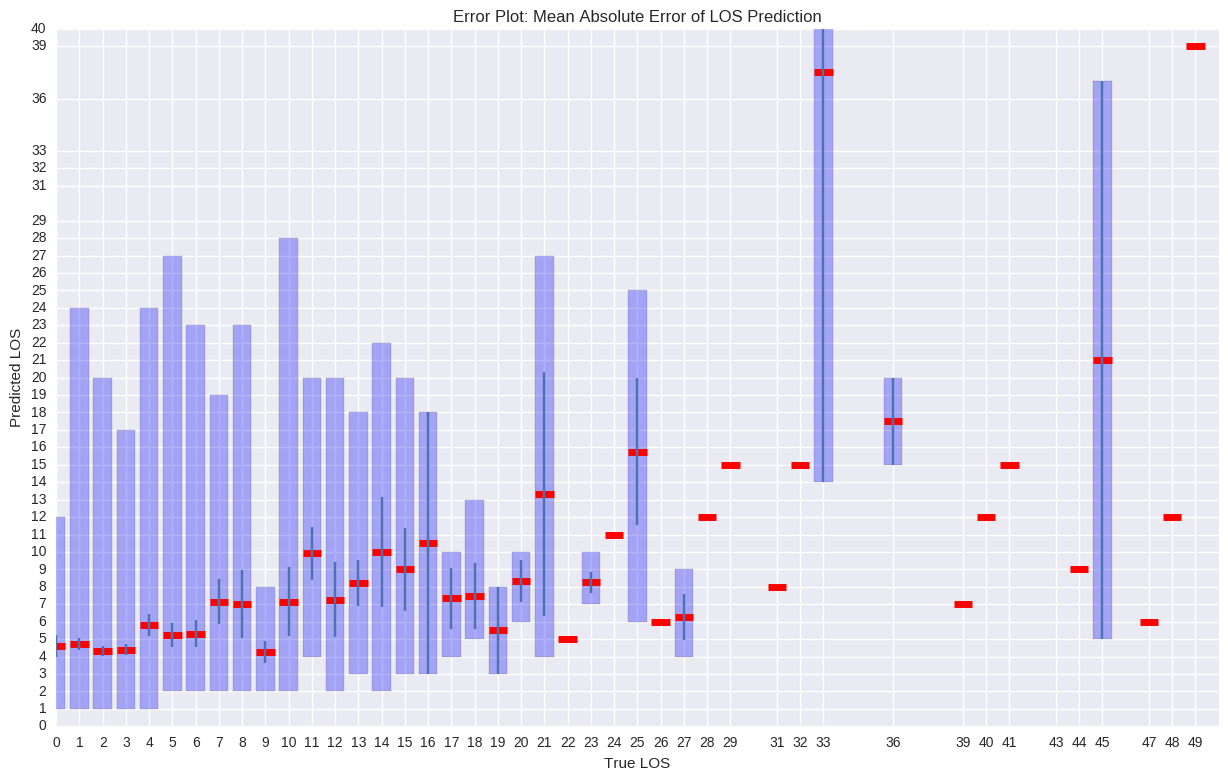

In [129]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in rf_errort4.index.tolist()], 
        height=rf_errort4[['pred']].values[:,3] - rf_errort4[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=rf_errort4[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in rf_errort4.index.tolist()], 
        height=[0]*len(rf_errort4), 
        width=0.8, 
        bottom=rf_errort4[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort4[['pred']].values[:,2] / rf_errort4[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(rf_errort4.index)
plt.yticks(rf_errort4.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Model: Gradient Boosting Regressor

In [130]:
gbr_model4, gbr_pred4, gbr_p4, gbr_score4 = gbr_gridsearch(select_X_train4, select_X_test4, y_train)
print "Best Parameters: ", gbr_p4
print "Best Grid Search Score: ", gbr_score4
print "Best Estimator: ", gbr_model4

Best Parameters:  {'loss': 'huber', 'criterion': 'mae'}
Best Grid Search Score:  0.165614830361
Best Estimator:  GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=2,
             subsample=1.0, verbose=0, warm_start=False)


#### Compare Predictions

In [131]:
gbr_pred4[-10:]

array([  6.3017    ,   2.6481899 ,   2.67124622,  15.36697081,
         5.96036338,   5.50721047,   2.62657717,   2.94018858,
         3.92354652,   3.06174104])

In [132]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

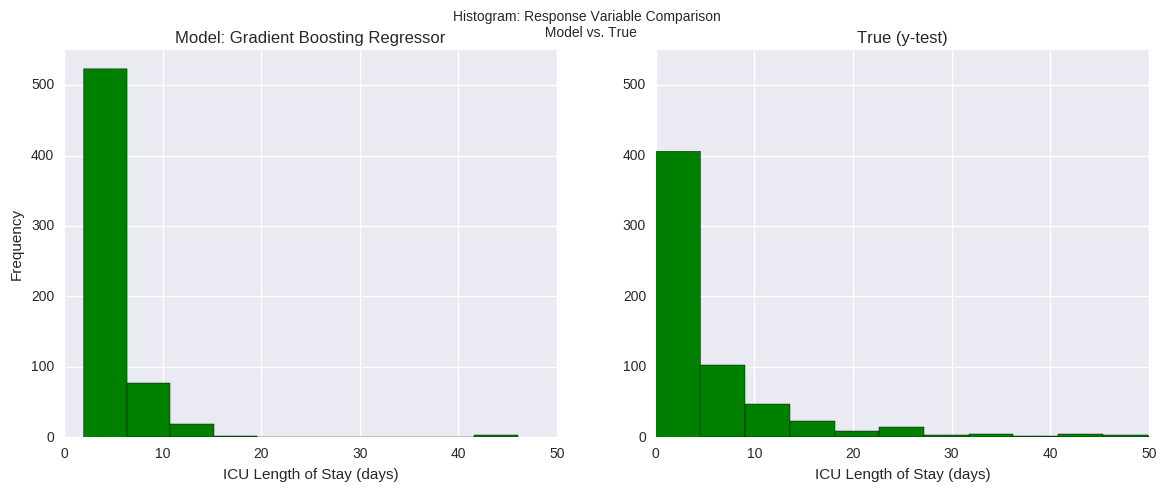

In [135]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(gbr_pred4), bins=10, color='g')
plt.title("Model: Gradient Boosting Regressor")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [136]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, gbr_pred4))

RMSE = 8.372 days


In [137]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [138]:
print " MAE = %.3f" % mean_absolute_error(y_test, gbr_pred4)

 MAE = 4.274


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [139]:
print "r2 = %.3f" % r2_score(y_test, gbr_pred4)

r2 = 0.210


### Error Visualization (MAE)

In [140]:
df_gbrpred4 = pd.Series(gbr_pred4, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_gbrresults4 = pd.concat([df_true, df_gbrpred4], axis=1)
gbr_residual4 = pd.Series(df_gbrresults4['true'].sub(df_gbrresults4['pred'], axis=0).abs(), name='resid')
df_gbrresults4 = pd.concat([df_gbrresults4, gbr_residual4], axis=1)

gbr_errort4 = df_gbrresults4[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

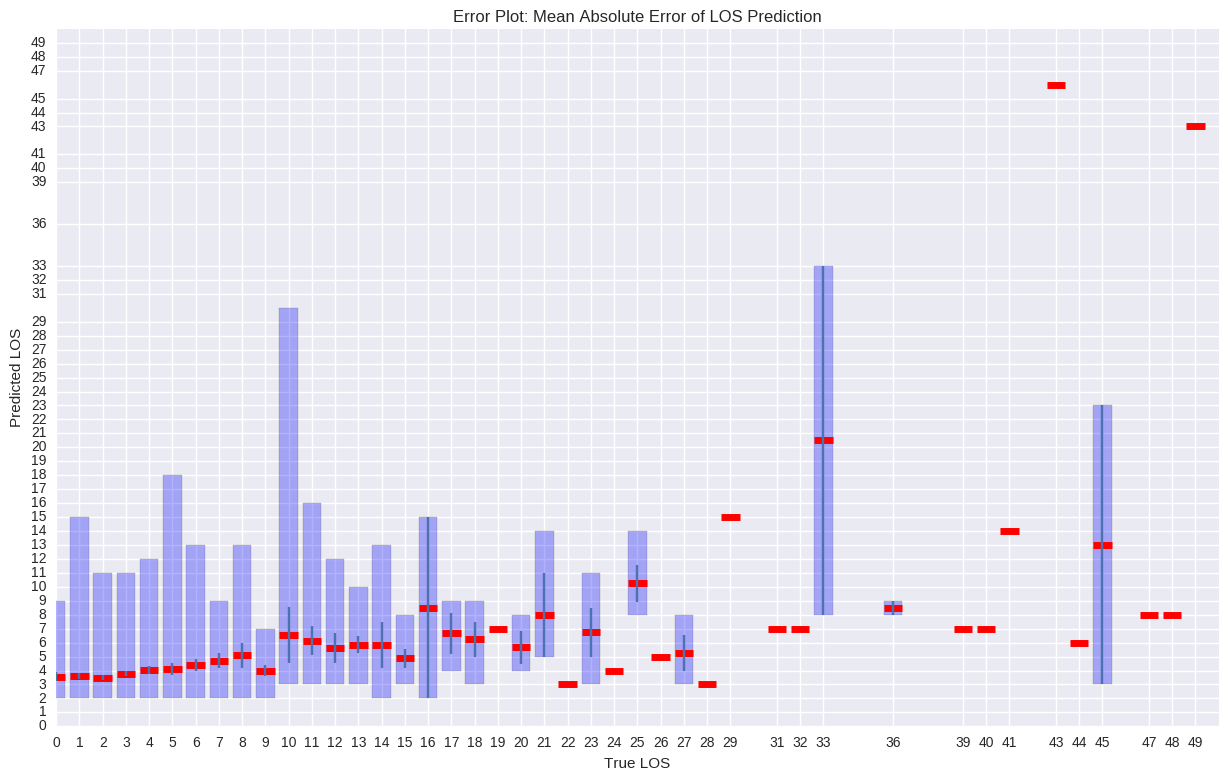

In [141]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in gbr_errort4.index.tolist()], 
        height=gbr_errort4[['pred']].values[:,3] - gbr_errort4[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=gbr_errort4[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in gbr_errort4.index.tolist()], 
        height=[0]*len(gbr_errort4), 
        width=0.8, 
        bottom=gbr_errort4[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=gbr_errort4[['pred']].values[:,2] / gbr_errort4[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(gbr_errort4.index)
plt.yticks(gbr_errort4.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,50])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Feature Selection: KMeans Clustering

In [138]:
kmeans_model = KMeans(init='k-means++', n_clusters=2) #instance of k-means clustering model

orig_X = scaled_X_train[:] # copy
select_X_train5 = orig_X[:, 6].reshape(-1,1)
orig_X = np.delete(orig_X, 6, axis=1)

## Testing set
orig_X_test = scaled_X_test[:]
select_X_test5 = orig_X_test[:, 6].reshape(-1,1)
orig_X_test = np.delete(orig_X_test, 6, axis=1)

# select_lst = [6] # list of selected features

count=1 # adjust index position
while select_X_train5.shape[1] < 20:
    feat_sil = dict()
    for i in range(orig_X.shape[1]):
        try:
            data = np.concatenate( [select_X_train5, orig_X[:, i].reshape(-1,1)], axis=1)
            kmeans_model.fit(data) 
            n_clusters = kmeans_model.n_clusters #number of clusters
            labels = kmeans_model.labels_ #cluster labels

            feat_sil[i] = silhouette_score(data, labels)
        except:
            continue
    
    
    max_feat = max(feat_sil, key=feat_sil.get)
    select_X_train5 = np.concatenate([select_X_train5, orig_X[:, max_feat].reshape(-1,1)], axis=1)
    orig_X = np.delete(orig_X, max_feat, axis=1)
#     select_lst += [max_feat+count]    
#     count +=1

    select_X_test5 = np.concatenate([select_X_test5, orig_X_test[:, max_feat].reshape(-1,1)], axis=1)
    orig_X_test = np.delete(orig_X_test, max_feat, axis=1)

In [142]:
select_X_train5.shape, select_X_test5.shape, y_train.shape, y_test.shape

((2873, 20), (627, 20), (2873,), (627,))

### Model: Linear Regression

In [143]:
lr_model5, lr_pred5, lr_p5, lr_score5 = lr_gridsearch(select_X_train5, select_X_test5, y_train)
print "Best Parameters: ", lr_p5
print "Best Grid Search Score: ", lr_score5
print "Best Estimator: ", lr_model5

Best Parameters:  {'normalize': True, 'fit_intercept': True}
Best Grid Search Score:  0.0773593652771
Best Estimator:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


#### Compare Predictions

In [144]:
lr_pred5[-10:]

array([ 12.49080326,   3.46691312,   2.33548361,   8.50622041,
        11.96388026,   6.17908497,   2.18437742,   2.96363723,
         7.95099203,   2.08485193])

In [145]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

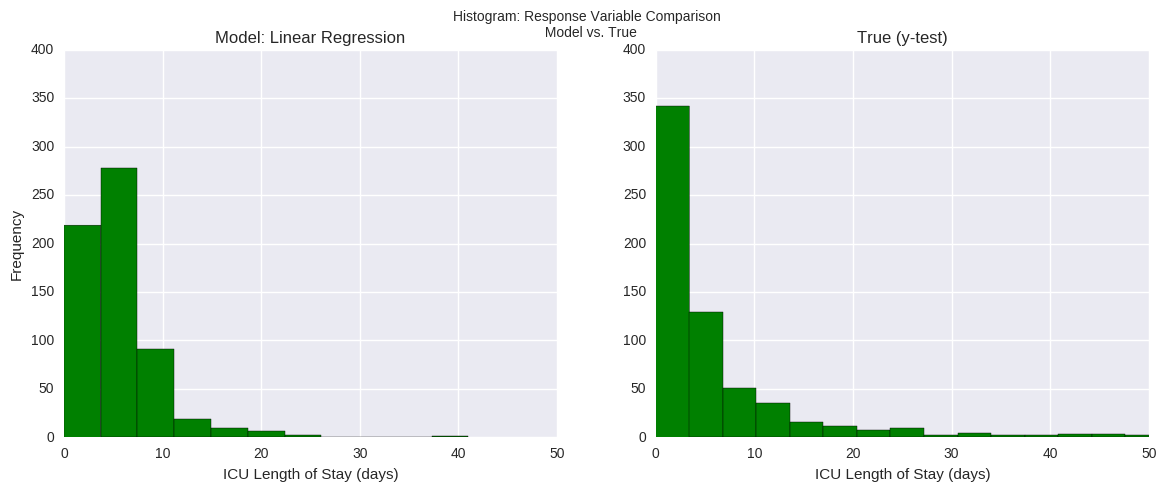

In [147]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred5), bins=11, color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0,400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [148]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, lr_pred5))

RMSE = 8.548 days


In [149]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [150]:
print " MAE = %.3f" % mean_absolute_error(y_test, lr_pred5)

 MAE = 4.855


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [151]:
print "r2 = %.3f" % r2_score(y_test, lr_pred5)

r2 = 0.177


### Error Visualization (MAE)

In [152]:
df_lrpred5 = pd.Series(lr_pred5, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_results5 = pd.concat([df_true, df_lrpred5], axis=1)
residual5 = pd.Series(df_results5['true'].sub(df_results5['pred'], axis=0).abs(), name='resid')
df_results5 = pd.concat([df_results5, residual5], axis=1)

lr_errort5 = df_results5[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

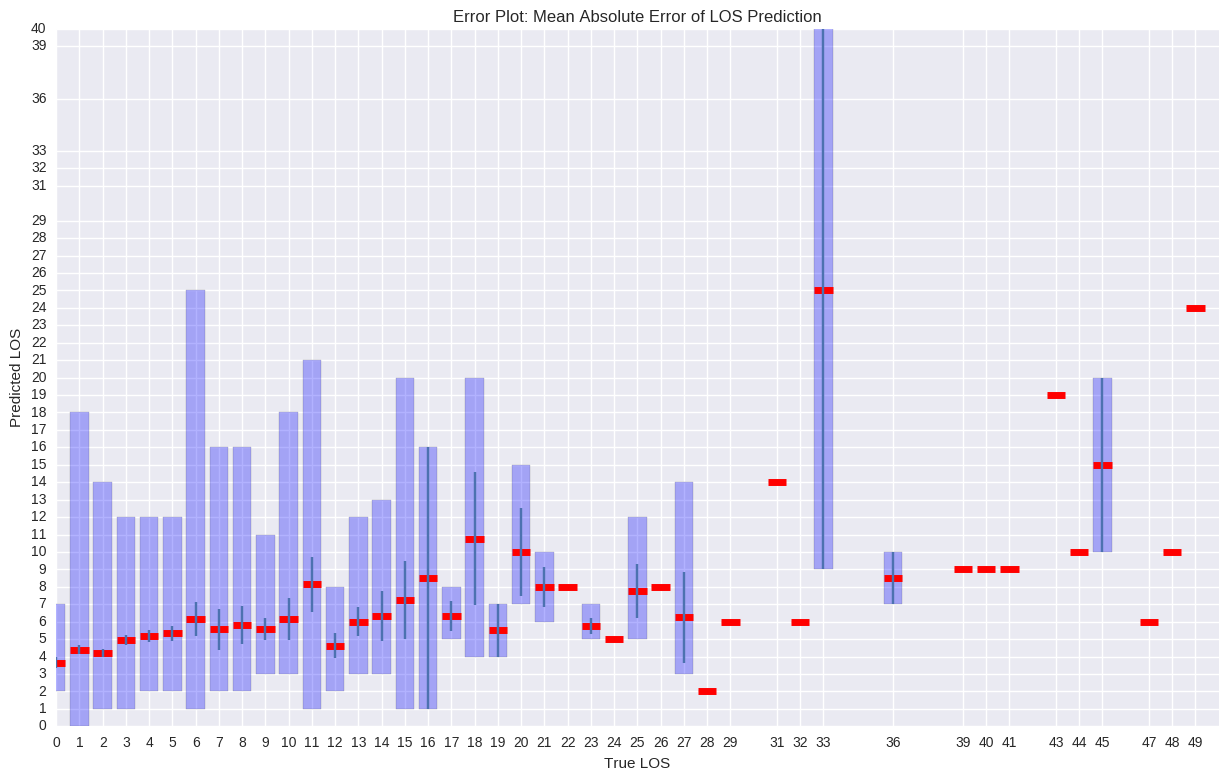

In [154]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in lr_errort5.index.tolist()], 
        height=lr_errort5[['pred']].values[:,3] - lr_errort5[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=lr_errort5[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in lr_errort5.index.tolist()], 
        height=[0]*len(lr_errort5), 
        width=0.8, 
        bottom=lr_errort5[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=lr_errort5[['pred']].values[:,2] / lr_errort5[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(lr_errort5.index)
plt.yticks(lr_errort5.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: Support Vector Regression

In [155]:
svr_model5, svr_pred5, svr_p5, svr_score5 = svr_gridsearch(select_X_train5, select_X_test5, y_train)
print "Best Parameters: ", svr_p5
print "Best Grid Search Score: ", svr_score5
print "Best Estimator: ", svr_model5

Best Parameters:  {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
Best Grid Search Score:  0.0526550385432
Best Estimator:  SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


#### Compare Predictions

In [156]:
svr_pred5[-10:]

array([ 8.06412676,  2.35779177,  2.09937675,  6.59954732,  7.16344477,
        3.67304589,  2.09935695,  1.88153078,  4.46484349,  1.94768025])

In [157]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

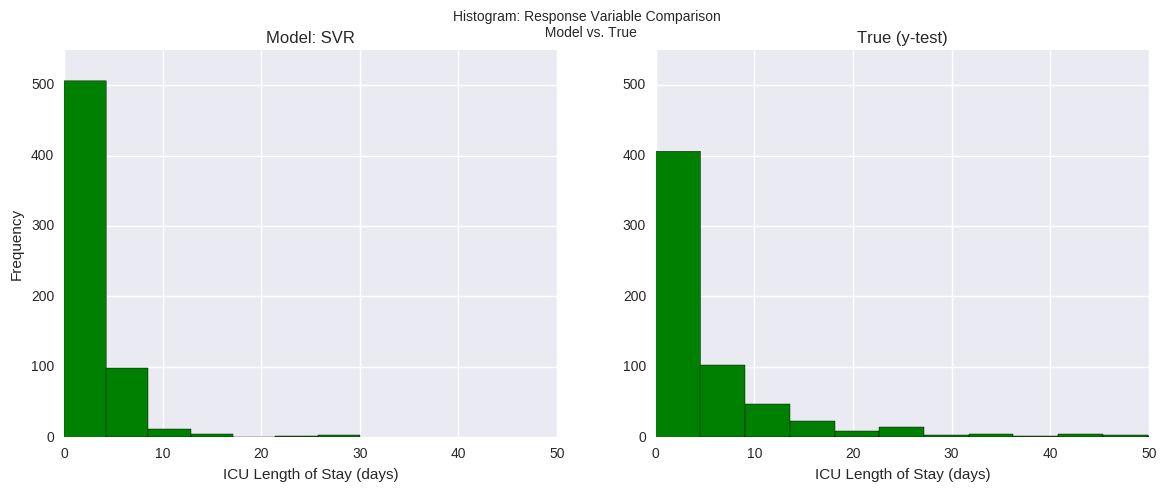

In [163]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred5), bins=7, color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,550])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [164]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, svr_pred5))

RMSE = 8.981 days


In [158]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [165]:
print " MAE = %.3f" % mean_absolute_error(y_test, svr_pred5)

 MAE = 4.479


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [166]:
print "r2 = %.3f" % r2_score(y_test, svr_pred5)

r2 = 0.092


### Error Visualization (MAE)

In [170]:
df_svrpred5 = pd.Series(svr_pred5, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_svrresults5 = pd.concat([df_true, df_svrpred5], axis=1)
svr_residual5 = pd.Series(df_svrresults5['true'].sub(df_svrresults5['pred'], axis=0).abs(), name='resid')
df_svrresults5 = pd.concat([df_svrresults5, svr_residual5], axis=1)

svr_errort5 = df_svrresults5[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

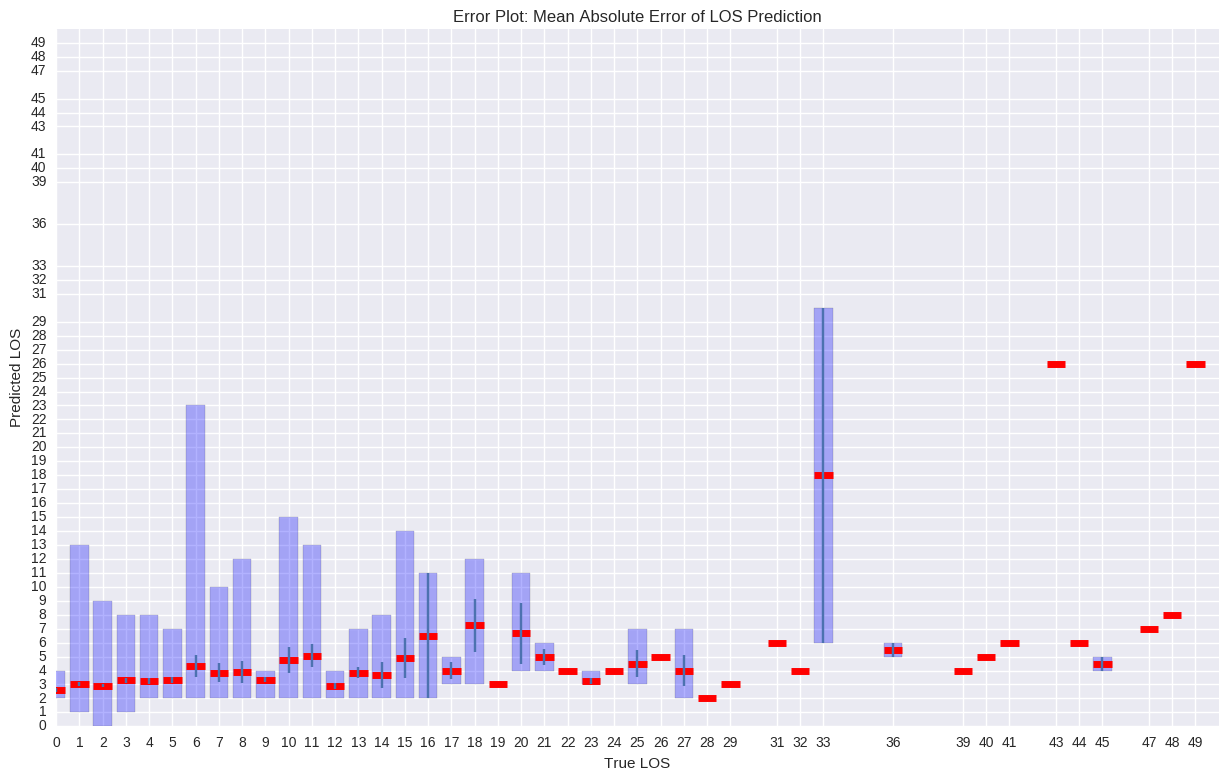

In [173]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in svr_errort5.index.tolist()], 
        height=svr_errort5[['pred']].values[:,3] - svr_errort5[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=svr_errort5[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in svr_errort5.index.tolist()], 
        height=[0]*len(svr_errort5), 
        width=0.8, 
        bottom=svr_errort5[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=svr_errort5[['pred']].values[:,2] / svr_errort5[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(svr_errort5.index)
plt.yticks(svr_errort5.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,50])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: k-Nearest Neighbors

In [174]:
knn_model5 = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model5.fit(select_X_train5, y_train) # fit model on training data
knn_pred5 = knn_model5.predict(select_X_test5)

#### Compare Predictions

In [175]:
knn_pred5[-10:]

array([  8.27752,   2.65822,   3.12296,   8.3642 ,   6.83442,  10.7887 ,
         3.26494,   2.20374,   7.1485 ,   3.49484])

In [101]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

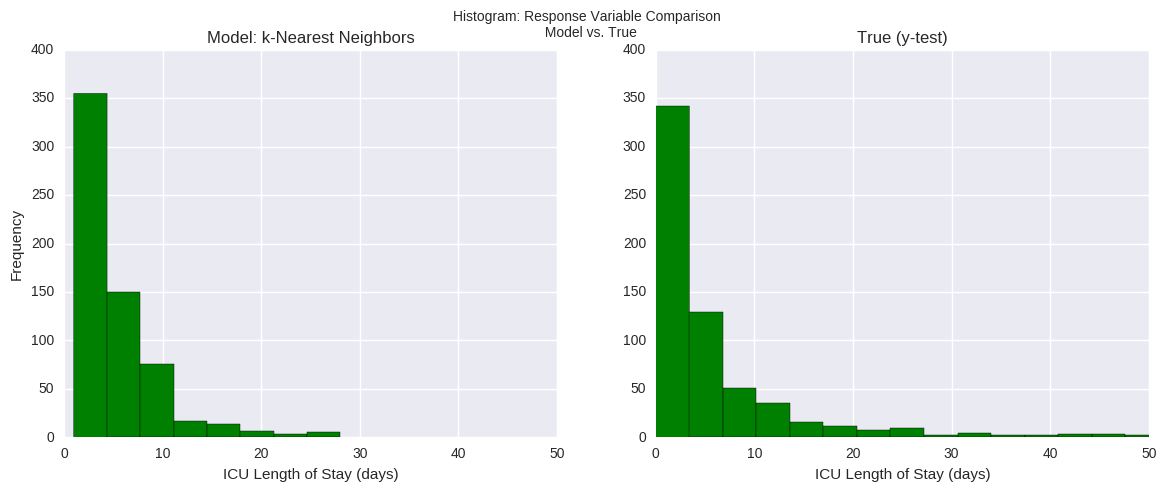

In [176]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred5), bins=8, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [177]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, knn_pred5))

RMSE = 9.192 days


In [112]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [178]:
print " MAE = %.3f" % mean_absolute_error(y_test, knn_pred5)

 MAE = 5.294


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [179]:
print "r2 = %.3f" % r2_score(y_test, knn_pred5)

r2 = 0.048


The k-NN model has very poor predictive power. This may be attributed to the fact that it's a "lazy learning" algorithm, *lacking generalization*. The model only does work (build a model) at the time of prediction and uses minimal, if any Training data.

### Error Visualization (MAE)

In [180]:
df_knnpred5 = pd.Series(knn_pred5, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_knnresults5 = pd.concat([df_true, df_knnpred5], axis=1)
knn_residual5 = pd.Series(df_knnresults5['true'].sub(df_knnresults5['pred'], axis=0).abs(), name='resid')
df_knnresults5 = pd.concat([df_knnresults5, knn_residual5], axis=1)

knn_errort5 = df_knnresults5[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

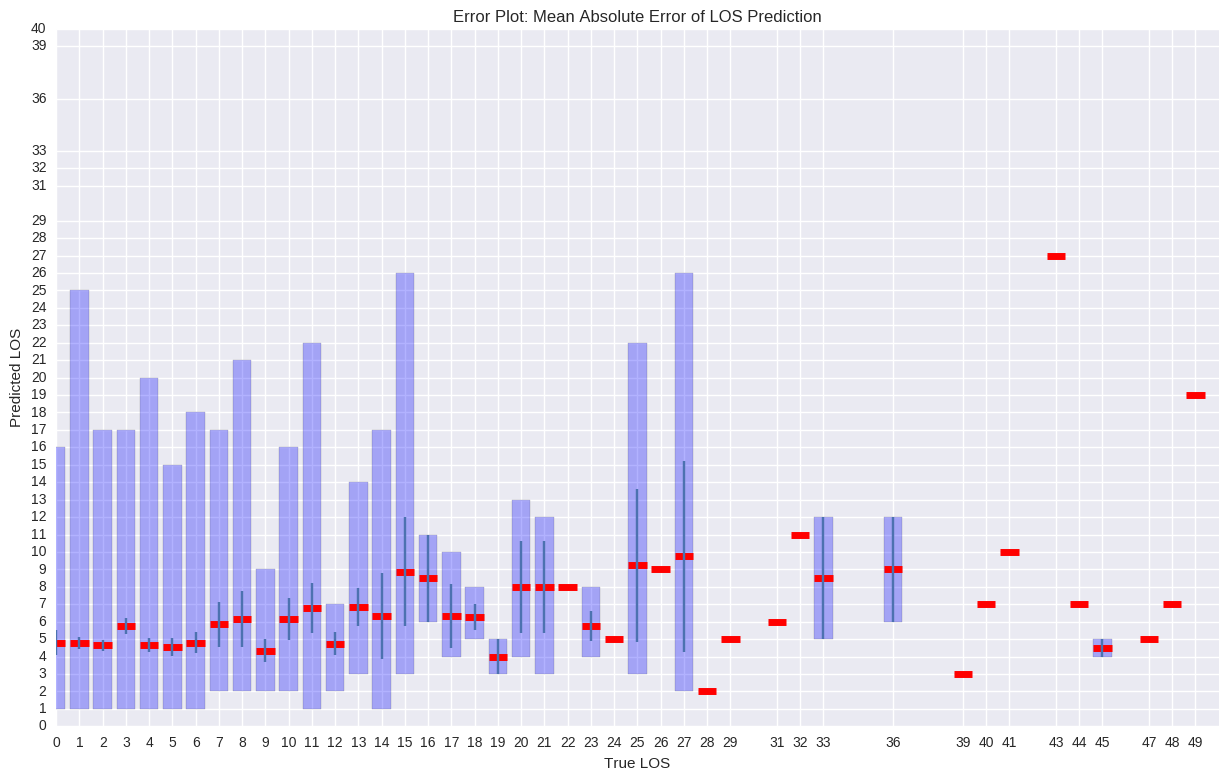

In [181]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in knn_errort5.index.tolist()], 
        height=knn_errort5[['pred']].values[:,3] - knn_errort5[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=knn_errort5[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in knn_errort5.index.tolist()], 
        height=[0]*len(knn_errort5), 
        width=0.8, 
        bottom=knn_errort5[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=knn_errort5[['pred']].values[:,2] / knn_errort5[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(knn_errort5.index)
plt.yticks(knn_errort5.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [182]:
rf_model5, rf_pred5, rf_p5, rf_score5, rf_imp5 = rf_gridsearch(select_X_train5, select_X_test5, y_train)
print "Best Parameters: ", rf_p5
print "Best Grid Search Score: ", rf_score5
print "Best Estimator: ", rf_model5

Best Parameters:  {'n_estimators': 9, 'criterion': 'mae'}
Best Grid Search Score:  -0.0625369014112
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=9, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


#### Compare Predictions

In [183]:
rf_pred5[-10:]

array([  9.18451111,   1.25025556,   1.97348889,   3.89446667,
        10.75767778,   8.57281111,   1.93845556,   4.44616667,
         9.98943333,   1.74244444])

In [184]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

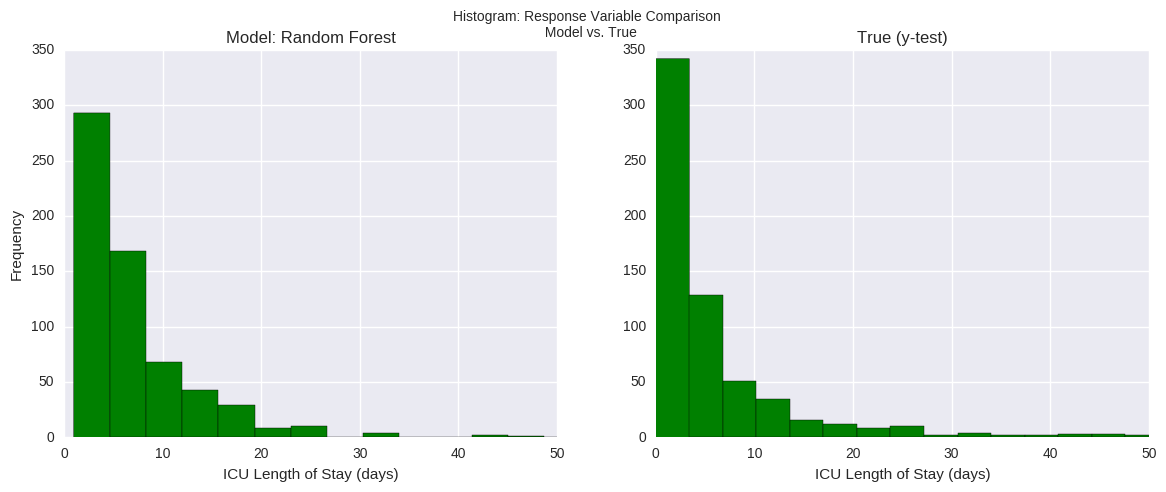

In [188]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred5), bins=18, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 350])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 350])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [189]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, rf_pred5))

RMSE = 8.905 days


In [125]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [190]:
print " MAE = %.3f" % mean_absolute_error(y_test, rf_pred5)

 MAE = 5.631


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [191]:
print "r2 = %.3f" % r2_score(y_test, rf_pred5)

r2 = 0.107


### Error Visualization (MAE)

In [192]:
df_rfpred5 = pd.Series(rf_pred5, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_rfresults5 = pd.concat([df_true, df_rfpred5], axis=1)
rf_residual5 = pd.Series(df_rfresults5['true'].sub(df_rfresults5['pred'], axis=0).abs(), name='resid')
df_rfresults5 = pd.concat([df_rfresults5, rf_residual5], axis=1)

rf_errort5 = df_rfresults5[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

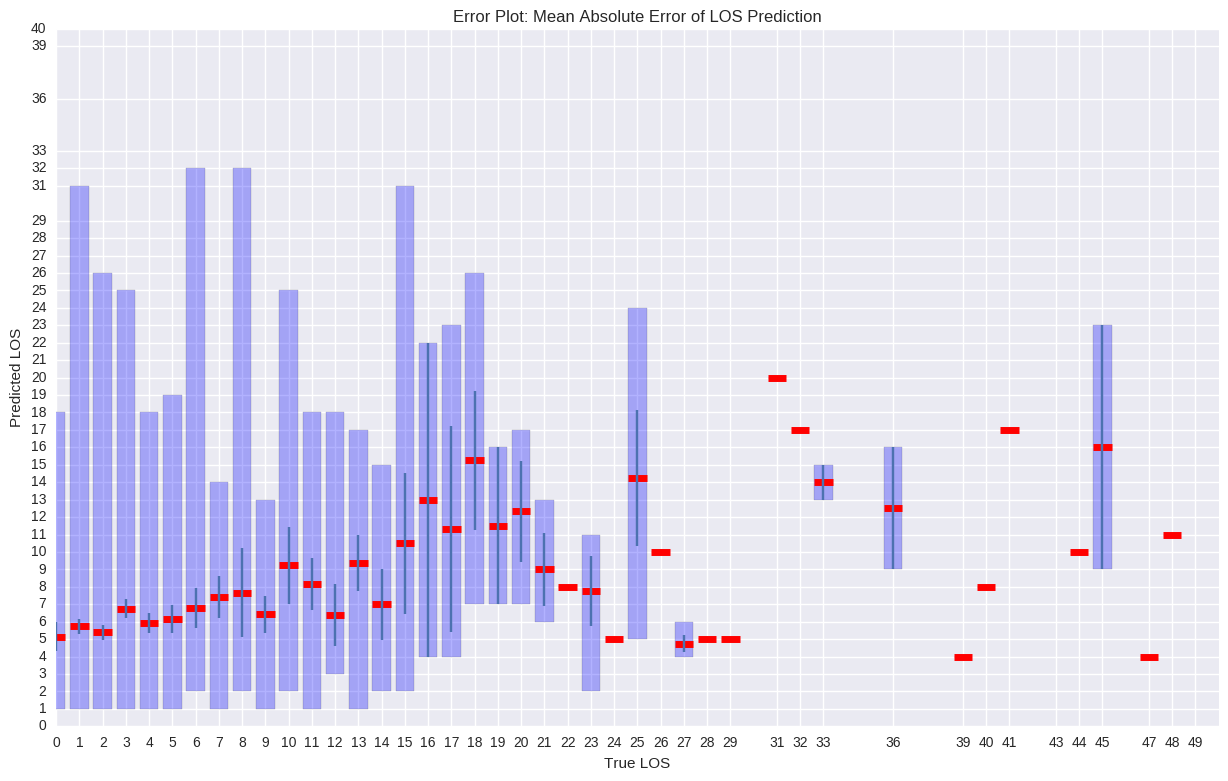

In [193]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in rf_errort5.index.tolist()], 
        height=rf_errort5[['pred']].values[:,3] - rf_errort5[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=rf_errort5[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in rf_errort5.index.tolist()], 
        height=[0]*len(rf_errort5), 
        width=0.8, 
        bottom=rf_errort5[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort5[['pred']].values[:,2] / rf_errort5[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(rf_errort5.index)
plt.yticks(rf_errort5.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Model: Gradient Boosting Regressor

In [194]:
gbr_model5, gbr_pred5, gbr_p5, gbr_score5 = gbr_gridsearch(select_X_train5, select_X_test5, y_train)
print "Best Parameters: ", gbr_p5
print "Best Grid Search Score: ", gbr_score5
print "Best Estimator: ", gbr_model5

Best Parameters:  {'loss': 'lad', 'criterion': 'mae'}
Best Grid Search Score:  0.0365142412032
Best Estimator:  GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=2, subsample=1.0, verbose=0,
             warm_start=False)


#### Compare Predictions

In [196]:
gbr_pred5[-10:]

array([ 6.23992374,  2.25614189,  1.55878453,  3.5401782 ,  4.23974892,
        3.3869828 ,  1.72909983,  2.45747871,  4.23715869,  1.72755936])

In [197]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

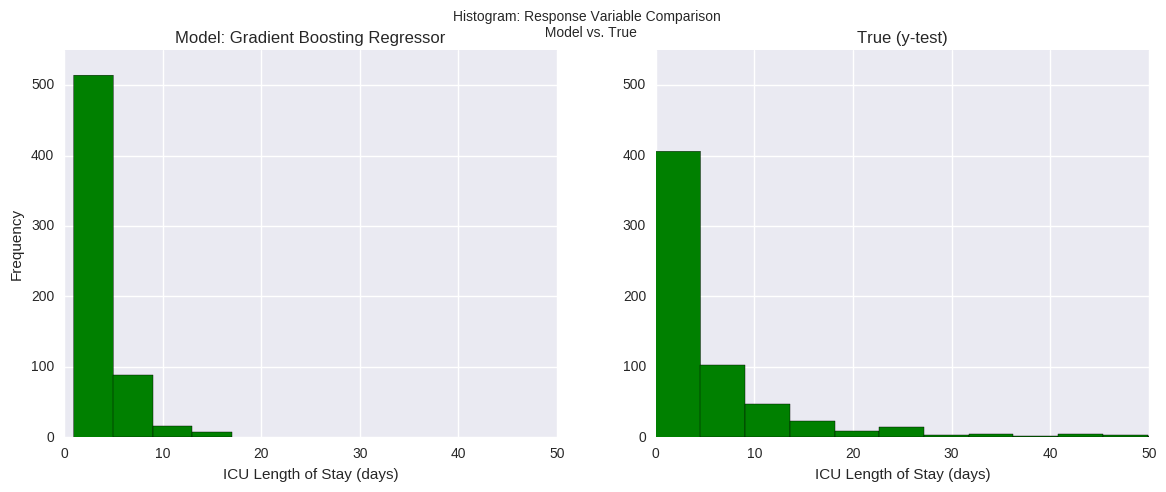

In [203]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(gbr_pred5), bins=4, color='g')
plt.title("Model: Gradient Boosting Regressor")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [204]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, gbr_pred5))

RMSE = 9.195 days


In [205]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [206]:
print " MAE = %.3f" % mean_absolute_error(y_test, gbr_pred5)

 MAE = 4.500


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [207]:
print "r2 = %.3f" % r2_score(y_test, gbr_pred5)

r2 = 0.048


### Error Visualization (MAE)

In [208]:
df_gbrpred5 = pd.Series(gbr_pred5, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_gbrresults5 = pd.concat([df_true, df_gbrpred5], axis=1)
gbr_residual5 = pd.Series(df_gbrresults5['true'].sub(df_gbrresults5['pred'], axis=0).abs(), name='resid')
df_gbrresults5 = pd.concat([df_gbrresults5, gbr_residual5], axis=1)

gbr_errort5 = df_gbrresults5[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

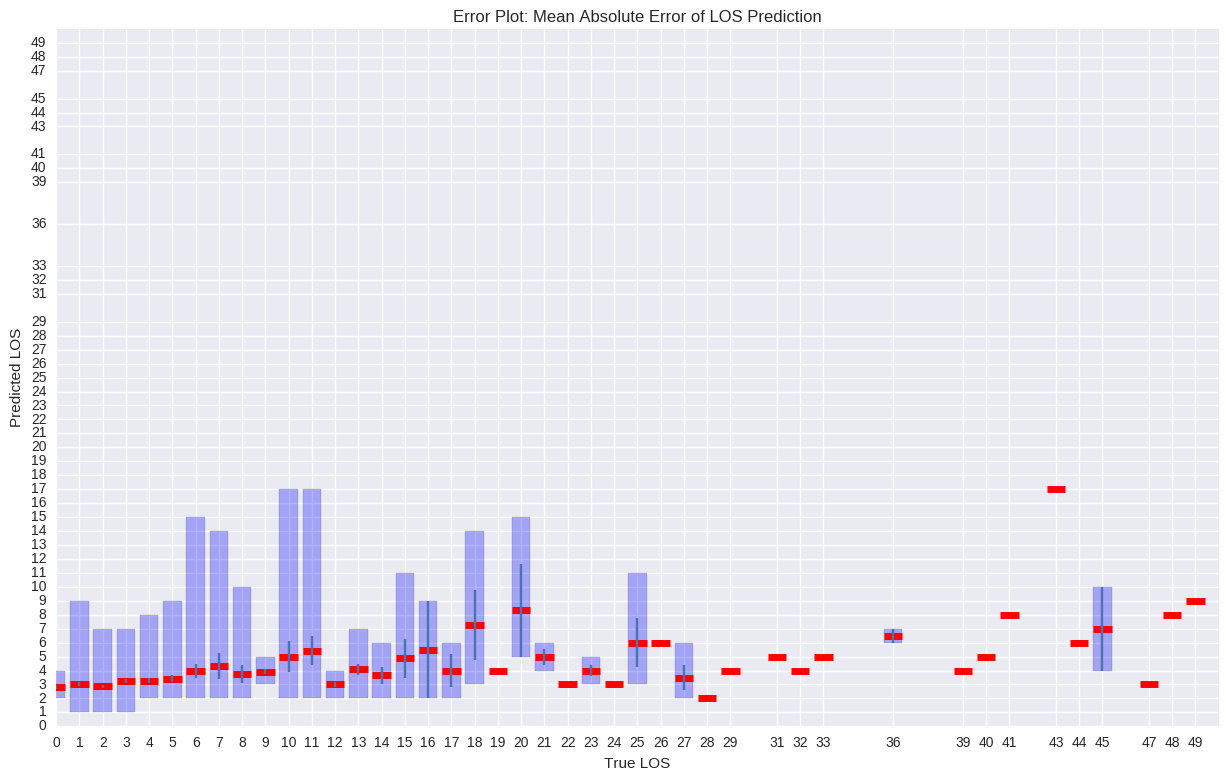

In [209]:
plt.subplots(1,1,figsize=(15,9))

# error bar
plt.bar(left=[i for i in gbr_errort5.index.tolist()], 
        height=gbr_errort5[['pred']].values[:,3] - gbr_errort5[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=gbr_errort5[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in gbr_errort5.index.tolist()], 
        height=[0]*len(gbr_errort5), 
        width=0.8, 
        bottom=gbr_errort5[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=gbr_errort5[['pred']].values[:,2] / gbr_errort5[['pred']].values[:,-1] ** 0.5,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(gbr_errort5.index)
plt.yticks(gbr_errort5.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,50])
plt.ylim([0,50])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Feature Selection: Variance Threshold

Selects features with variance above the threshold. 

`Default` threshold of 0, keeps all features with *non-zero* variance and removes features with the same value in all samples.

In [68]:
var_selector = VarianceThreshold(threshold=0.9)
select_X_train6 = var_selector.fit_transform(scaled_X_train)
select_X_test6 = var_selector.transform(scaled_X_test)

select_X_train6.shape, select_X_test6.shape, y_train.shape, y_test.shape

((2873, 33), (627, 33), (2873,), (627,))

### Model: Linear Regression

In [69]:
lr_model6, lr_pred6, lr_p6, lr_score6 = lr_gridsearch(select_X_train6, select_X_test6, y_train)
print "Best Parameters: ", lr_p6
print "Best Grid Search Score: ", lr_score6
print "Best Estimator: ", lr_model6

Best Parameters:  {'normalize': True, 'fit_intercept': True}
Best Grid Search Score:  0.231063095017
Best Estimator:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


#### Compare Predictions

In [70]:
lr_pred6[-10:]

array([ 13.0143171 ,   4.87350967,   3.21947494,   7.62160854,
        13.89980333,   8.12699456,   0.31341472,   3.18142097,
        13.75714529,   2.83967683])

In [71]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

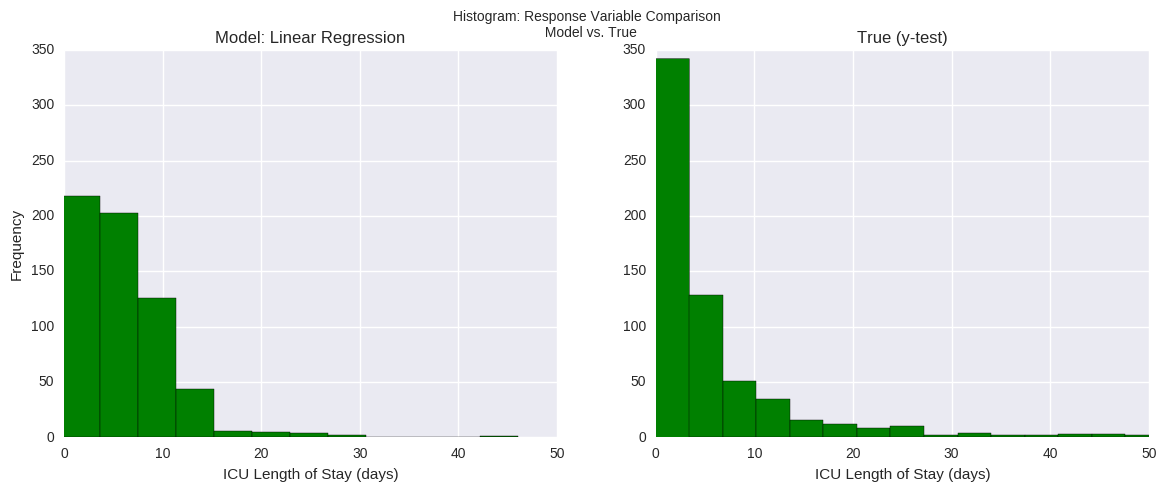

In [76]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred6), bins=13, color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,350])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0,350])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [78]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, lr_pred6))

RMSE = 8.041 days


In [79]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [80]:
print " MAE = %.3f" % mean_absolute_error(y_test, lr_pred6)

 MAE = 4.811


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [81]:
print "r2 = %.3f" % r2_score(y_test, lr_pred6)

r2 = 0.272


### Error Visualization (MAE)

In [82]:
df_lrpred6 = pd.Series(lr_pred6, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_results6 = pd.concat([df_true, df_lrpred6], axis=1)
residual6 = pd.Series(df_results6['true'].sub(df_results6['pred'], axis=0).abs(), name='resid')
df_results6 = pd.concat([df_results6, residual6], axis=1)

lr_errort6 = df_results6[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

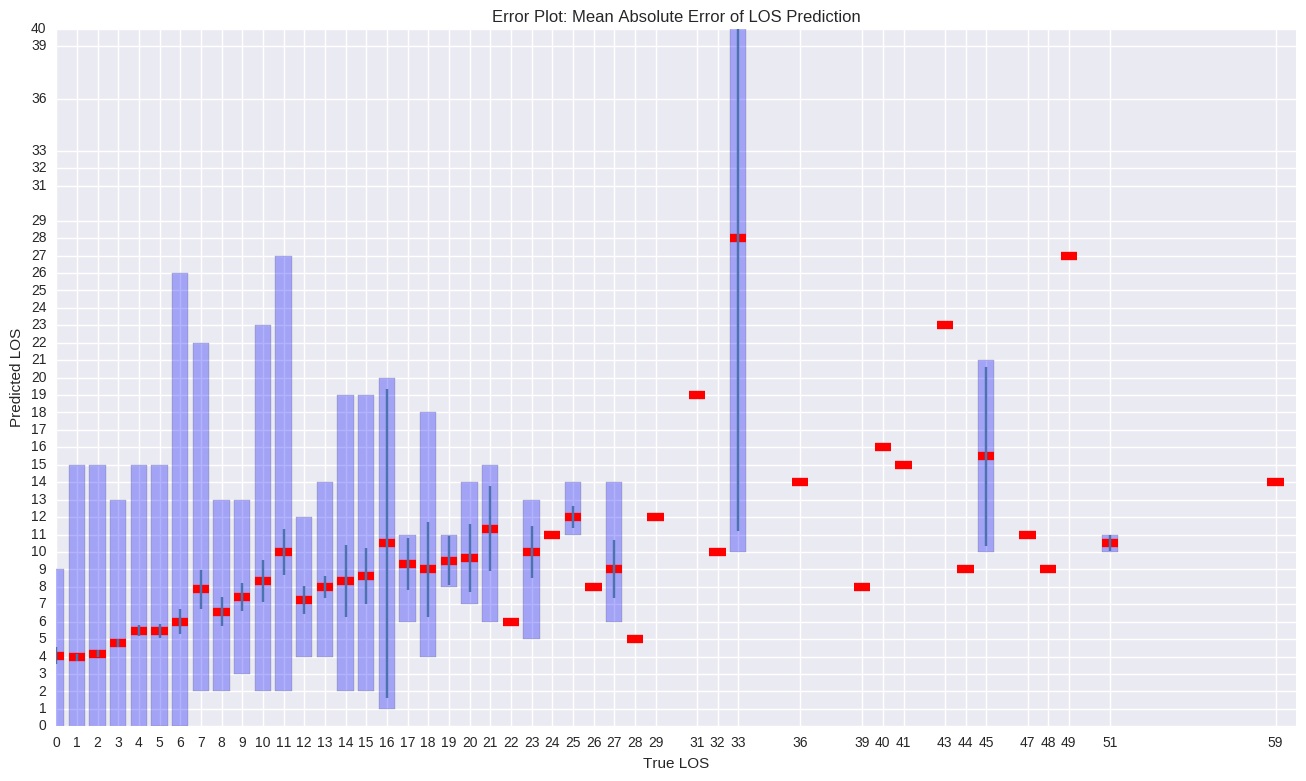

In [83]:
plt.subplots(1,1,figsize=(16,9))

# error bar
plt.bar(left=[i for i in lr_errort6.index.tolist()], 
        height=lr_errort6[['pred']].values[:,3] - lr_errort6[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=lr_errort6[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in lr_errort6.index.tolist()], 
        height=[0]*len(lr_errort6), 
        width=0.8, 
        bottom=lr_errort6[['pred']].values[:,0], # mean of predictions
        linewidth=6, edgecolor='r', align='center',
        yerr=lr_errort6[['pred']].values[:,2] / lr_errort6[['pred']].values[:,-1] ** 0.6,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(lr_errort6.index)
plt.yticks(lr_errort6.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,60])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: Support Vector Regression

In [115]:
svr_model6, svr_pred6, svr_p6, svr_score6 = svr_gridsearch(select_X_train6, select_X_test6, y_train)
print "Best Parameters: ", svr_p6
print "Best Grid Search Score: ", svr_score6
print "Best Estimator: ", svr_model6

Best Parameters:  {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
Best Grid Search Score:  0.218935611207
Best Estimator:  SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


#### Compare Predictions

In [116]:
svr_pred6[-10:]

array([ 6.74712018,  1.58814174,  2.63668716,  4.49498176,  6.46606296,
        6.2856588 ,  1.55492476,  3.00934189,  9.89423231,  1.30696457])

In [117]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

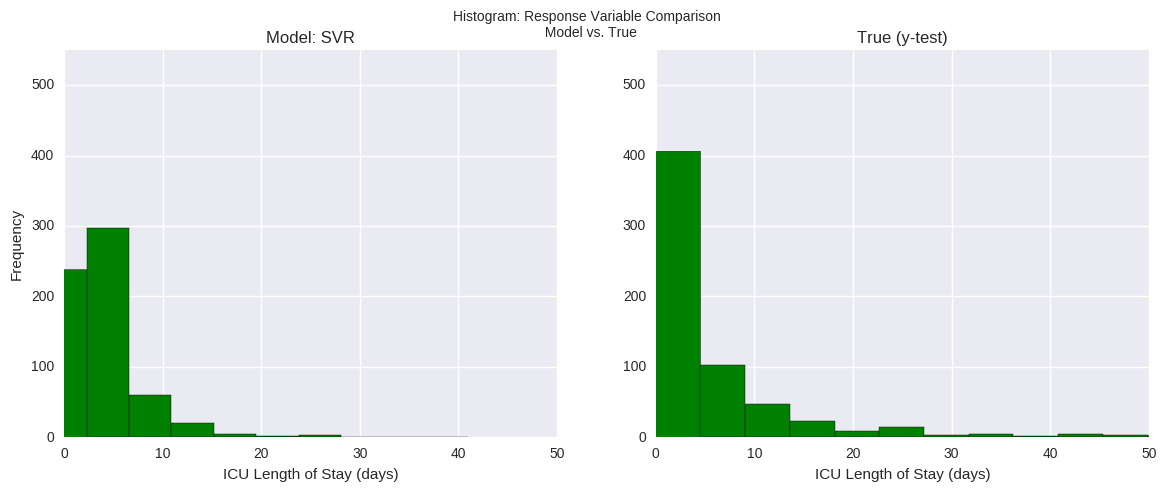

In [125]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred6), bins=10, color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,550])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [126]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, svr_pred6))

RMSE = 8.243 days


In [127]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [128]:
print " MAE = %.3f" % mean_absolute_error(y_test, svr_pred6)

 MAE = 4.287


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [129]:
print "r2 = %.3f" % r2_score(y_test, svr_pred6)

r2 = 0.235


### Error Visualization (MAE)

In [130]:
df_svrpred6 = pd.Series(svr_pred6, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_svrresults6 = pd.concat([df_true, df_svrpred6], axis=1)
svr_residual6 = pd.Series(df_svrresults6['true'].sub(df_svrresults6['pred'], axis=0).abs(), name='resid')
df_svrresults6 = pd.concat([df_svrresults6, svr_residual6], axis=1)

svr_errort6 = df_svrresults6[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

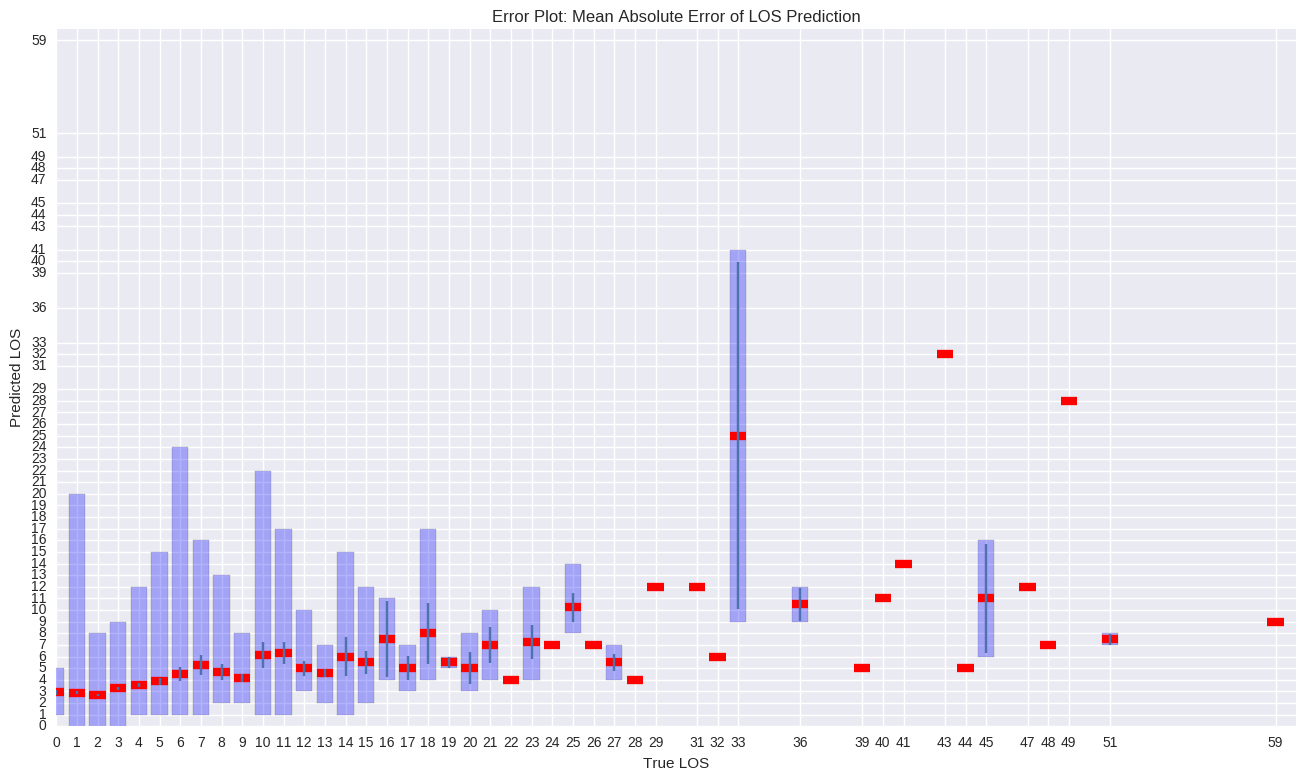

In [131]:
plt.subplots(1,1,figsize=(16,9))

# error bar
plt.bar(left=[i for i in svr_errort6.index.tolist()], 
        height=svr_errort6[['pred']].values[:,3] - svr_errort6[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=svr_errort6[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in svr_errort6.index.tolist()], 
        height=[0]*len(svr_errort6), 
        width=0.8, 
        bottom=svr_errort6[['pred']].values[:,0], # mean of predictions
        linewidth=6, edgecolor='r', align='center',
        yerr=svr_errort6[['pred']].values[:,2] / svr_errort6[['pred']].values[:,-1] ** 0.6,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(svr_errort6.index)
plt.yticks(svr_errort6.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,60])
plt.ylim([0,60])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

### Model: k-Nearest Neighbors

In [84]:
knn_model6 = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model6.fit(select_X_train6, y_train) # fit model on training data
knn_pred6 = knn_model6.predict(select_X_test6)

#### Compare Predictions

In [85]:
knn_pred6[-10:]

array([  9.97202,   4.81802,   3.39842,   1.38708,  13.3885 ,   9.20006,
         2.6585 ,   2.52596,  20.20502,   3.35754])

In [101]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

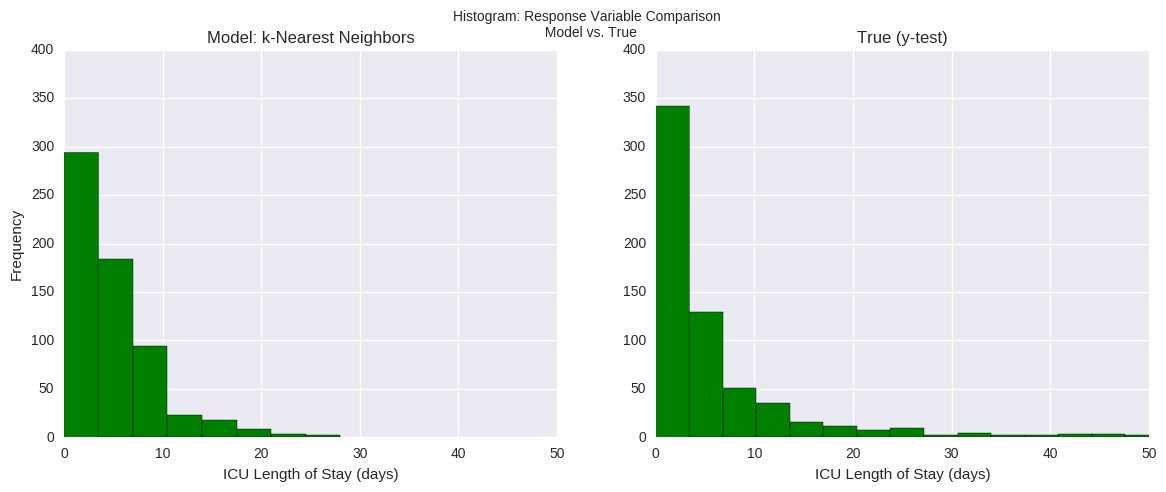

In [86]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred6), bins=8, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 400])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [87]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, knn_pred6))

RMSE = 8.674 days


In [112]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [88]:
print " MAE = %.3f" % mean_absolute_error(y_test, knn_pred6)

 MAE = 4.785


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [89]:
print "r2 = %.3f" % r2_score(y_test, knn_pred6)

r2 = 0.152


The k-NN model has very poor predictive power. This may be attributed to the fact that it's a "lazy learning" algorithm, *lacking generalization*. The model only does work (build a model) at the time of prediction and uses minimal, if any Training data.

### Error Visualization (MAE)

In [90]:
df_knnpred6 = pd.Series(knn_pred6, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_knnresults6 = pd.concat([df_true, df_knnpred6], axis=1)
knn_residual6 = pd.Series(df_knnresults6['true'].sub(df_knnresults6['pred'], axis=0).abs(), name='resid')
df_knnresults6 = pd.concat([df_knnresults6, knn_residual6], axis=1)

knn_errort6 = df_knnresults6[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

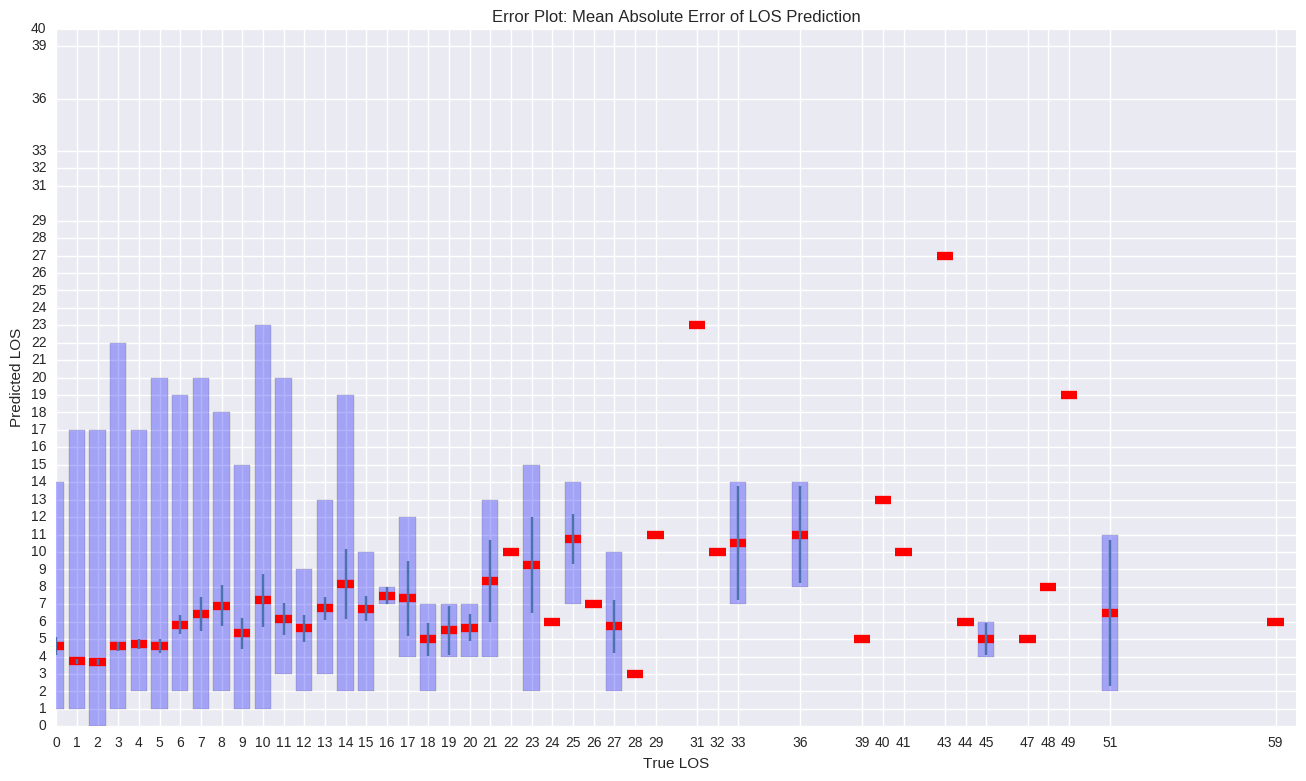

In [91]:
plt.subplots(1,1,figsize=(16,9))

# error bar
plt.bar(left=[i for i in knn_errort6.index.tolist()], 
        height=knn_errort6[['pred']].values[:,3] - knn_errort6[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=knn_errort6[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in knn_errort6.index.tolist()], 
        height=[0]*len(knn_errort6), 
        width=0.8, 
        bottom=knn_errort6[['pred']].values[:,0], # mean of predictions
        linewidth=6, edgecolor='r', align='center',
        yerr=knn_errort6[['pred']].values[:,2] / knn_errort6[['pred']].values[:,-1] ** 0.6,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(knn_errort6.index)
plt.yticks(knn_errort6.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,60])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [92]:
rf_model6, rf_pred6, rf_p6, rf_score6, rf_imp6 = rf_gridsearch(select_X_train6, select_X_test6, y_train)
print "Best Parameters: ", rf_p6
print "Best Grid Search Score: ", rf_score6
print "Best Estimator: ", rf_model6

Best Parameters:  {'n_estimators': 10, 'criterion': 'mae'}
Best Grid Search Score:  0.155506334734
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


#### Compare Predictions

In [93]:
rf_pred6[-10:]

array([  7.41141,   2.01592,   2.65823,   9.02618,  15.71725,   6.80274,
         1.5057 ,   4.9879 ,  11.24266,   2.22702])

In [94]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

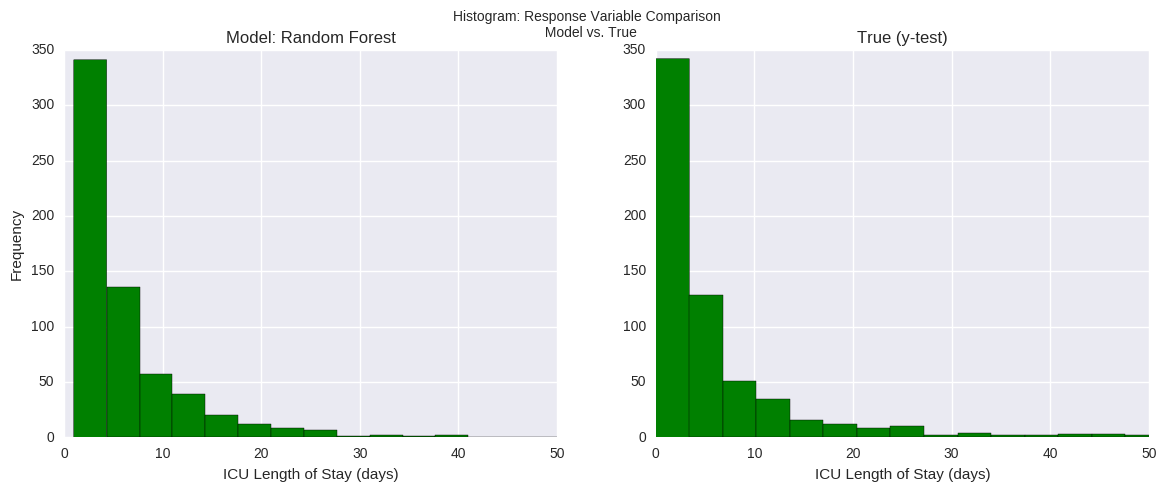

In [95]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred6), bins=18, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 350])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 350])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [96]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, rf_pred6))

RMSE = 8.393 days


In [97]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [98]:
print " MAE = %.3f" % mean_absolute_error(y_test, rf_pred6)

 MAE = 4.833


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [99]:
print "r2 = %.3f" % r2_score(y_test, rf_pred6)

r2 = 0.207


### Error Visualization (MAE)

In [100]:
df_rfpred6 = pd.Series(rf_pred6, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_rfresults6 = pd.concat([df_true, df_rfpred6], axis=1)
rf_residual6 = pd.Series(df_rfresults6['true'].sub(df_rfresults6['pred'], axis=0).abs(), name='resid')
df_rfresults6 = pd.concat([df_rfresults6, rf_residual6], axis=1)

rf_errort6 = df_rfresults6[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

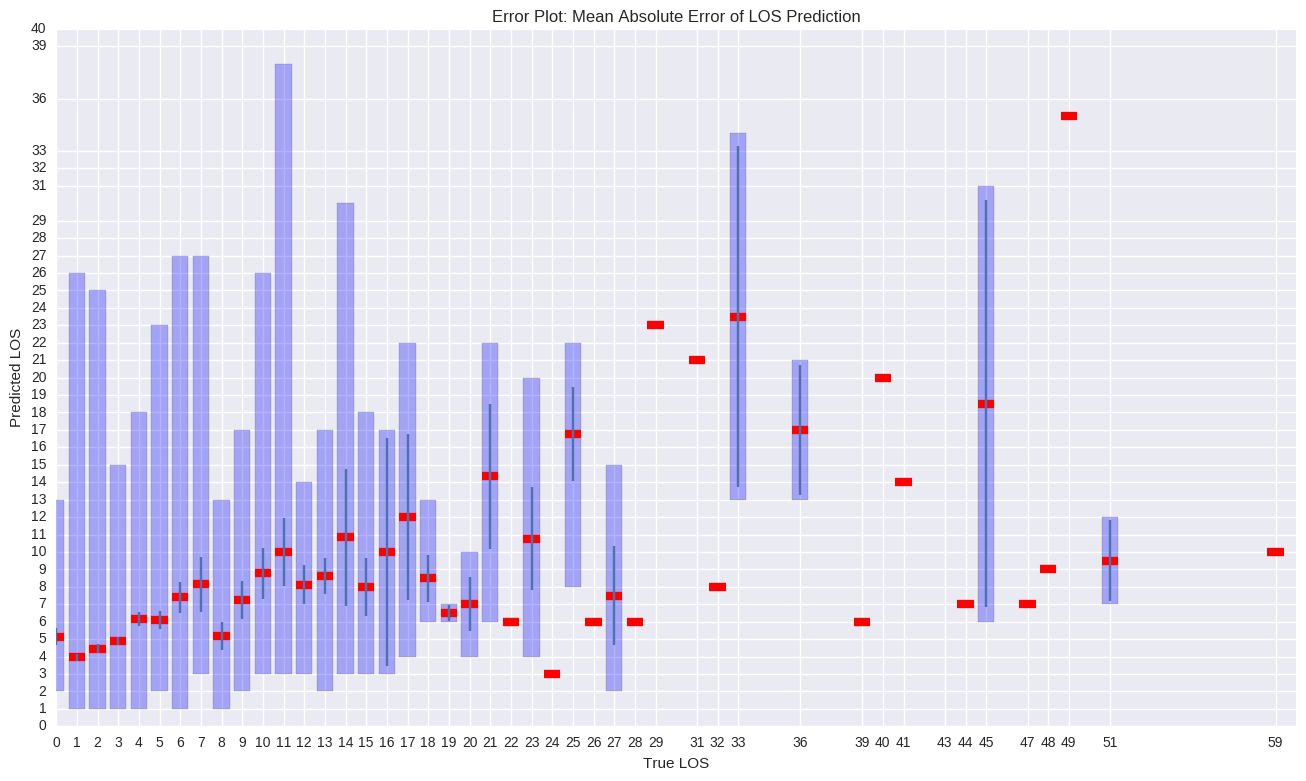

In [101]:
plt.subplots(1,1,figsize=(16,9))

# error bar
plt.bar(left=[i for i in rf_errort6.index.tolist()], 
        height=rf_errort6[['pred']].values[:,3] - rf_errort6[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=rf_errort6[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in rf_errort6.index.tolist()], 
        height=[0]*len(rf_errort6), 
        width=0.8, 
        bottom=rf_errort6[['pred']].values[:,0], # mean of predictions
        linewidth=6, edgecolor='r', align='center',
        yerr=rf_errort6[['pred']].values[:,2] / rf_errort6[['pred']].values[:,-1] ** 0.6,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(rf_errort6.index)
plt.yticks(rf_errort6.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,60])
plt.ylim([0,40])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

## Model: Gradient Boosting Regressor

In [102]:
gbr_model6, gbr_pred6, gbr_p6, gbr_score6 = gbr_gridsearch(select_X_train6, select_X_test6, y_train)
print "Best Parameters: ", gbr_p6
print "Best Grid Search Score: ", gbr_score6
print "Best Estimator: ", gbr_model6

Best Parameters:  {'loss': 'lad', 'criterion': 'friedman_mse'}
Best Grid Search Score:  0.171055910675
Best Estimator:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=2, subsample=1.0, verbose=0,
             warm_start=False)


#### Compare Predictions

In [103]:
gbr_pred6[-10:]

array([ 5.12358591,  2.83674576,  2.82541701,  5.15280355,  7.17857269,
        4.54119748,  2.18737374,  2.46672852,  8.67848492,  2.51452595])

In [104]:
y_test[-10:]

array([  3.3319,   2.3326,   8.2449,   1.4131,  13.3904,   1.1249,
         0.7122,   5.344 ,   4.8595,   0.8851])

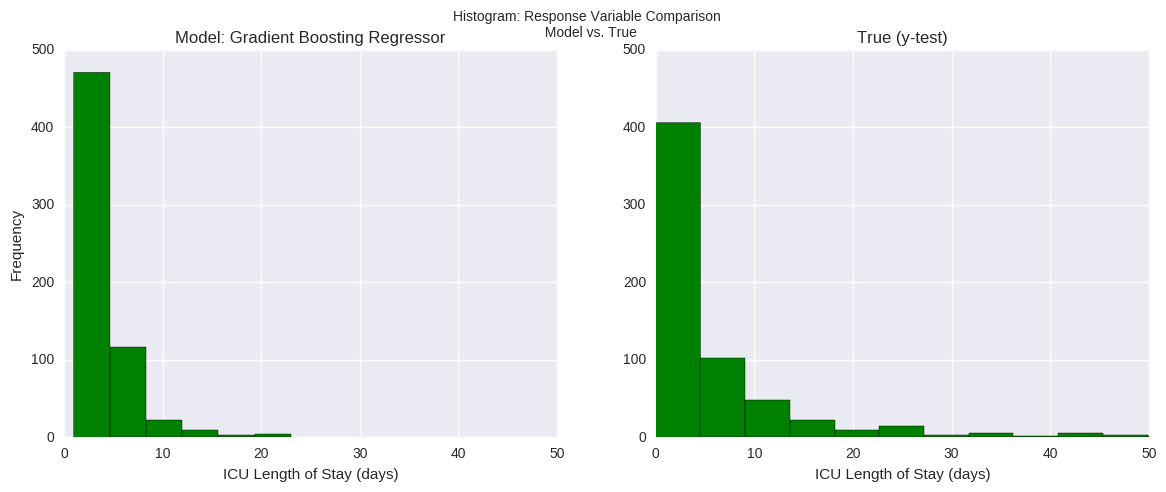

In [108]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(gbr_pred6), bins=6, color='g')
plt.title("Model: Gradient Boosting Regressor")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 500])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 500])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [109]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, gbr_pred6))

RMSE = 8.535 days


In [110]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [111]:
print " MAE = %.3f" % mean_absolute_error(y_test, gbr_pred6)

 MAE = 4.194


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [112]:
print "r2 = %.3f" % r2_score(y_test, gbr_pred6)

r2 = 0.179


### Error Visualization (MAE)

In [113]:
df_gbrpred6 = pd.Series(gbr_pred6, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_gbrresults6 = pd.concat([df_true, df_gbrpred6], axis=1)
gbr_residual6 = pd.Series(df_gbrresults6['true'].sub(df_gbrresults6['pred'], axis=0).abs(), name='resid')
df_gbrresults6 = pd.concat([df_gbrresults6, gbr_residual6], axis=1)

gbr_errort6 = df_gbrresults6[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

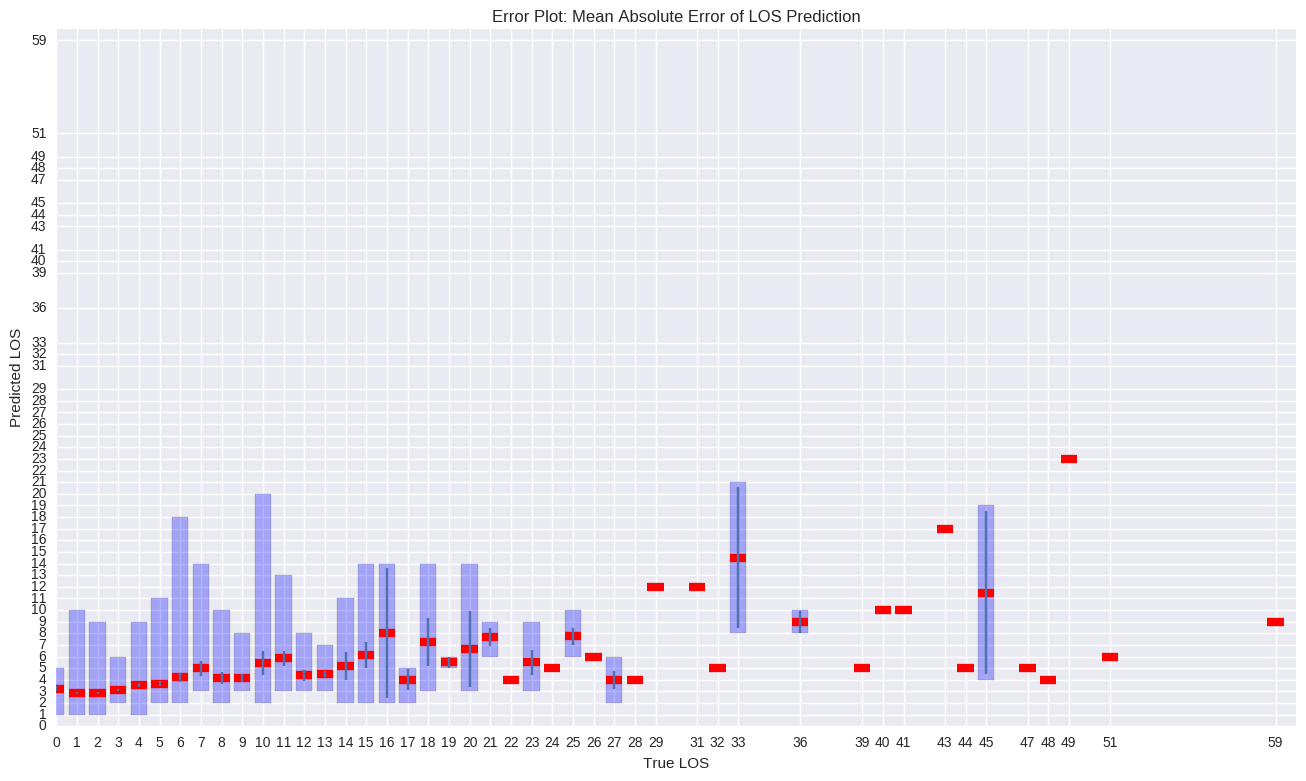

In [114]:
plt.subplots(1,1,figsize=(16,9))

# error bar
plt.bar(left=[i for i in gbr_errort6.index.tolist()], 
        height=gbr_errort6[['pred']].values[:,3] - gbr_errort6[['pred']].values[:,4], # range (max-min)
        width=0.8, 
        bottom=gbr_errort6[['pred']].values[:,4], # min
        color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in gbr_errort6.index.tolist()], 
        height=[0]*len(gbr_errort6), 
        width=0.8, 
        bottom=gbr_errort6[['pred']].values[:,0], # mean of predictions
        linewidth=6, edgecolor='r', align='center',
        yerr=gbr_errort6[['pred']].values[:,2] / gbr_errort6[['pred']].values[:,-1] ** 0.6,  # error: standard deviation & freq
        orientation='vertical')
    
plt.xlabel('True LOS')
plt.xticks(gbr_errort6.index)
plt.yticks(gbr_errort6.index)
plt.ylabel('Predicted LOS')
plt.xlim([0,60])
plt.ylim([0,60])
plt.title('Error Plot: Mean Absolute Error of LOS Prediction')
plt.show()

# Summary Results

## Training Data Distribution

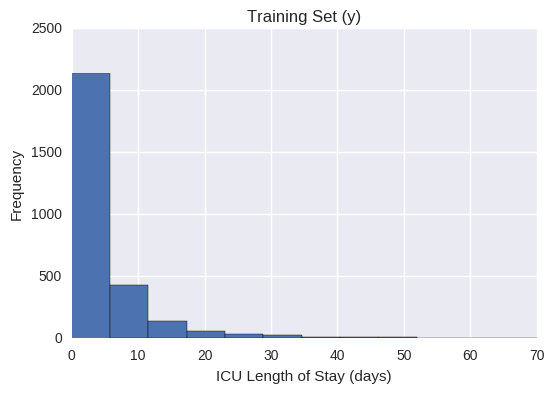

In [173]:
plt.hist(y_train, bins=30)
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,70])
plt.title('Training Set (y)')

## Random Forest Feature Importances

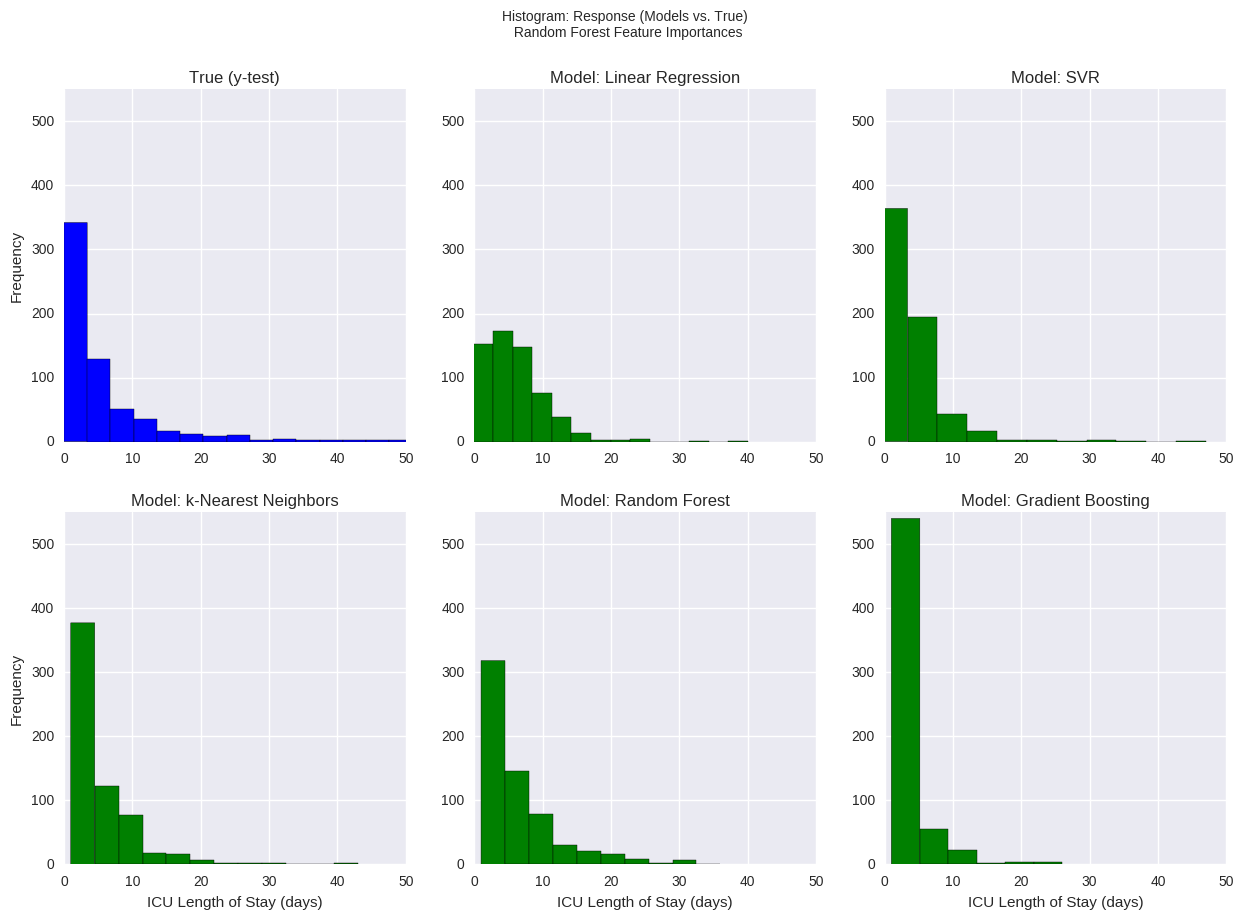

In [209]:
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.hist(np.round(y_test), bins=20, color='b')
plt.title("True (y-test)")
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 550])
plt.legend(loc='upper right')

plt.subplot(2,3,2)
plt.hist(np.round(lr_pred), bins=15, color='g')
plt.title("Model: Linear Regression")
plt.xlim([0,50])
plt.ylim([0,550])
plt.legend(loc='upper right')

plt.subplot(2,3,3)
plt.hist(np.round(svr_pred), bins=11, color='g')
plt.title("Model: SVR")
plt.xlim([0,50])
plt.ylim([0,550])
plt.legend(loc='upper right')

plt.subplot(2,3,4)
plt.hist(np.round(knn_pred), bins=12, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,550])
plt.legend(loc='upper right')

plt.subplot(2,3,5)
plt.hist(np.round(rf_pred), bins=10, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0,550])
plt.legend(loc='upper right')

plt.subplot(2,3,6)
plt.hist(np.round(gbr_pred), bins=6, color='g')
plt.title("Model: Gradient Boosting")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0,550])
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n Random Forest Feature Importances')

plt.show()

## Univariate Feature Selection (F-Regression)

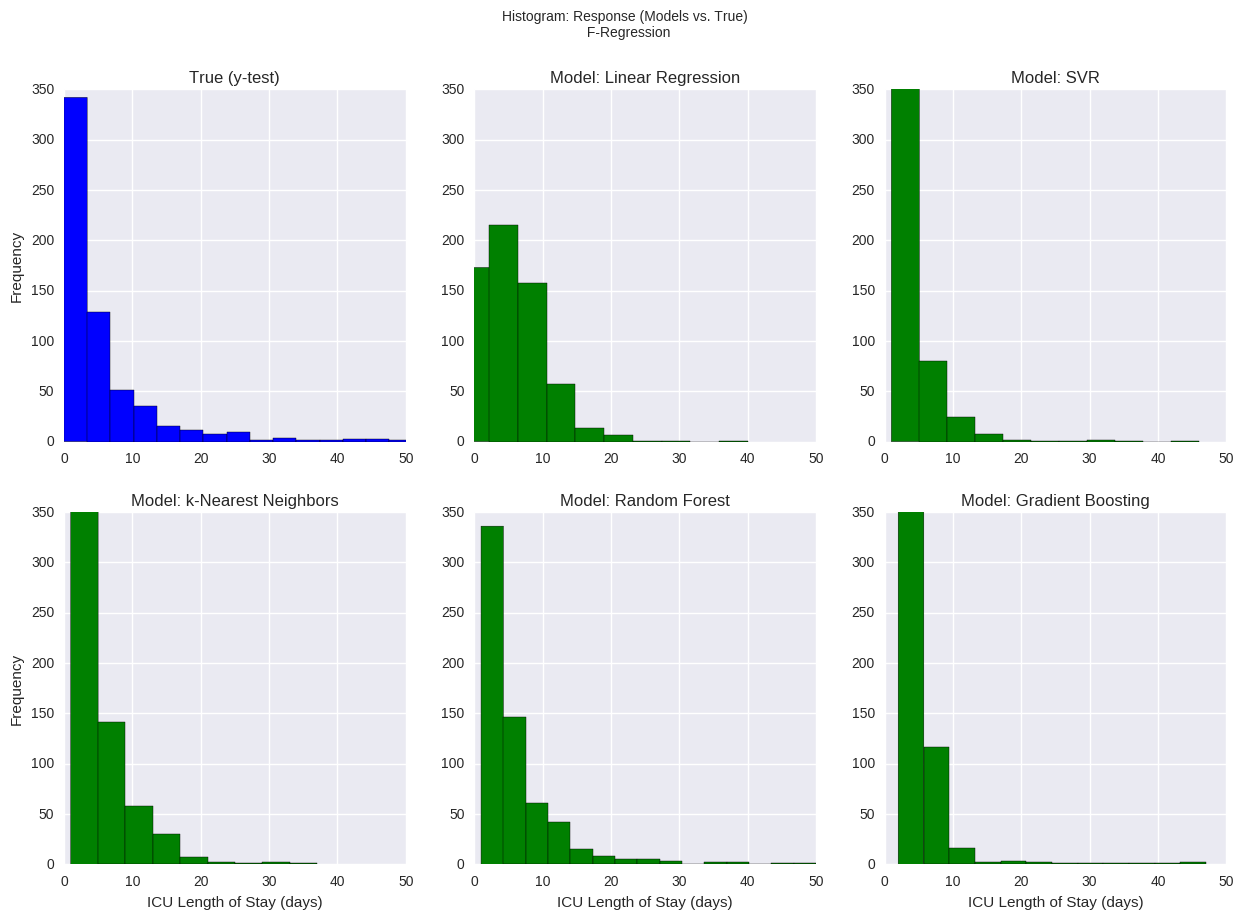

In [104]:
x_lim = [0,50]
y_lim = [0,350]

plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.hist(np.round(y_test), bins=20, color='b')
plt.title("True (y-test)")
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,2)
plt.hist(np.round(lr_pred2), bins=10, color='g')
plt.title("Model: Linear Regression")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,3)
plt.hist(np.round(svr_pred2), bins=11, color='g')
plt.title("Model: SVR")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,4)
plt.hist(np.round(knn_pred2), bins=9, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,5)
plt.hist(np.round(rf_pred2), bins=15, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,6)
plt.hist(np.round(gbr_pred2), bins=12, color='g')
plt.title("Model: Gradient Boosting")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n F-Regression')

plt.show()

## Random Feature Selection (`np.random`)

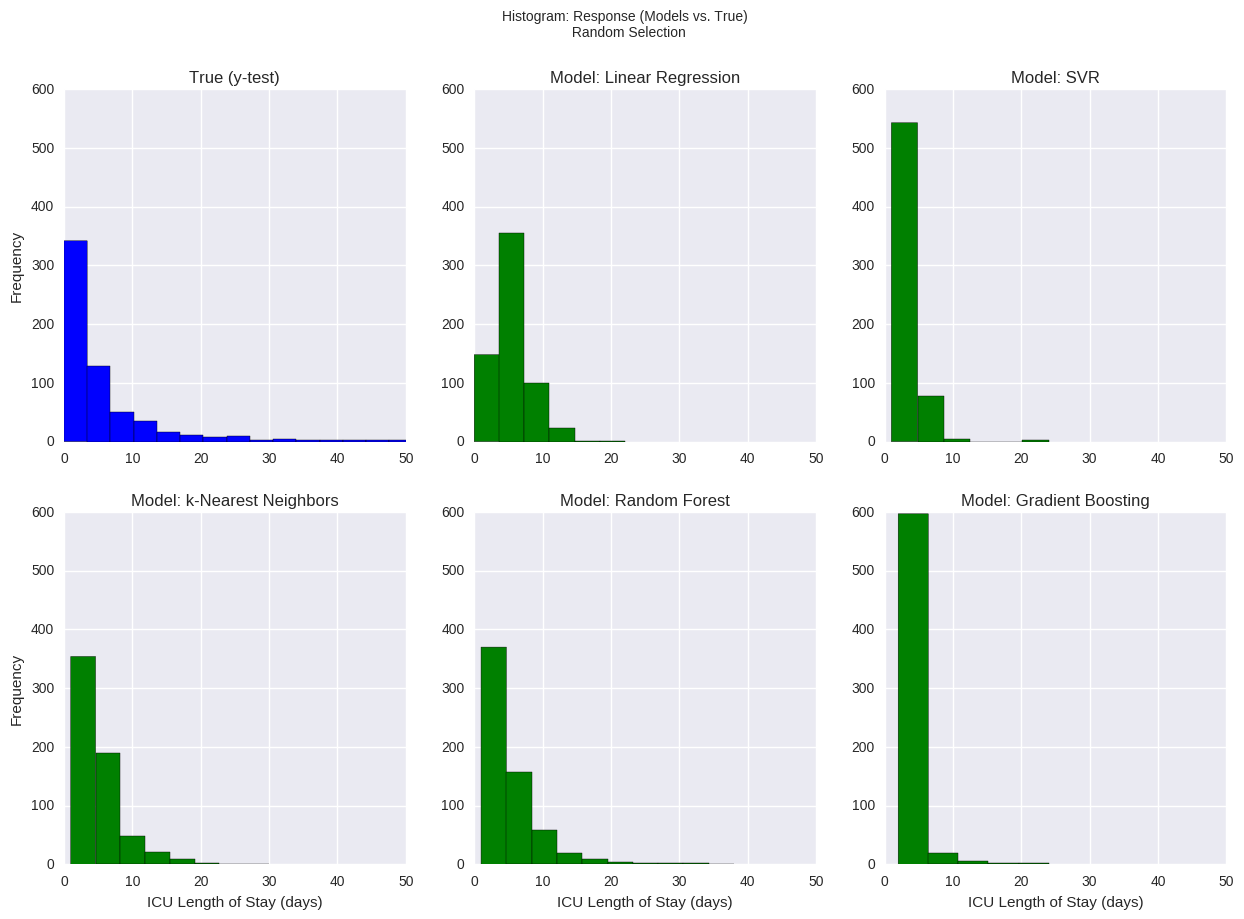

In [165]:
x_lim = [0,50]
y_lim = [0,600]

plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.hist(np.round(y_test), bins=20, color='b')
plt.title("True (y-test)")
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,2)
plt.hist(np.round(lr_pred3), bins=6, color='g')
plt.title("Model: Linear Regression")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,3)
plt.hist(np.round(svr_pred3), bins=6, color='g')
plt.title("Model: SVR")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,4)
plt.hist(np.round(knn_pred3), bins=8, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,5)
plt.hist(np.round(rf_pred3), bins=10, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,6)
plt.hist(np.round(gbr_pred3), bins=5, color='g')
plt.title("Model: Gradient Boosting")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n Random Selection')
plt.show()

## PCA

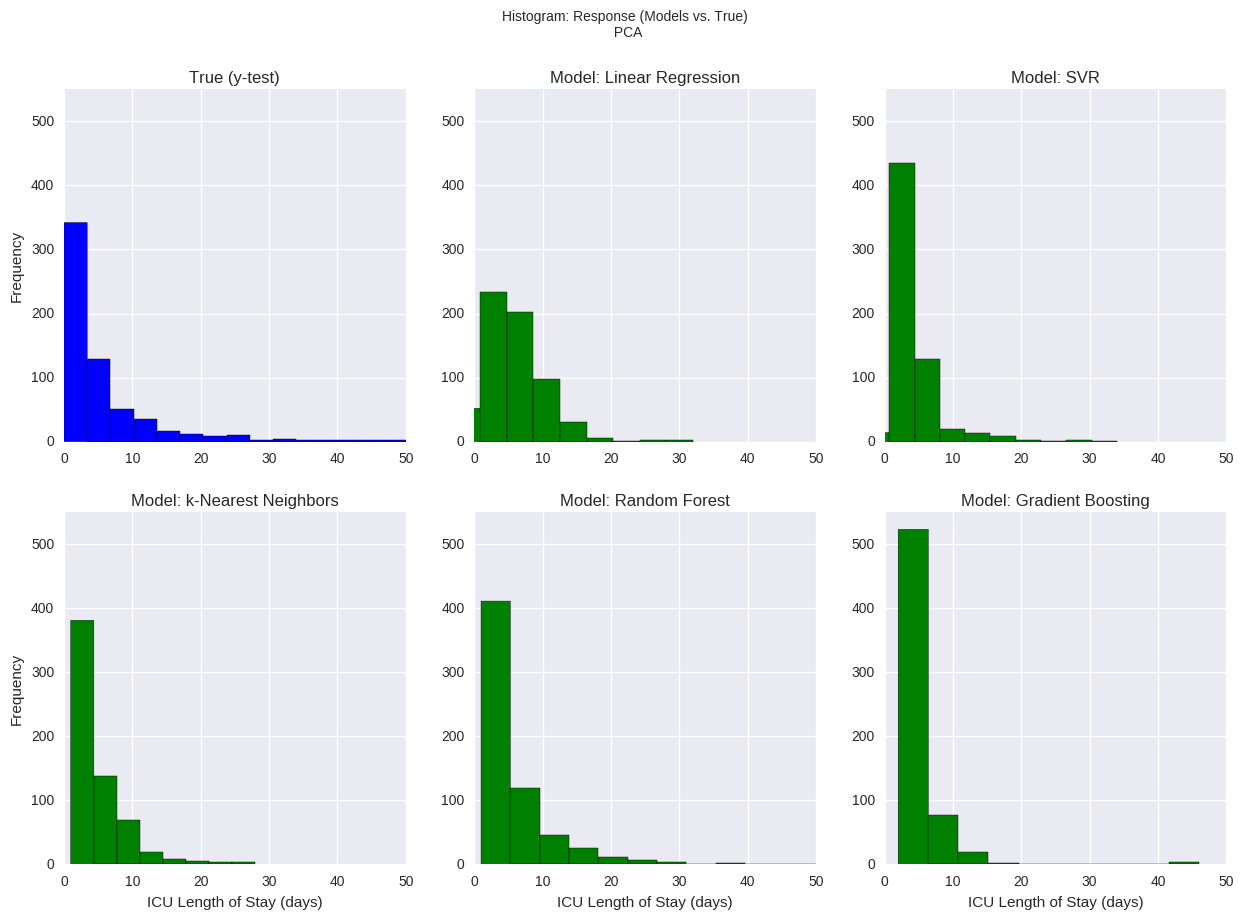

In [157]:
x_lim = [0,50]
y_lim = [0,550]

plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.hist(np.round(y_test), bins=20, color='b')
plt.title("True (y-test)")
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,2)
plt.hist(np.round(lr_pred4), bins=9, color='g')
plt.title("Model: Linear Regression")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,3)
plt.hist(np.round(svr_pred4), bins=10, color='g')
plt.title("Model: SVR")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,4)
plt.hist(np.round(knn_pred4), bins=8, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,5)
plt.hist(np.round(rf_pred4), bins=14, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,6)
plt.hist(np.round(gbr_pred4), bins=10, color='g')
plt.title("Model: Gradient Boosting")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n PCA')
plt.show()

## K-Means Clustering Feature Selection

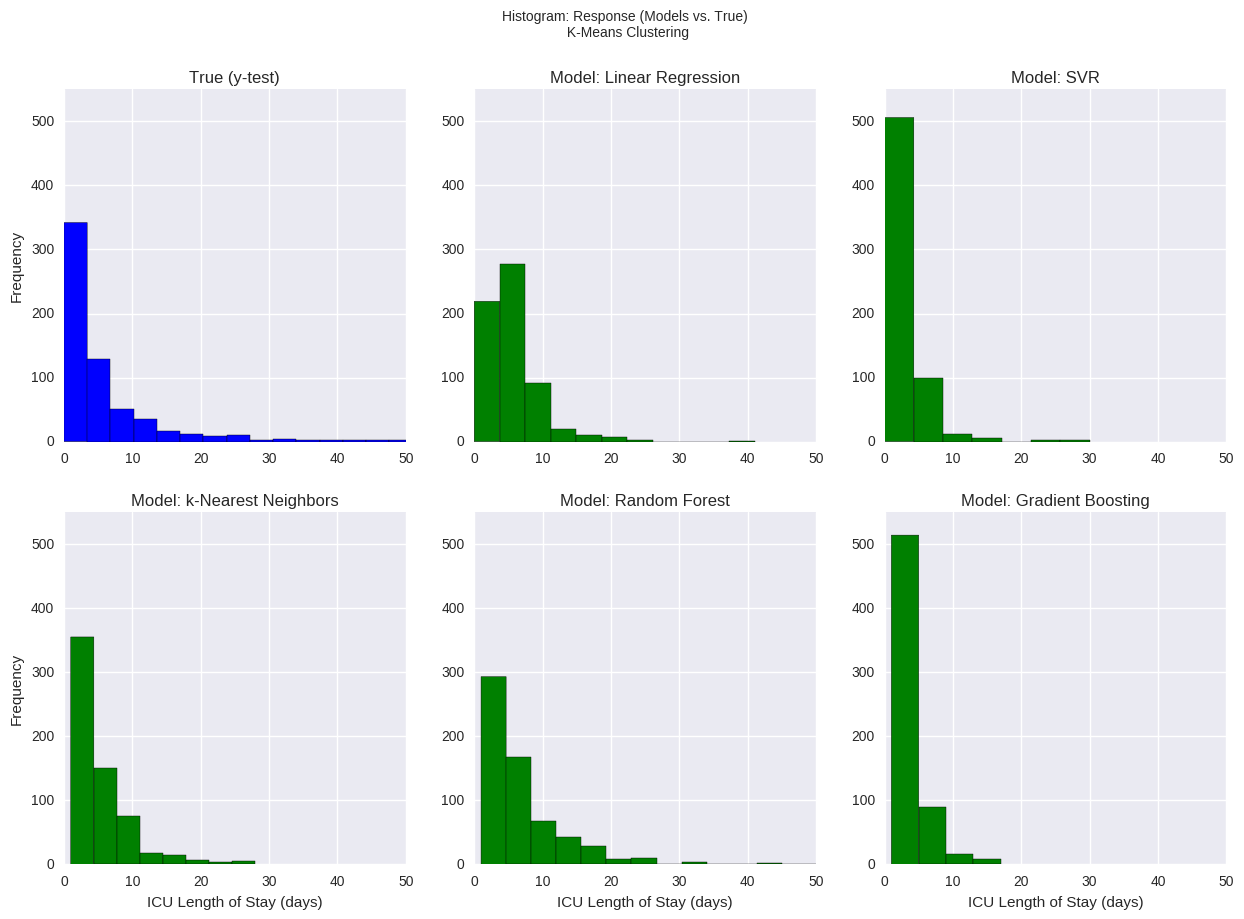

In [210]:
x_lim = [0,50]
y_lim = [0,550]

plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.hist(np.round(y_test), bins=20, color='b')
plt.title("True (y-test)")
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,2)
plt.hist(np.round(lr_pred5), bins=11, color='g')
plt.title("Model: Linear Regression")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,3)
plt.hist(np.round(svr_pred5), bins=7, color='g')
plt.title("Model: SVR")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,4)
plt.hist(np.round(knn_pred5), bins=8, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,5)
plt.hist(np.round(rf_pred5), bins=18, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,6)
plt.hist(np.round(gbr_pred5), bins=4, color='g')
plt.title("Model: Gradient Boosting")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n K-Means Clustering')
plt.show()

## Variance Threshold

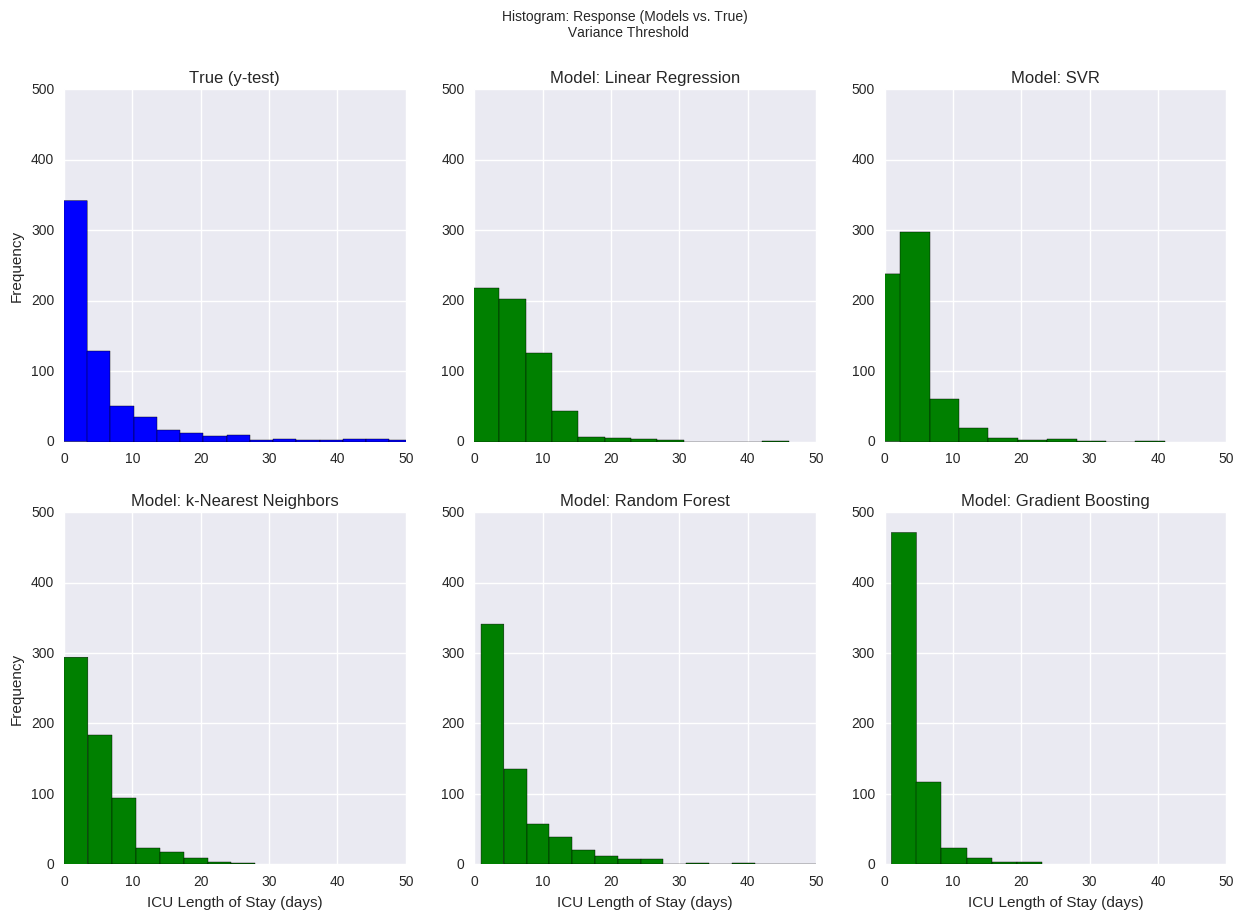

In [133]:
x_lim = [0,50]
y_lim = [0,500]

plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.hist(np.round(y_test), bins=20, color='b')
plt.title("True (y-test)")
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,2)
plt.hist(np.round(lr_pred6), bins=13, color='g')
plt.title("Model: Linear Regression")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,3)
plt.hist(np.round(svr_pred6), bins=10, color='g')
plt.title("Model: SVR")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,4)
plt.hist(np.round(knn_pred6), bins=8, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,5)
plt.hist(np.round(rf_pred6), bins=18, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,3,6)
plt.hist(np.round(gbr_pred6), bins=6, color='g')
plt.title("Model: Gradient Boosting")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n Variance Threshold')
plt.show()

## Conclusion
### Main Points
1. Overall, feature selection did not drastically improve the regression models.
  * Metrics generally got inferior (slightly higher **error estimates** (**RMSE** & **MAE**))
  * Mixed results for changes in **R<sup>2</sup>**, some slightly improved and some got a bit worse.
2. Feature selection by **Random Selection** (`np.random`) was the worst approach by far, where **Random Forest Feature Importance**, **Univariate Feature Selection** (*F-Regression*), and **Variance Threshold** were the better ones.
  * *Note*: Variance Threshold is limited to selecting only all, 33, or 8 features based on its computation of variances.

3. Metrics got worse with progressively increasing n<sub>selected features</sub> (*tested 25, 20, 10, 8 features selected*).

#### Future Improvements
  1. Current clinical features are not specific to the scope of ICU stays. Adjusting the features may yield improvements in metrics.

### Results
#### Random Forest Feature Importance
Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|8.1 (**-0.1**)|4.8 (**-0.1**)|0.26 (**+0.02**)
Support Vector Regression (*kernel: rbf*)|8.4 (**+0.2**)|4.3 (**0**)|0.20 (**-0.3**)
k-Nearest Neighbors|8.6 (**-0.1**)|4.8 (**0**)|0.17 (**+0.02**)
Random Forest|8.8 (**+0.5**)|5.2(**+0.4**)|0.13 (**-0.09**)
Gradient Boosting|8.6 (**+0.7**)|4.2 (**-0.3**)|0.18 (**-0.12**)

#### Univariate Feature Selection (F-Regression)
Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|8.1 (**-0.1**)|4.9 (**0**)|0.27 (**+0.03**)
Support Vector Regression (*kernel: rbf*)|8.3 (**+0.1**)|4.2 (**-0.1**)|0.23 (**0**)
k-Nearest Neighbors|8.6 (**-0.1**)|4.8 (**0**)|0.18 (**+0.03**)
Random Forest|8.9 (**+0.6**)|5.1 (**+0.3**)|0.10 (**-0.12**)
Gradient Boosting|8.3 (**+0.4**)|4.2 (**-0.3**)|0.22 (**-0.08**)

#### Random Selection (`np.random`)
Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|9.0 (**+0.8**)|5.0 (**+0.1**)|0.09 (**-0.15**)
Support Vector Regression (*kernel: rbf*)|9.6 (**+1.4**)|4.6 (**+0.3**)|-0.03 (**-0.26**)
k-Nearest Neighbors|9.6 (**+0.9**)|5.3(**+0.5**)|-0.03 (**-0.18**)
Random Forest|9.6 (**+1.3**)|5.6 (**+0.8**)|-0.11 (**-0.33**)
Gradient Boosting|9.4 (**+1.5**)|4.7 (**+0.2**)|0 (**-0.3**)

#### PCA
Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|8.1 (**-0.1**)|4.7 (**-0.2**)|0.27 (**+0.03**)
Support Vector Regression (*kernel: rbf*)|9.6 (**+1.4**)|4.6 (**+0.3**)|-0.03 (**-0.26**)
k-Nearest Neighbors|8.6 (**-0.1**)|4.7 (**-0.1**)|0.17 (**+0.2**)
Random Forest|8.5 (**+0.2**)|4.8 (**0**)|0.19 (**-0.03**)
Gradient Boosting|8.4 (**+0.5**)|4.3 (**-0.2**)|0.21 (**-0.09**)


#### K-Means Clustering
Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|8.6 (**+0.4**)|4.9 (**0**)|0.18 (**-0.06**)
Support Vector Regression (*kernel: rbf*)|9.0 (**+0.8**)|4.5 (**+0.2**)|0.09 (**-0.14**)
k-Nearest Neighbors|9.2 (**+0.5**)|5.3 (**+0.5**)|0.05 (**-0.10**)
Random Forest|8.9 (**+0.6**)|5.6 (**+0.8**)|0.11 (**-0.11**)
Gradient Boosting|9.2 (**+1.3**)|4.5 (**0**)|0.05 (**-0.25**)

#### Variance Threshold (n=33)
Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|8.1 (**-0.1**)|4.8 (**-0.1**)|0.27 (**+0.03**)
Support Vector Regression (*kernel: rbf*)|8.2 (**0**)|4.3 (**0**)|0.24 (**+0.01**)
k-Nearest Neighbors|8.7 (**0**)|4.8 (**0**)|0.15 (**0**)
Random Forest|8.4 (**+0.1**)|4.8 (**0**)|0.21 (**-0.01**)
Gradient Boosting|8.5 (**+0.6**)|4.2 (**-0.3**)|0.18 (**-0.12**)